# **Introduction**
In our group's second project (group eleven), we will test models based on the Transformer architecture and different training methods on the Question Answering problem.

The dataset we use is SQuAD version 2 available at HuggingFace. This dataset is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

This second edition combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written by community staff to resemble answerable questions. To work well on SQuAD2.0, the system must not only answer questions when possible, but also identify when the passage does not support any answer and avoid answering.

# **Run Testing and Infrencing**
To run model testing or Inferencing, first download the following files:
  * Tokenizer file to be able to use the tokenizer we trained on the SQuAD 2.0 dataset.
  * File tokenized dataset.
  * One of the model checkpoint files that you want to run for testing.
Download files at [Project2_Group11_Files](https://drive.google.com/drive/folders/1CociCp10bOWEktTDE7kMqKr9DsetXSvG?usp=sharing)


To run model tests, run the following:
  * Run the "Import the necessary libraries" section.
  * Run the "Important class and constant" section.
  * Run one of the three model section (Transformer, Span Text Transformer or BERT + BART Question Answering) that you want to test in the "Model Section".
  * Move to the Testing section, first change change the paths to the files to match where you placed the files, then run prepare data for testing (choosing one of the choose sub-section: Transformer-based models for Transformers or Span Text Transformer; BERT + BART for BERT + BART for the remaining model.)
  * Then run the Testing Process section (also choose the subsection model that you want to test)  



# **Import the necessary libraries**

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00


In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
import re
import math
import json
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from evaluate import load
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import Optimizer
from collections import defaultdict
from nltk.tokenize import sent_tokenize
from torch.utils.data import DataLoader
from tokenizers import ByteLevelBPETokenizer
from datasets.dataset_dict import DatasetDict
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.tensorboard import SummaryWriter
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, load_from_disk, load_dataset, concatenate_datasets
from transformers import AutoTokenizer, BertTokenizer, BertModel, BartTokenizer, BartModel, BertConfig, BartConfig, get_linear_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup

# **Important class and constant**

In [ ]:
#Constant
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default

#Check device
DEVICE= torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#Function to get answer_end_list
def get_answer_end_list(example):
  num_answer = len(example['answers']['text'])
  answer_end_list = []
  for i in range(num_answer):
    if example['answers']['text'][i][0] == ' ':
      answer_end_list.append(example['answers']['answer_start'][i] + len(example['answers']['text'][i]) - 1)
    else:
      answer_end_list.append(example['answers']['answer_start'][i] + len(example['answers']['text'][i]))
  return answer_end_list

In [ ]:
#Function to get start and end of each sentence in sentence list in context
def get_sentence_start_end_list(example):
  context = example['context']
  sentence_list = example['sentence_list']
  start_end_list = []
  for sentence in sentence_list:
    start_index = context.find(sentence)
    end_index = start_index + len(sentence)
    start_end_list.append((start_index, end_index))
  return start_end_list

In [ ]:
#Function to get span_start, span_end and span_text
def get_span_data(example):
  answer_start = example['span_start']
  answer_end = example['answer_end_span']
  sentence_start_end_list = example['sentence_start_end_list']
  context = example['context']
  span_text = ''
  first_sentence = True
  if answer_start == -1 and answer_end == -1:
    span_start = -1
    span_end = -1
    return span_start, span_end, span_text
  else:
    for i in range(len(sentence_start_end_list)):
      sentence_start_end = sentence_start_end_list[i]
      if answer_start >= sentence_start_end[0] and answer_start <= sentence_start_end[1]:
        span_start = sentence_start_end[0]
        if i > 0:
          first_sentence = False
        break

    for sentence_start_end in sentence_start_end_list:
      if answer_end >= sentence_start_end[0] and answer_end <= sentence_start_end[1]:
        span_end = sentence_start_end[1]
        break

    span_text = context[span_start:span_end]
    if first_sentence == False:
      span_text = ' ' + span_text
    return span_start, span_end, span_text

In [ ]:
def find_sub_list(l, sl):
    #Find the sub list
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
      if l[ind:ind+sll]==sl:
        return ind, ind+sll-1

In [ ]:
def process_answer(example, tokenizer):
  #Get context ids
  context_ids = tokenizer.encode(example['context']).ids

  #Run through answer and get token ids
  answer_start_list = []
  if len(example['answers']['text']) == 0:
    return example
  for i in range(len(example['answers']['text'])):
    answer_ids_1 = tokenizer.encode(example['answers']['text'][i]).ids
    answer_ids_2 = tokenizer.encode(' ' + example['answers']['text'][i]).ids
    #Check if we can find answer ids in context ids
    if find_sub_list(context_ids, answer_ids_1) is None:
      if find_sub_list(context_ids, answer_ids_2) is None:
        continue
      else:
        example['answers']['text'][i] = ' ' + example['answers']['text'][i]
    else:
      continue

  return example

In [ ]:
#A class to get preprocessed data
class ProcessedSQuADV2:
  def __init__(self, dataset_dict, tokenizer):
    self.squad_v2_train_raw_dataset = dataset_dict['train']
    self.squad_v2_val_raw_dataset = dataset_dict['eval']
    self.squad_v2_test_raw_dataset = dataset_dict['test']
    self.tokenizer = tokenizer

  def tokenize_text(self, text):
    return self.tokenizer.encode(text).tokens, self.tokenizer.encode(text).ids

  def processing_train_dataset(self, example):
    if example['span_start'] == -1:
      example['answer'] = "Apologies, I couldn't find the answer."
      example['span_text'] = "Couldn't locate relevant sentences."
    else:
      example['answer'] = example['answers']['text'][0]
    example['answer_tokens'], example['answer_ids'] = self.tokenize_text(example['answer'])
    example['span_text_tokens'], example['span_text_ids'] = self.tokenize_text(example['span_text'])
    example['context_tokens'], example['context_ids'] = self.tokenize_text(example['context'])
    example['question_tokens'], example['question_ids'] = self.tokenize_text(example['question'])
    return example

  def processing_val_test_dataset(self, example):
    if example['span_start'] == -1:
      example['answers']['text'].append("Apologies, I couldn't find the answer.")
      example['span_text'] = "Couldn't locate relevant sentences."
    example['question_tokens'], example['question_ids'] = self.tokenize_text(example['question'])
    example['context_tokens'], example['context_ids'] = self.tokenize_text(example['context'])
    example['span_text_tokens'], example['span_text_ids'] = self.tokenize_text(example['span_text'])
    example['answers_tokens'], example['answers_ids'] = [], []
    for answer in example['answers']['text']:
      answer_tokens, answer_ids = self.tokenize_text(answer)
      example['answers_tokens'].append(answer_tokens)
      example['answers_ids'].append(answer_ids)
    return example


  def getting_processed_dataset(self):
    squad_v2_train_processed_dataset = self.squad_v2_train_raw_dataset.map(self.processing_train_dataset)
    squad_v2_val_processed_dataset = self.squad_v2_val_raw_dataset.map(self.processing_val_test_dataset)
    squad_v2_test_processed_dataset = self.squad_v2_test_raw_dataset.map(self.processing_val_test_dataset)
    return squad_v2_train_processed_dataset, squad_v2_val_processed_dataset, squad_v2_test_processed_dataset

In [ ]:
def casual_mask(size):
  mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int).to(DEVICE)
  return mask == 0

In [ ]:
def greedy_decode(model, input_ids, token_type_ids, attention_mask,
                  tokenizer:ByteLevelBPETokenizer,
                  max_tgt_len:int=MAX_ANSWER_LEN, device:str=DEVICE,
                  use_log_softmax:bool=True):
  answer_sos_token_id = tokenizer.token_to_id('[ANS]')
  eos_token_id = tokenizer.token_to_id('[EOS]')

  #Encoder the input
  encoder_output = model.encode(input_ids, token_type_ids, attention_mask) #(batch_size, input_seq_len, d_model)
  #Initialize the decoder input with sos token
  decoder_input_ids = torch.empty((1,1)).fill_(answer_sos_token_id).type_as(input_ids).to(device)
  logits_out = []
  while True:
    if decoder_input_ids.size(1) == max_tgt_len:
      break

    #Build mask for the decoder input ids
    decoder_mask = casual_mask(decoder_input_ids.size(1)).type_as(attention_mask).to(device)

    #Decoder output
    decoder_output = model.decode(decoder_input_ids, encoder_output, attention_mask, decoder_mask)

    #Calculate the logits and apply softmax
    logits = model.linear_forward(decoder_output[:, -1])
    logits_out.append(logits)
    if use_log_softmax:
      probs = F.log_softmax(logits, dim=-1)
    else:
      probs = logits

    #Select the token with the highest probability
    _, next_token_id = torch.max(probs, dim=1)
    decoder_input_ids = torch.cat([decoder_input_ids, torch.empty(1,1).type_as(input_ids).fill_(next_token_id.item()).to(device)], dim=1)

    if next_token_id == eos_token_id:
      break

  logits_out = torch.cat(logits_out, dim=0)
  return decoder_input_ids.squeeze(0), logits_out

In [ ]:
def greedy_decode_(model, input_ids, token_type_ids, attention_mask,
                  tokenizer:ByteLevelBPETokenizer,
                  max_tgt_len:int=MAX_ANSWER_LEN, device:str=DEVICE,
                  use_log_softmax:bool=True):
  answer_sos_token_id = tokenizer.token_to_id('[ANS]')
  eos_token_id = tokenizer.token_to_id('[EOS]')
  pad_token_id = tokenizer.token_to_id('[PAD]')

  model.eval()
  with torch.no_grad():
    #Creating key_padding_mask for encoder input
    key_padding_mask = getting_padding_mask(input_ids, pad_token_id)
    encoder_output = model.encode(
        input_ids,
        token_type_ids,
        src_key_padding_mask=key_padding_mask
    )

    # Start decoding with SOS
    decoder_input = torch.Tensor([[answer_sos_token_id]]).long().to(device)

    # Maximum output size
    max_output_length = max_tgt_len

    # Autoregressive
    for _ in range(max_output_length):
      #Build mask for the decoder input ids
      decoder_mask = casual_mask(decoder_input.size(1)).type_as(attention_mask).to(device)

      #Creating mask for decoder
      tgt_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(decoder_input.device)
      tgt_key_padding_mask = getting_padding_mask(decoder_input, pad_token_id)

      # Decoder prediction
      decoder_outputs = model.decode(
          decoder_input,
          encoder_output,
          tgt_mask=tgt_mask,
          tgt_key_padding_mask=tgt_key_padding_mask,
          memory_key_padding_mask=key_padding_mask
      )

      #Apply linear
      logits = model.linear_forward(decoder_outputs)

      """if use_log_softmax:
        logits = F.log_softmax(logits, dim=-1)"""

      # Greedy selection
      token_index = torch.argmax(logits[:, -1], keepdim=True)

      # EOS is most probable => Exit
      if token_index.item()==eos_token_id:
        break

      # Next Input to Decoder
      decoder_input = torch.cat([decoder_input, token_index], dim=1)

  # Decoder input is a batch of one entry,
  # and we also exclude SOS at the beginning.
  decoder_output = decoder_input[0, 1:].cpu().numpy()

  # Convert token indices to token texts
  #output_texts = [tokenizer.id_to_token(i) for i in decoder_output]
  output_texts = tokenizer.encode(tokenizer.decode(decoder_output)).tokens
  return output_texts

In [ ]:
def greedy_decode_pretrained(model, input_ids, attention_mask, tokenizer:BartTokenizer,
                  max_tgt_len:int=MAX_ANSWER_LEN, device:str=DEVICE,
                  use_log_softmax:bool=True):
  #Special tokens id
  eos_token_id = tokenizer.eos_token_id

  model.eval()
  with torch.no_grad():
    # Start decoding with SOS
    decoder_input = torch.Tensor([[eos_token_id]]).long().to(device)

    # Maximum output size
    max_output_length = max_tgt_len

    # Autoregressive
    for _ in range(max_output_length):
      # Decoder prediction
      phase_2_features = phase_2_model.feature_extraction(input_ids,
                                                        attention_mask=attention_mask,
                                                        decoder_input_ids=decoder_input)
      logits = phase_2_model.linear_forward(phase_2_features)

      """if use_log_softmax:
        logits = F.log_softmax(logits, dim=-1)"""

      # Greedy selection
      token_index = torch.argmax(logits[:, -1], keepdim=True)

      # EOS is most probable => Exit
      if token_index.item()==eos_token_id:
        break

      # Next Input to Decoder
      decoder_input = torch.cat([decoder_input, token_index], dim=1)

  # Decoder input is a batch of one entry,
  # and we also exclude SOS at the beginning.
  decoder_output = decoder_input[0, 1:].cpu().numpy()

  # Convert token indices to token texts
  #output_texts = [tokenizer.id_to_token(i) for i in decoder_output]
  output_texts = tokenizer(tokenizer.decode(decoder_output), add_special_tokens=False).input_ids
  output_texts = tokenizer.convert_ids_to_tokens(output_texts)
  return output_texts

In [ ]:
#Sequence length penalty to apply for longer result of beam search
def sequence_length_penalty(length: int, alpha: float=0.6) -> float:
  return ((5 + length) / (5 + 1)) ** alpha

In [ ]:
def beam_search(model, input_ids, token_type_ids, attention_mask,
                tokenizer:ByteLevelBPETokenizer, beam_size: int=5, max_tgt_len:int=MAX_ANSWER_LEN,
                device:str='cuda', alpha:float=0.6, return_all_beams:bool=False):
  answer_token_id = tokenizer.token_to_id('[ANS]')
  eos_token_id = tokenizer.token_to_id('[EOS]')

  model.eval()
  with torch.no_grad():
    encoder_output = model.encode(input_ids, token_type_ids, attention_mask)

    #Starting the input of decoder with answer signal token
    decoder_input_ids = torch.Tensor([[answer_token_id]]).long().to(device)

    #Initialize score tensor to keep score of each beam
    scores = torch.Tensor([0.]).to(device)
    vocab_size = tokenizer.get_vocab_size()

    for i in range(max_tgt_len):
      #Creating mask for decoder input ids
      decoder_attention_mask = casual_mask(decoder_input_ids.size(1)).type_as(attention_mask).to(device)

      #Decoder output
      decoder_output = model.decode(decoder_input_ids, encoder_output, attention_mask, decoder_attention_mask)

      #Logits
      logits = model.linear_forward(decoder_output)

      #Apply softmax and penalty for the sequence length
      #log_probs = F.log_softmax(logits[:, -1], dim=1)
      probs = F.softmax(logits[:, -1], dim=1)
      probs = probs / sequence_length_penalty(i + 1, alpha)

      # Set score to zero where EOS has been reached
      probs[decoder_input_ids[:, -1] == eos_token_id, :] = 0

      # scores [beam_size, 1], probs [beam_size, vocab_size]
      scores = scores.unsqueeze(1) + probs

      # Flatten scores from [beams, vocab_size] to [beams * vocab_size] to get top k,
      # and reconstruct beam indices and token indices
      scores, indices = torch.topk(scores.reshape(-1), beam_size)
      beam_indices  = torch.divide(indices, vocab_size, rounding_mode='floor') # indices // vocab_size
      token_indices = torch.remainder(indices, vocab_size)                     # indices %  vocab_size

      # Build the next decoder input
      next_decoder_input = []
      for beam_index, token_index in zip(beam_indices, token_indices):
        prev_decoder_input = decoder_input_ids[beam_index]
        if prev_decoder_input[-1]==eos_token_id:
            token_index = eos_token_id # once EOS, always EOS
        token_index = torch.LongTensor([token_index]).to(device)
        next_decoder_input.append(torch.cat([prev_decoder_input, token_index]))
      decoder_input_ids = torch.vstack(next_decoder_input)

      # If all beams are finished, exit
      if (decoder_input_ids[:, -1] == eos_token_id).sum() == beam_size:
        break

      # Encoder output expansion from the second time step to the beam size
      if i == 0:
        encoder_output = encoder_output.expand(beam_size, *encoder_output.shape[1:])

  if return_all_beams == False: #In validation time we don't need all the beam
    # convert the top scored sequence to a list of text tokens
    output_ids, sc = max(zip(decoder_input_ids, scores), key=lambda x: x[1])
    output_ids = output_ids[1:].cpu().numpy() # remove SOS
    output_texts = tokenizer.encode(tokenizer.decode(output_ids)).tokens
    return output_texts
  else:
    # convert the top scored sequence to a list of text tokens
    output_ids, _ = sorted(zip(decoder_input_ids, scores), key=lambda x: x[1], reverse = True)
    output_ids = output_ids[:, 1:].cpu().numpy() # remove SOS

    output_text_list = tokenizer.batch_decode(output_ids)
    return output_text_list

In [ ]:
def myvaltestcollator(batch):
  assert all('encoder_context_input_ids' in x for x in batch)
  assert all('encoder_context_token_type_ids' in x for x in batch)
  assert all('encoder_context_attention_mask' in x for x in batch)
  assert all('span_text_labels' in x for x in batch)
  assert all('encoder_span_text_input_ids' in x for x in batch)
  assert all('encoder_span_text_token_type_ids' in x for x in batch)
  assert all('encoder_span_text_attention_mask' in x for x in batch)
  assert all('ground_truth_corpus' in x for x in batch)
  encoder_context_input_ids = [x['encoder_context_input_ids'].unsqueeze(0) for x in batch]
  encoder_context_token_type_ids = [x['encoder_context_token_type_ids'].unsqueeze(0) for x in batch]
  encoder_context_attention_mask = [x['encoder_context_attention_mask'].unsqueeze(0) for x in batch]
  span_text_labels = [x['span_text_labels'].unsqueeze(0) for x in batch]
  encoder_span_text_input_ids = [x['encoder_span_text_input_ids'].unsqueeze(0) for x in batch]
  encoder_span_text_token_type_ids = [x['encoder_span_text_token_type_ids'].unsqueeze(0) for x in batch]
  encoder_span_text_attention_mask = [x['encoder_span_text_attention_mask'].unsqueeze(0) for x in batch]
  return {
      'encoder_context_input_ids': torch.cat(encoder_context_input_ids, dim=0),
      'encoder_context_token_type_ids': torch.cat(encoder_context_token_type_ids, dim=0),
      'encoder_context_attention_mask': torch.cat(encoder_context_attention_mask, dim=0),
      'span_text_labels': torch.cat(span_text_labels, dim=0),
      'encoder_span_text_input_ids': torch.cat(encoder_span_text_input_ids, dim=0),
      'encoder_span_text_token_type_ids': torch.cat(encoder_span_text_token_type_ids, dim=0),
      'encoder_span_text_attention_mask': torch.cat(encoder_span_text_attention_mask, dim=0),
      'ground_truth_corpus': [x['ground_truth_corpus'] for x in batch]
      }

In [ ]:
def create_phase_2_encoder_input(question_ids_list, context_ids_list, tokenizer:ByteLevelBPETokenizer, max_phase_2_len:int=MAX_SPAN_TEXT_INPUT_LEN):
  """
  Function to create phase 2 encoder input
  params:
  question_ids_list: list of question ids
  context_ids_list: list of context ids
  tokenizer: ByteLevelBPETokenizer
  max_phase_2_len: maximum length of the span text input
  """
  #Special token
  question_token_id = tokenizer.token_to_id('[QST]')
  context_token_id = tokenizer.token_to_id('[CTX]')
  eos_token_id = tokenizer.token_to_id('[EOS]')
  pad_token_id = tokenizer.token_to_id('[PAD]')

  #Create input ids and track len
  input_length_list = []
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []

  #Tracking input length first
  for i in range(len(question_ids_list)):
    input_length_list.append(len(question_ids_list[i]) + len(context_ids_list[i]) + 4)

  #Get max length
  max_length = max(input_length_list) if max(input_length_list) < max_phase_2_len else max_phase_2_len
  #Run for loop for padding or truncate
  for i in range(len(question_ids_list)):
    #Calculate remaining length
    remaining_length = max_length - input_length_list[i]
    #Check situation
    if remaining_length > 0:
      #Padding
      question_ids = [question_token_id] + question_ids_list[i] + [eos_token_id]
      token_type_ids = [0] * len(question_ids)
      context_ids = [context_token_id] + context_ids_list[i] + [eos_token_id]
      input_ids = question_ids + context_ids
      token_type_ids = token_type_ids + [1] * len(context_ids)
      attention_mask = [1] * len(input_ids)
      #Padding length
      padding_len = max_length - len(input_ids)
      input_ids = input_ids + [pad_token_id] * padding_len
      token_type_ids = token_type_ids + [1] * padding_len
      attention_mask = attention_mask + [0] * padding_len
    elif remaining_length == 0:
      #Normal
      question_ids = [question_token_id] + question_ids_list[i] + [eos_token_id]
      token_type_ids = [0] * len(question_ids)
      context_ids = [context_token_id] + context_ids_list[i] + [eos_token_id]
      input_ids = question_ids + context_ids
      token_type_ids = token_type_ids + [1] * len(context_ids)
      attention_mask = [1] * len(input_ids)
    else:
      #Truncate
      question_ids = [question_token_id] + question_ids_list[i] + [eos_token_id]
      token_type_ids = [0] * len(question_ids)
      context_ids = context_ids_list[i][:(max_length - len(question_ids)-2)]
      context_ids = [context_token_id] + context_ids + [eos_token_id]
      input_ids = question_ids + context_ids
      token_type_ids = token_type_ids + [1] * len(context_ids)
      attention_mask = [1] * len(input_ids)

    assert len(input_ids) == len(token_type_ids) == len(attention_mask) == max_length

    #Add to list
    input_ids_list.append(input_ids)
    token_type_ids_list.append(token_type_ids)
    attention_mask_list.append(attention_mask)

  return input_ids_list, token_type_ids_list, attention_mask_list

In [ ]:
def prepare_phase_2_input(context_input_ids, span_text_logits, span_text_input_ids=None, span_text_labels=None,
                          tokenizer:ByteLevelBPETokenizer=None, max_phase_2_len:int=MAX_SPAN_TEXT_INPUT_LEN,
                          train_mode:bool=True, inferencing:bool=False, teacher_forcing_prob:float=0.5, device:str='cuda'):
  #Define special token
  question_token_id = tokenizer.token_to_id('[QST]')
  context_token_id = tokenizer.token_to_id('[CTX]')
  eos_token_id = tokenizer.token_to_id('[EOS]')

  #Convert logit to predicted labels
  span_text_predicted_log_probs = F.log_softmax(span_text_logits, dim=-1)
  span_text_predicted_labels = span_text_predicted_log_probs.argmax(dim=-1)

  #Getting the span text based on labels and tracking the length
  span_text_ids_list = []
  question_ids_list = []
  for i in range(context_input_ids.shape[0]):
    #Extracting the question ids
    question_token_index = (context_input_ids[i] == question_token_id).nonzero(as_tuple=True)[0][0].item()
    first_eos_token_index = (context_input_ids[i] == eos_token_id).nonzero(as_tuple=True)[0][0].item()
    question_ids = context_input_ids[i][question_token_index + 1:first_eos_token_index].tolist()
    question_ids_list.append(question_ids)

    #Extracting context and it relevant labels
    context_token_index = (context_input_ids[i] == context_token_id).nonzero(as_tuple=True)[0][0].item()
    last_eos_token_index = (context_input_ids[i] == eos_token_id).nonzero(as_tuple=True)[0][-1].item()
    context_ids = context_input_ids[i][context_token_index + 1:last_eos_token_index]
    context_labels = span_text_predicted_labels[i][context_token_index + 1:last_eos_token_index]
    true_context_labels = span_text_labels[i][context_token_index + 1:last_eos_token_index] if span_text_labels is not None else None
    no_answer_span_text_ids = tokenizer.encode("Couldn't locate relevant sentences.").ids

    #Check mode and have different way to solve the problem
    if train_mode:
      #Extracting groung truth span text
      span_text_ctx_index = (span_text_input_ids[i] == context_token_id).nonzero(as_tuple=True)[0][0].item()
      ground_truth_span_text_eos_index = (span_text_input_ids[i] == eos_token_id).nonzero(as_tuple=True)[0][-1].item()
      ground_truth_span_text_ids = span_text_input_ids[i][span_text_ctx_index + 1:ground_truth_span_text_eos_index]
      #Situation where all labels equal zero
      if (context_labels == 0).all():
        #Check if have answer or not
        if (ground_truth_span_text_ids.tolist() == no_answer_span_text_ids):
          #Have no answer
          span_text_ids = no_answer_span_text_ids
          span_text_ids_list.append(span_text_ids)
        else:
          #Have answer
          ##Extract the span text
          first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
          last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
          span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
          span_text_ids_list.append(span_text_ids)
      #Situation where all 1 or all 2
      elif (context_labels == 1).all() or (context_labels == 2).all():
        #Check if have answer or not
        if (ground_truth_span_text_ids.tolist() == no_answer_span_text_ids):
          #Have no answer
          span_text_ids = no_answer_span_text_ids
          span_text_ids_list.append(span_text_ids)
        else:
          #Have answer
          ##Extract the span text
          first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
          last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
          span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
          span_text_ids_list.append(span_text_ids)
      #Situation where there are 1 and 2 label
      else:
        #Check if have answer or not
        if (ground_truth_span_text_ids.tolist() == no_answer_span_text_ids):
          #Have no answer
          span_text_ids = no_answer_span_text_ids
          span_text_ids_list.append(span_text_ids)
        else:
          #Have answer
          ##Check if teacher forcing
          if random.random() < teacher_forcing_prob:
            first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
            last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
            span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
            span_text_ids_list.append(span_text_ids)
          else:
            #Getting the label 2 index list
            label_2_index_list = (context_labels == 2).nonzero(as_tuple = True)[0]
            #Check if the list is empty
            if label_2_index_list.nelement() == 0:
              #Chek if has answer or not
              if (ground_truth_span_text_ids.tolist() == no_answer_span_text_ids):
                #Have no answer
                span_text_ids = no_answer_span_text_ids
                span_text_ids_list.append(span_text_ids)
              else:
                #Have answer
                ##Extract the span text
                first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
                last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
                span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
                span_text_ids_list.append(span_text_ids)
            else:
              first_label_2_index = label_2_index_list[0].item()
              #Getting label 1 list
              label_1_index_list = (context_labels == 1).nonzero(as_tuple = True)[0]
              #Check if the list is empty
              if label_1_index_list.nelement() == 0:
                #Check if have answer or not
                if (ground_truth_span_text_ids.tolist() == no_answer_span_text_ids):
                  #Have no answer
                  span_text_ids = no_answer_span_text_ids
                  span_text_ids_list.append(span_text_ids)
                else:
                  #Have answer
                  ##Extract the span text
                  first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
                  last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
                  span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
                  span_text_ids_list.append(span_text_ids)
              else:
                last_label_1_index = label_1_index_list[-1].item()
                #Check if last label 1 is before label 2
                if last_label_1_index < first_label_2_index:
                  first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
                  last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
                  span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
                  span_text_ids_list.append(span_text_ids)
                else:
                  span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
                  span_text_ids_list.append(span_text_ids)
    #Validation and test
    else:
      #Situation where all labels equal zero
      if (context_labels == 0).all():
        span_text_ids = no_answer_span_text_ids
      else:
        #Situation where there are 1 and 2 label
        label_2_index_list = (context_labels == 2).nonzero(as_tuple = True)[0]
        #Check if the list is empty
        if label_2_index_list.nelement() == 0:
          span_text_ids = context_ids.tolist()
        else:
          first_label_2_index = label_2_index_list[0].item()
          #Getting label 1 list
          label_1_index_list = (context_labels == 1).nonzero(as_tuple = True)[0]
          #Check if the list is empty
          if label_1_index_list.nelement() == 0:
            span_text_ids = context_ids[first_label_2_index:].tolist()
          else:
            last_label_1_index = label_1_index_list[-1].item()
            span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
      span_text_ids_list.append(span_text_ids)

  #Creating input ids, token_type_ids and attention mask
  span_text_input_ids, span_text_token_type_ids, span_text_attention_mask = create_phase_2_encoder_input(question_ids_list, span_text_ids_list, tokenizer, max_phase_2_len)

  #Convert to tensor
  input_ids = torch.tensor(span_text_input_ids, dtype = torch.long).to(device)
  token_type_ids = torch.tensor(span_text_token_type_ids, dtype = torch.long).to(device)
  attention_mask = torch.tensor(span_text_attention_mask, dtype = torch.long).to(device)
  assert input_ids.shape[1] == token_type_ids.shape[1] == attention_mask.shape[1]
  attention_mask = attention_mask.unsqueeze(1).unsqueeze(1).int()
  if inferencing:
    return input_ids, token_type_ids, attention_mask, span_text_ids_list
  else:
    return input_ids, token_type_ids, attention_mask

In [ ]:
def create_phase_2_encoder_input_pretrained(question_ids_list, context_ids_list,
                                            tokenizer:BartTokenizer, max_phase_2_len:int=MAX_SPAN_TEXT_INPUT_LEN):
  """
  Function to create phase 2 encoder input
  params:
  question_ids_list: list of question ids
  context_ids_list: list of context ids
  tokenizer: ByteLevelBPETokenizer
  max_phase_2_len: maximum length of the span text input
  """
  #Special token
  bos_token_id = tokenizer.bos_token_id
  eos_token_id = tokenizer.eos_token_id
  pad_token_id = tokenizer.pad_token_id

  #Create input ids and track len
  input_length_list = []
  input_ids_list = []
  attention_mask_list = []

  #Tracking input length first
  for i in range(len(question_ids_list)):
    input_length_list.append(len(question_ids_list[i]) + len(context_ids_list[i]) + 4)

  #Get max length
  max_length = max(input_length_list) if max(input_length_list) < max_phase_2_len else max_phase_2_len
  #Run for loop for padding or truncate
  for i in range(len(question_ids_list)):
    #Calculate remaining length
    remaining_length = max_length - input_length_list[i]
    #Check situation
    if remaining_length > 0:
      #Padding
      question_ids = [bos_token_id] + question_ids_list[i] + [eos_token_id]
      context_ids = [bos_token_id] + context_ids_list[i] + [eos_token_id]
      input_ids = question_ids + context_ids
      attention_mask = [1] * len(input_ids)
      #Padding length
      padding_len = max_length - len(input_ids)
      input_ids = input_ids + [pad_token_id] * padding_len
      attention_mask = attention_mask + [0] * padding_len
    elif remaining_length == 0:
      #Normal
      question_ids = [bos_token_id] + question_ids_list[i] + [eos_token_id]
      context_ids = [bos_token_id] + context_ids_list[i] + [eos_token_id]
      input_ids = question_ids + context_ids
      attention_mask = [1] * len(input_ids)
    else:
      #Truncate
      question_ids = [bos_token_id] + question_ids_list[i] + [eos_token_id]
      context_ids = context_ids_list[i][:(max_length - len(question_ids)-2)]
      context_ids = [bos_token_id] + context_ids + [eos_token_id]
      input_ids = question_ids + context_ids
      attention_mask = [1] * len(input_ids)

    assert len(input_ids) == len(attention_mask) == max_length

    #Add to list
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

  return input_ids_list, attention_mask_list

In [ ]:
def prepare_phase_2_input_pretrained(phase_1_input_ids, span_text_logits, span_text_list=None,
                                     span_text_labels=None, phase_1_tokenizer:BertTokenizer=None,
                                     phase_2_tokenizer:BartTokenizer=None, max_phase_2_len:int=MAX_SPAN_TEXT_INPUT_LEN,
                                     train_mode:bool=True, inferencing:bool=False,
                                     teacher_forcing_prob:float=0.5, device:str='cuda'):
  #Phase 1 special tokens
  phase_1_cls_token_id = phase_1_tokenizer.cls_token_id
  phase_1_sep_token_id = phase_1_tokenizer.sep_token_id

  #Convert logit to predicted labels
  span_text_predicted_log_probs = F.log_softmax(span_text_logits, dim=-1)
  span_text_predicted_labels = span_text_predicted_log_probs.argmax(dim=-1)

  #Getting the span text based on labels and tracking the length
  span_text_ids_list = []
  question_ids_list = []
  for i in range(phase_1_input_ids.shape[0]):
    #Extracting the question ids for phase 2
    cls_token_index = (phase_1_input_ids[i] == phase_1_cls_token_id).nonzero(as_tuple=True)[0][0].item()
    first_sep_token_index = (phase_1_input_ids[i] == phase_1_sep_token_id).nonzero(as_tuple=True)[0][0].item()
    phase_1_question_ids = phase_1_input_ids[i][cls_token_index + 1:first_sep_token_index].tolist()
    phase_1_question = phase_1_tokenizer.decode(phase_1_question_ids)
    phase_2_question_ids = phase_2_tokenizer(phase_1_question, add_special_tokens=False).input_ids
    question_ids_list.append(phase_2_question_ids)

    #Extracting context and it relevant labels
    first_sep_token_index = (phase_1_input_ids[i] == phase_1_sep_token_id).nonzero(as_tuple=True)[0][0].item()
    last_sep_token_index = (phase_1_input_ids[i] == phase_1_sep_token_id).nonzero(as_tuple=True)[0][-1].item()
    context_ids = phase_1_input_ids[i][first_sep_token_index + 1:last_sep_token_index]
    context_labels = span_text_predicted_labels[i][first_sep_token_index + 1:last_sep_token_index]
    true_context_labels = span_text_labels[i][first_sep_token_index + 1:last_sep_token_index] if span_text_labels is not None else None
    phase_1_no_answer_span_text_ids = phase_1_tokenizer("Couldn't locate relevant sentences.", add_special_tokens=False).input_ids #Use for checking if has answer or not
    phase_2_no_answer_span_text_ids = phase_2_tokenizer("Couldn't locate relevant sentences.", add_special_tokens=False).input_ids #Use for adding to span text list if no answer

    #Check mode and have different way to solve the problem
    if train_mode:
      #Extracting groung truth span text
      ground_truth_span_text_ids = phase_1_tokenizer(span_text_list[i], add_special_tokens=False).input_ids
      #Situation where all labels equal zero
      if (context_labels == 0).all():
        #Check if have answer or not
        if (ground_truth_span_text_ids == phase_1_no_answer_span_text_ids):
          #Have no answer
          span_text_ids = phase_2_no_answer_span_text_ids
          span_text_ids_list.append(span_text_ids)
        else:
          #Have answer
          ##Extract the span text
          if (true_context_labels == 0).all():
              span_text_ids = phase_2_no_answer_span_text_ids
              span_text_ids_list.append(span_text_ids)
              continue
          first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
          last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
          phase_1_span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
          span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
          phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
          span_text_ids_list.append(phase_2_span_text_ids)
      #Situation where all 1 or all 2
      elif (context_labels == 1).all() or (context_labels == 2).all():
        #Check if have answer or not
        if (ground_truth_span_text_ids == phase_1_no_answer_span_text_ids):
          #Have no answer
          span_text_ids = phase_2_no_answer_span_text_ids
          span_text_ids_list.append(span_text_ids)
        else:
          #Have answer
          ##Extract the span text
          if (true_context_labels == 0).all():
              span_text_ids = phase_2_no_answer_span_text_ids
              span_text_ids_list.append(span_text_ids)
              continue
          first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
          last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
          phase_1_span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
          span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
          phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
          span_text_ids_list.append(phase_2_span_text_ids)
      #Situation where there are 1 and 2 label
      else:
        #Check if have answer or not
        if (ground_truth_span_text_ids == phase_1_no_answer_span_text_ids):
          #Have no answer
          span_text_ids = phase_2_no_answer_span_text_ids
          span_text_ids_list.append(span_text_ids)
        else:
          #Have answer
          ##Check if teacher forcing
          if random.random() < teacher_forcing_prob:
            if (true_context_labels == 0).all():
              span_text_ids = phase_2_no_answer_span_text_ids
              span_text_ids_list.append(span_text_ids)
              continue
            first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
            last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
            phase_1_span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
            span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
            phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
            span_text_ids_list.append(phase_2_span_text_ids)
          else:
            #Getting the label 2 index list
            label_2_index_list = (context_labels == 2).nonzero(as_tuple = True)[0]
            #Check if the list is empty
            if label_2_index_list.nelement() == 0:
              #Chek if has answer or not
              if (ground_truth_span_text_ids == phase_1_no_answer_span_text_ids):
                #Have no answer
                span_text_ids = phase_2_no_answer_span_text_ids
                span_text_ids_list.append(span_text_ids)
              else:
                #Have answer
                ##Extract the span text
                if (true_context_labels == 0).all():
                  span_text_ids = phase_2_no_answer_span_text_ids
                  span_text_ids_list.append(span_text_ids)
                  continue
                first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
                last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
                phase_1_span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
                span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
                phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
                span_text_ids_list.append(phase_2_span_text_ids)
            else:
              first_label_2_index = label_2_index_list[0].item()
              #Getting label 1 list
              label_1_index_list = (context_labels == 1).nonzero(as_tuple = True)[0]
              #Check if the list is empty
              if label_1_index_list.nelement() == 0:
                #Check if have answer or not
                if (ground_truth_span_text_ids == phase_1_no_answer_span_text_ids):
                  #Have no answer
                  span_text_ids = phase_2_no_answer_span_text_ids
                  span_text_ids_list.append(span_text_ids)
                else:
                  #Have answer
                  ##Extract the span text
                  if (true_context_labels == 0).all():
                    span_text_ids = phase_2_no_answer_span_text_ids
                    span_text_ids_list.append(span_text_ids)
                    continue
                  first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
                  last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
                  phase_1_span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
                  span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
                  phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
                  span_text_ids_list.append(phase_2_span_text_ids)
              else:
                last_label_1_index = label_1_index_list[-1].item()
                #Check if last label 1 is before label 2
                if last_label_1_index < first_label_2_index:
                  if (true_context_labels == 0).all():
                    span_text_ids = phase_2_no_answer_span_text_ids
                    span_text_ids_list.append(span_text_ids)
                    continue
                  first_label_2_index = (true_context_labels == 2).nonzero(as_tuple = True)[0][0].item()
                  last_label_1_index = (true_context_labels == 1).nonzero(as_tuple = True)[0][-1].item()
                  phase_1_span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
                  span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
                  phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
                  span_text_ids_list.append(phase_2_span_text_ids)
                else:
                  phase_1_span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
                  span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
                  phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
                  span_text_ids_list.append(phase_2_span_text_ids)
    #Validation and test
    else:
      #Situation where all labels equal zero
      if (context_labels == 0).all():
        phase_2_span_text_ids = phase_2_no_answer_span_text_ids
      else:
        #Situation where there are 1 and 2 label
        label_2_index_list = (context_labels == 2).nonzero(as_tuple = True)[0]
        #Check if the list is empty
        if label_2_index_list.nelement() == 0:
          phase_1_span_text_ids = context_ids.tolist()
          span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
          phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
        else:
          first_label_2_index = label_2_index_list[0].item()
          #Getting label 1 list
          label_1_index_list = (context_labels == 1).nonzero(as_tuple = True)[0]
          #Check if the list is empty
          if label_1_index_list.nelement() == 0:
            phase_1_span_text_ids = context_ids.tolist()
            span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
            phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
          else:
            last_label_1_index = label_1_index_list[-1].item()
            phase_1_span_text_ids = context_ids[first_label_2_index:last_label_1_index + 1].tolist()
            span_text = phase_1_tokenizer.decode(phase_1_span_text_ids)
            phase_2_span_text_ids = phase_2_tokenizer(span_text, add_special_tokens=False).input_ids
      span_text_ids_list.append(phase_2_span_text_ids)

  #Creating input ids, token_type_ids and attention mask
  span_text_input_ids, span_text_attention_mask = create_phase_2_encoder_input_pretrained(question_ids_list, span_text_ids_list, phase_2_tokenizer, max_phase_2_len)

  #Convert to tensor
  input_ids = torch.tensor(span_text_input_ids, dtype = torch.long).to(device)
  attention_mask = torch.tensor(span_text_attention_mask, dtype = torch.long).to(device)
  assert input_ids.shape[1] == attention_mask.shape[1]
  if inferencing:
    return input_ids, attention_mask, span_text_ids_list
  else:
    return input_ids, attention_mask

In [ ]:
def getting_padding_mask(batch_input_ids, pad_token_id, device:str='cuda'):
  #List to keep padding mask
  padding_mask_list = []
  #Iterate through each item in batch
  for i in range(batch_input_ids.size(0)):
    padding_mask = [False] * batch_input_ids.size(1)
    padding_index_list = (batch_input_ids[i] == pad_token_id).nonzero(as_tuple=True)[0]
    if padding_index_list.nelement() == 0:
      padding_mask_list.append(padding_mask)
      continue
    #Iterate through each padding index
    first_padding_index = padding_index_list[0].item()
    padding_mask[first_padding_index:] = [True] * (len(padding_mask[first_padding_index:]))
    padding_mask_list.append(padding_mask)
  return torch.tensor(padding_mask_list).to(device)

In [ ]:
#function to process ground truth for exact match
def process_references(raw_references, tokenizer):
  #List to keep references
  references = []
  #Iterate through each item in batch
  for i in range(len(raw_references[0])):
    reference = [tokenizer.token_to_id(token) for token in raw_references[0][i]]
    reference = tokenizer.decode(reference).strip()
    references.append(reference)
  return references

In [ ]:
#function to process ground truth for exact match
def process_references_pretrained(raw_references, tokenizer:BartTokenizer):
  #List to keep references
  references = []
  #Iterate through each item in batch
  for i in range(len(raw_references[0])):
    reference = tokenizer.convert_tokens_to_string(raw_references[0][i]).strip()
    references.append(reference)
  return references

In [ ]:
#Function to process phase 1 label
def process_phase_1_label(logits, references, input_ids, tokenizer):
  #Special tokens
  context_token_id = tokenizer.token_to_id('[CTX]')
  eos_token_id = tokenizer.token_to_id('[EOS]')

  #Convert logits to labels
  log_probs = F.log_softmax(logits, dim=-1)
  labels = log_probs.argmax(dim=-1)

  predicted_labels_list = []
  references_list = []
  #Itereate through batch
  for i in range(logits.size(0)):
    #Tracking only context
    ##Finding context token
    context_token_index = (input_ids[i] == context_token_id).nonzero(as_tuple=True)[0][0].item()
    ##Finding eos token
    eos_token_index = (input_ids[i] == eos_token_id).nonzero(as_tuple=True)[0][-1].item()
    ##Taking the labels based on the oken
    predicted_labels = labels[i][context_token_index+1:eos_token_index].tolist()
    reference = references[i][context_token_index+1:eos_token_index]
    references_list.append(reference)
    predicted_labels_list.append(predicted_labels)
    assert len(predicted_labels) == len(reference)

  assert len(predicted_labels_list) == len(references_list)
  return predicted_labels_list, references_list

In [ ]:
#Function to process phase 1 label
def process_phase_1_label_pretrained(logits, references, input_ids, tokenizer:BertTokenizer):
  #Special tokens
  sep_token_id = tokenizer.sep_token_id

  #Convert logits to labels
  log_probs = F.log_softmax(logits, dim=-1)
  labels = log_probs.argmax(dim=-1)

  predicted_labels_list = []
  references_list = []
  #Itereate through batch
  for i in range(logits.size(0)):
    #Tracking only context
    ##Finding context token
    first_sep_token_index = (input_ids[i] == sep_token_id).nonzero(as_tuple=True)[0][0].item()
    ##Finding eos token
    last_sep_token_index = (input_ids[i] == sep_token_id).nonzero(as_tuple=True)[0][-1].item()
    ##Taking the labels based on the token
    predicted_labels = labels[i][first_sep_token_index+1:last_sep_token_index].tolist()
    reference = references[i][first_sep_token_index+1:last_sep_token_index].tolist()
    references_list.append(reference)
    predicted_labels_list.append(predicted_labels)
    assert len(predicted_labels) == len(reference)

  assert len(predicted_labels_list) == len(references_list)
  return predicted_labels_list, references_list

In [ ]:
def get_input(context, question, tokenizer, max_input_len:int=None):
  #Special token id
  context_token_id = tokenizer.token_to_id('[CTX]')
  question_token_id = tokenizer.token_to_id('[QST]')
  end_token_id = tokenizer.token_to_id('[EOS]')
  pad_token_id = tokenizer.token_to_id('[PAD]')

  #Get the story and question ids
  context_ids = tokenizer.encode(context).ids
  question_ids = tokenizer.encode(question).ids

  #Creating input question sequence
  input_question_ids = [question_token_id] + question_ids + [end_token_id]
  input_question_token_type_ids = [0] * len(input_question_ids)
  input_question_attention_mask = [1] * len(input_question_ids)

  #Check the length first
  if max_input_len is None:
    max_input_len = len(context_ids) + len(question_ids) + 4
  remaining_len = max_input_len - len(input_question_ids)


  #Creating input story sequence
  if (2 + len(context_ids)) > remaining_len:
    #Truncating
    context_ids = context_ids[:remaining_len - 2]
    input_context_ids = [context_token_id] + context_ids + [end_token_id]
    input_context_attention_mask = [1] * len(input_context_ids)
  elif (2 + len(context_ids)) < remaining_len:
    #Padding
    input_context_ids = [context_token_id] + context_ids + [end_token_id]
    input_context_attention_mask = [1] * len(input_context_ids)
    padding_len = remaining_len - len(input_context_ids)
    input_context_ids += [pad_token_id] * padding_len
    input_context_attention_mask += [0] * padding_len
  else:
    input_context_ids = [context_token_id] + context_ids + [end_token_id]
    input_context_attention_mask = [1] * len(input_context_ids)
  input_context_token_type_ids = [1] * len(input_context_ids)

  #Creating the input ids
  input_ids = input_question_ids + input_context_ids
  token_type_ids = input_question_token_type_ids + input_context_token_type_ids
  attention_mask = input_question_attention_mask + input_context_attention_mask

  assert len(input_ids) == len(token_type_ids) == len(attention_mask) == max_input_len, f"Input ids, token type ids and attention mask should be {max_input_len} in length"

  #Convert all to torch Tensor
  input_ids = torch.tensor(input_ids).unsqueeze(0).to(DEVICE)
  token_type_ids = torch.tensor(token_type_ids).unsqueeze(0).to(DEVICE)
  attention_mask = torch.tensor(attention_mask).unsqueeze(0).to(DEVICE)
  return input_ids, token_type_ids, attention_mask

In [ ]:
def traindatacollatorforpretrainedmodel(batch):
  assert all('phase_1_input_ids' in x for x in batch)
  assert all('phase_1_token_type_ids' in x for x in batch)
  assert all('phase_1_attention_mask' in x for x in batch)
  assert all('phase_1_span_text_labels' in x for x in batch)
  assert all('phase_2_decoder_input_ids' in x for x in batch)
  assert all('phase_2_decoder_output_ids' in x for x in batch)
  assert all('span_text' in x for x in batch)
  phase_1_input_ids = [x['phase_1_input_ids'].unsqueeze(0) for x in batch]
  phase_1_token_type_ids = [x['phase_1_token_type_ids'].unsqueeze(0) for x in batch]
  phase_1_attention_mask = [x['phase_1_attention_mask'].unsqueeze(0) for x in batch]
  phase_1_span_text_labels = [x['phase_1_span_text_labels'].unsqueeze(0) for x in batch]
  phase_2_decoder_input_ids = [x['phase_2_decoder_input_ids'].unsqueeze(0) for x in batch]
  phase_2_decoder_output_ids = [x['phase_2_decoder_output_ids'].unsqueeze(0) for x in batch]
  return {
      'phase_1_input_ids': torch.cat(phase_1_input_ids, dim=0),
      'phase_1_token_type_ids': torch.cat(phase_1_token_type_ids, dim=0),
      'phase_1_attention_mask': torch.cat(phase_1_attention_mask, dim=0),
      'phase_1_span_text_labels': torch.cat(phase_1_span_text_labels, dim=0),
      'phase_2_decoder_input_ids': torch.cat(phase_2_decoder_input_ids, dim=0),
      'phase_2_decoder_output_ids': torch.cat(phase_2_decoder_output_ids, dim=0),
      'span_text': [x['span_text'] for x in batch]
      }

In [ ]:
def valtestdatacollatorforpretrainedmodel(batch):
  assert all('phase_1_input_ids' in x for x in batch)
  assert all('phase_1_token_type_ids' in x for x in batch)
  assert all('phase_1_attention_mask' in x for x in batch)
  assert all('phase_1_span_text_labels' in x for x in batch)
  assert all('span_text' in x for x in batch)
  assert all('ground_truth_answers' in x for x in batch)
  phase_1_input_ids = [x['phase_1_input_ids'].unsqueeze(0) for x in batch]
  phase_1_token_type_ids = [x['phase_1_token_type_ids'].unsqueeze(0) for x in batch]
  phase_1_attention_mask = [x['phase_1_attention_mask'].unsqueeze(0) for x in batch]
  phase_1_span_text_labels = [x['phase_1_span_text_labels'].unsqueeze(0) for x in batch]
  return {
      'phase_1_input_ids': torch.cat(phase_1_input_ids, dim=0),
      'phase_1_token_type_ids': torch.cat(phase_1_token_type_ids, dim=0),
      'phase_1_attention_mask': torch.cat(phase_1_attention_mask, dim=0),
      'phase_1_span_text_labels': torch.cat(phase_1_span_text_labels, dim=0),
      'span_text': [x['span_text'] for x in batch],
      'ground_truth_answers': [x['ground_truth_answers'] for x in batch]
      }

In [ ]:
def get_input_pretrained(context, question, tokenizer:BertTokenizer=None, max_input_len:int=512):
  #Getting temp input ids
  temp_data = tokenizer(question, context, add_special_tokens=True)
  if len(temp_data['input_ids']) <= max_input_len:
    input_ids = temp_data['input_ids']
    token_type_ids = temp_data['token_type_ids']
    attention_mask = temp_data['attention_mask']
  else:
    #Truncating
    data = tokenizer(question, context, add_special_tokens=True, truncation=True, max_length=max_input_len)
    input_ids = data['input_ids']
    token_type_ids = data['token_type_ids']
    attention_mask = data['attention_mask']

  #Convert to device
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
  token_type_ids = torch.tensor(token_type_ids).unsqueeze(0).to(device)
  attention_mask = torch.tensor(attention_mask).unsqueeze(0).to(device)
  return input_ids, token_type_ids, attention_mask

In [ ]:
class SQuADV2Dataset(Dataset):
  def __init__(self, tokenized_dataset, tokenizer, max_input_context_len:int=928,
               max_input_span_text_len:int=646, max_answer_len:int=77,
               train_mode:bool=True, device:str='cuda'):
    self.tokenized_dataset = tokenized_dataset
    self.tokenizer = tokenizer
    self.max_input_context_len = max_input_context_len
    self.max_input_span_text_len = max_input_span_text_len
    self.max_answer_len = max_answer_len
    self.device = device
    self.train_mode = train_mode

    #Special token ids
    self.qst_token_id = self.tokenizer.token_to_id('[QST]')
    self.ctx_token_id = self.tokenizer.token_to_id('[CTX]')
    self.ans_token_id = self.tokenizer.token_to_id('[ANS]')
    self.eos_token_id = self.tokenizer.token_to_id('[EOS]')
    self.pad_token_id = self.tokenizer.token_to_id('[PAD]')

  def __len__(self):
    return len(self.tokenized_dataset)

  def __getitem__(self, idx):
    #Getting the input
    encoder_context_input_ids, encoder_context_token_type_ids, encoder_context_attention_mask, span_text_labels = self.get_context_input(idx) #Span text labels for using later

    #Getting the span text input ----> for using later
    encoder_span_text_input_ids, encoder_span_text_token_type_ids, encoder_span_text_attention_mask = self.get_span_text_input(idx)

    #Gettinh the decoder input
    if self.train_mode:
      decoder_input_ids, decoder_attention_mask, decoder_output_ids = self.get_decoder_input(idx)
      data = {
        'encoder_context_input_ids': encoder_context_input_ids,
        'encoder_context_token_type_ids': encoder_context_token_type_ids,
        'encoder_context_attention_mask': encoder_context_attention_mask,
        'span_text_labels': span_text_labels,
        'encoder_span_text_input_ids': encoder_span_text_input_ids,
        'encoder_span_text_token_type_ids': encoder_span_text_token_type_ids,
        'encoder_span_text_attention_mask': encoder_span_text_attention_mask,
        'decoder_input_ids': decoder_input_ids,
        'decoder_attention_mask': decoder_attention_mask,
        'decoder_output_ids': decoder_output_ids
      }
    else:
      ground_truth_corpus = self.get_ground_truth_corpus(idx)
      data = {
        'encoder_context_input_ids': encoder_context_input_ids,
        'encoder_context_token_type_ids': encoder_context_token_type_ids,
        'encoder_context_attention_mask': encoder_context_attention_mask,
        'span_text_labels': span_text_labels,
        'encoder_span_text_input_ids': encoder_span_text_input_ids,
        'encoder_span_text_token_type_ids': encoder_span_text_token_type_ids,
        'encoder_span_text_attention_mask': encoder_span_text_attention_mask,
        'ground_truth_corpus': ground_truth_corpus
      }
    return data

  def get_context_input(self, index_list):
    #Getting the input
    question_ids_list = []
    context_ids_list = []
    input_len_list = []
    span_text_ids_list = []
    span_start_list = []
    for index in index_list:
      question_ids = self.tokenized_dataset[index]['question_ids']
      context_ids = self.tokenized_dataset[index]['context_ids']
      span_text_ids = self.tokenized_dataset[index]['span_text_ids']
      input_len = len(question_ids) + len(context_ids) + 4 #Special token
      question_ids_list.append(question_ids)
      context_ids_list.append(context_ids)
      input_len_list.append(input_len)
      span_text_ids_list.append(span_text_ids)
      span_start_list.append(self.tokenized_dataset[index]['span_start'])

    #Getting the max len
    max_input_len = max(input_len_list) if max(input_len_list) < self.max_input_context_len else self.max_input_context_len

    input_ids, token_type_ids, attention_mask = self.padding_or_truncating(question_ids_list, context_ids_list, max_input_len)

    #Creating span_text_labels
    span_text_labels = []
    for i in range(len(span_text_ids_list)):
      span_text_ids = span_text_ids_list[i]
      input_sequence = input_ids[i]
      span_text_label = [0] * len(input_sequence)
      span_text_label = [3] * (len(question_ids_list[i]) + 3) + [0] * len(context_ids_list[i]) + [3] * (len(input_sequence) - 2 - len(question_ids_list[i]) - 1 - len(context_ids_list[i]))
      if span_start_list[i] == -1:
        span_text_labels.append(span_text_label)
        continue
      start_position, end_position = find_sub_list(input_sequence, span_text_ids)
      span_text_label[start_position] = 2
      for j in range(start_position + 1, end_position + 1):
        span_text_label[j] = 1
      span_text_labels.append(span_text_label)
      assert len(span_text_label) == len(input_sequence)

    #Convert to tensor
    input_ids = torch.tensor(input_ids, dtype = torch.long).to(self.device)
    token_type_ids = torch.tensor(token_type_ids, dtype = torch.long).to(self.device)
    attention_mask = torch.tensor(attention_mask, dtype = torch.long).to(self.device)
    attention_mask = attention_mask.unsqueeze(1).unsqueeze(1).int()
    span_text_labels = torch.tensor(span_text_labels, dtype = torch.long).to(self.device)
    return input_ids, token_type_ids, attention_mask, span_text_labels

  def padding_or_truncating(self, question_ids_list, context_ids_list, max_input_len):
    #Padding or truncating
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    for i in range(len(question_ids_list)):
      question_ids = [self.qst_token_id] + question_ids_list[i] + [self.eos_token_id]
      token_type_ids = [0] * len(question_ids)
      #Calculate remaining len
      remaining_len = max_input_len - len(question_ids) - 2
      if remaining_len < len(context_ids_list[i]):
        #Truncating
        context_ids = [self.ctx_token_id] + context_ids_list[i][:remaining_len] + [self.eos_token_id]
        token_type_ids += [1] * len(context_ids)
        input_ids = question_ids + context_ids
        attention_mask = [1] * len(input_ids)
      elif remaining_len == len(context_ids_list[i]):
        context_ids = [self.ctx_token_id] + context_ids_list[i] + [self.eos_token_id]
        token_type_ids += [1] * len(context_ids)
        input_ids = question_ids + context_ids
        attention_mask = [1] * len(input_ids)
      else:
        #Padding
        context_ids = [self.ctx_token_id] + context_ids_list[i] + [self.eos_token_id]
        token_type_ids += [1] * len(context_ids)
        input_ids = question_ids + context_ids
        attention_mask = [1] * len(input_ids)
        #Padding length and padding
        padding_len = max_input_len - len(input_ids)
        input_ids += [self.pad_token_id] * padding_len
        token_type_ids += [1] * padding_len
        attention_mask += [0] * padding_len

      #Append to the list
      input_ids_list.append(input_ids)
      token_type_ids_list.append(token_type_ids)
      attention_mask_list.append(attention_mask)

    return input_ids_list, token_type_ids_list, attention_mask_list

  def get_span_text_input(self, index_list):
    #Getting the input
    question_ids_list = []
    span_text_ids_list = []
    input_len_list = []
    for index in index_list:
      question_ids = self.tokenized_dataset[index]['question_ids']
      span_text_ids = self.tokenized_dataset[index]['span_text_ids']
      input_len = len(question_ids) + len(span_text_ids) + 4 #Special token
      question_ids_list.append(question_ids)
      input_len_list.append(input_len)
      span_text_ids_list.append(span_text_ids)

    #Getting the max len
    max_input_len = max(input_len_list) if max(input_len_list) < self.max_input_span_text_len else self.max_input_span_text_len

    input_ids, token_type_ids, attention_mask = self.padding_or_truncating(question_ids_list, span_text_ids_list, max_input_len)

    #Convert to tensor
    input_ids = torch.tensor(input_ids, dtype = torch.long).to(self.device)
    token_type_ids = torch.tensor(token_type_ids, dtype = torch.long).to(self.device)
    attention_mask = torch.tensor(attention_mask, dtype = torch.long).to(self.device)
    attention_mask = attention_mask.unsqueeze(1).unsqueeze(1).int()
    return input_ids, token_type_ids, attention_mask

  def get_decoder_input(self, index_list):
    #Getting the input
    answer_ids_list = []
    input_len_list = []
    for index in index_list:
      answer_ids = self.tokenized_dataset[index]['answer_ids']
      input_len = len(answer_ids) + 1 #
      answer_ids_list.append(answer_ids)
      input_len_list.append(input_len)

    #Finding max input length
    max_input_len = max(input_len_list) if max(input_len_list) < self.max_answer_len else self.max_answer_len

    #Padding and truncating and creating inuput
    input_ids_list, output_ids_list, attention_mask_list = [], [], []
    for answer_ids in answer_ids_list:
      #Checking which situation: normal, padding or truncating?
      if len(answer_ids) + 1 < max_input_len:
        #Padding situation
        padding_len = max_input_len - len(answer_ids) - 1
        input_ids = [self.ans_token_id] + answer_ids + [self.pad_token_id] * padding_len
        output_ids = answer_ids + [self.eos_token_id] + [self.pad_token_id] * padding_len
      elif len(answer_ids) + 1 == max_input_len:
        #Normal situation
        input_ids = [self.ans_token_id] + answer_ids
        output_ids = answer_ids + [self.eos_token_id]
      else:
        #Truncating situation
        input_ids = [self.ans_token_id] + answer_ids[:max_input_len - 1]
        output_ids = answer_ids[:max_input_len - 1] + [self.eos_token_id]

      temp_input_ids = torch.tensor(input_ids, dtype=torch.int64, device=self.device)
      attention_mask = (temp_input_ids != self.pad_token_id).unsqueeze(0).unsqueeze(0).int() & casual_mask(temp_input_ids.size(0))
      input_ids_list.append(input_ids)
      output_ids_list.append(output_ids)
      attention_mask_list.append(attention_mask.unsqueeze(0))

    #Convert to tensor and device
    input_ids = torch.tensor(input_ids_list, dtype=torch.int64, device=self.device)
    output_ids = torch.tensor(output_ids_list, dtype=torch.int64, device=self.device)
    attention_mask = torch.cat(attention_mask_list, dim=0).to(self.device)
    return input_ids, attention_mask, output_ids

  def get_ground_truth_corpus(self, index_list):
    grouth_truth_corpus_list = []
    for index in index_list:
      grouth_truth_corpus_list.append(self.tokenized_dataset[index]['answers_tokens'])
    return grouth_truth_corpus_list

In [ ]:
EPSILON = 1e-9

class PositionConditionedLoss(nn.Module):
    def __init__(self, use_ce:bool=True, ignore_id:int=None, smoothing_p:float=0.1) -> None:
        super().__init__()
        self.use_ce = use_ce
        self.ignore_id = ignore_id
        self.smoothing_p = smoothing_p

    def forward(self, logits: torch.Tensor, tokens: torch.Tensor):
      """
      :param logits: output word logits from the generation model in shape [N, L, E]
      :param tokens:
      :param use_ce:
      :return:
      """
      token_length = logits.shape[1]
      vocab_size = logits.shape[2]
      loss_weight = 100
      fp_weights = [4*idx/token_length for idx in range(token_length)]
      fp_weights = torch.FloatTensor(fp_weights).to(logits.device)

      if self.use_ce:
        ce_thresh = 0.90
        fp_weights_ = fp_weights[None, fp_weights < ce_thresh, None]
        prob = F.sigmoid(logits[:, fp_weights < ce_thresh])
        label = F.one_hot(tokens[:, fp_weights < ce_thresh], num_classes=vocab_size)
        bce_entropy = label * torch.log(prob + EPSILON)
        bce_inv_entropy = (1 - label) * torch.log(1 - prob + EPSILON) * fp_weights_
        bce_loss = -torch.mean(bce_entropy+bce_inv_entropy)*loss_weight
        ce_loss = F.cross_entropy(logits[:, fp_weights >= ce_thresh].reshape(-1, logits.shape[-1]),
                                    tokens[:, fp_weights >= ce_thresh].flatten(),
                                  ignore_index= self.ignore_id, label_smoothing = self.smoothing_p)
        loss = bce_loss + ce_loss
        return loss
      else:
        fp_weights = fp_weights[None, :, None]
        prob = F.sigmoid(logits)
        label = F.one_hot(tokens, num_classes=vocab_size)
        bce_entropy = label * torch.log(prob + EPSILON)
        bce_inv_entropy = (1 - label) * torch.log(1 - prob + EPSILON) * fp_weights
        loss = -torch.mean(bce_entropy+bce_inv_entropy)*loss_weight
        return loss

In [ ]:
#Learning rate scheduler as describe in "Attention is all you need!"
class Scheduler(_LRScheduler):
  def __init__(self, optimizer: Optimizer, d_model: int, warmup_steps: int,
               last_epoch: int = -1, verbose: bool = False):
    self.d_model = d_model
    self.warmup_steps = warmup_steps
    self.num_param_groups = len(optimizer.param_groups)
    super().__init__(optimizer, last_epoch, verbose)

  def get_lr(self):
    lr = calculate_lr(self._step_count, self.d_model, self.warmup_steps)
    return [lr] * self.num_param_groups

def calculate_lr(step, d_model, warmup_steps):
    return d_model**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))

In [ ]:
class SQuADV2ForPretrainedModelDataset(Dataset):
  def __init__(self, tokenized_dataset, phase_1_tokenizer:BertTokenizer=None,
               phase_2_tokenizer:BartTokenizer=None, train_mode=True, device:str='cuda'):
    self.tokenized_dataset = tokenized_dataset
    self.phase_1_tokenizer = phase_1_tokenizer
    self.phase_2_tokenizer = phase_2_tokenizer
    self.train_mode = train_mode
    self.device = device

    #Special token id
    ##Phase 1
    self.cls_token_id = self.phase_1_tokenizer.cls_token_id
    self.sep_token_id = self.phase_1_tokenizer.sep_token_id
    ##Phase 2
    self.decoder_start_token_id = self.phase_2_tokenizer.all_special_ids[1]
    self.forced_eos_token_id = self.phase_2_tokenizer.all_special_ids[1]
    self.phase_2_pad_token_id = self.phase_2_tokenizer.pad_token_id

  def __len__(self):
    return len(self.tokenized_dataset)

  def __getitem__(self, index_list):
    #Getting Phase 1 Dataset
    ##Phase 1 is for train, validate and test
    phase_1_input_ids, phase_1_token_type_ids, phase_1_attention_mask, span_text_labels = self.get_phase_1_data(index_list)

    #Getting span_text
    span_text_list = self.tokenized_dataset[index_list]['span_text']
    for i in range(len(span_text_list)):
      span_text_list[i] = span_text_list[i].strip()

    #Getting phase 2 decoder input ids and labels when training
    if self.train_mode:
      phase_2_decoder_input_ids, phase_2_decoder_output_ids = self.get_phase_2_data(index_list)
      data_dict = {
          'phase_1_input_ids': phase_1_input_ids,
          'phase_1_token_type_ids': phase_1_token_type_ids,
          'phase_1_attention_mask': phase_1_attention_mask,
          'phase_1_span_text_labels': span_text_labels,
          'phase_2_decoder_input_ids': phase_2_decoder_input_ids,
          'phase_2_decoder_output_ids': phase_2_decoder_output_ids,
          'span_text': span_text_list
      }

    #Creating ground truth if not train mode
    if self.train_mode == False:
      ground_truth_labels_list = self.get_ground_truth_labels(index_list)
      data_dict = {
          'phase_1_input_ids': phase_1_input_ids,
          'phase_1_token_type_ids': phase_1_token_type_ids,
          'phase_1_attention_mask': phase_1_attention_mask,
          'phase_1_span_text_labels': span_text_labels,
          'span_text': span_text_list,
          'ground_truth_answers': ground_truth_labels_list
      }
    return data_dict

  def get_ground_truth_labels(self, index_list):
    ground_truth_labels_list = []
    for index in index_list:
      ground_truth_labels = self.tokenized_dataset[index]['answers']['text']
      for i in range(len(ground_truth_labels)):
        label_text = ground_truth_labels[i]
        label_text = label_text.strip()
        label_tokens = self.phase_2_tokenizer.tokenize(label_text)
        ground_truth_labels[i] = label_tokens
      ground_truth_labels_list.append(ground_truth_labels)
    return ground_truth_labels_list

  def get_phase_2_data(self, index_list):
    #Creating data
    length_list = []
    decoder_input_ids_list = []
    decoder_output_ids_list = []
    ground_truth_labels_list = []
    for index in index_list:
      answer = self.tokenized_dataset[index]['answer'].strip()
      answer_ids = self.phase_2_tokenizer(answer, add_special_tokens=False)['input_ids']
      decoder_input_ids = [self.decoder_start_token_id] + answer_ids
      decoder_output_ids = answer_ids + [self.forced_eos_token_id]
      length_list.append(len(decoder_input_ids))
      decoder_input_ids_list.append(decoder_input_ids)
      decoder_output_ids_list.append(decoder_output_ids)

    #Max length
    max_length = max(length_list)

    #Padding
    for i in range(len(decoder_input_ids_list)):
      #Calculate padding length
      padding_length = max_length - length_list[i]
      decoder_input_ids_list[i] = decoder_input_ids_list[i] + [self.phase_2_pad_token_id] * padding_length
      decoder_output_ids_list[i] = decoder_output_ids_list[i] + [self.phase_2_pad_token_id] * padding_length
      assert len(decoder_input_ids_list[i]) == len(decoder_output_ids_list[i]) == max_length

    #Convert to tensor and device
    decoder_input_ids = torch.tensor(decoder_input_ids_list, dtype=torch.long).to(self.device)
    decoder_output_ids = torch.tensor(decoder_output_ids_list, dtype=torch.long).to(self.device)

    return decoder_input_ids, decoder_output_ids
  def get_phase_1_data(self, index_list):
    #Getting data list
    ##Tracking length first
    length_list = []
    question_list = []
    context_list = []
    span_text_list = []
    answer_list = []
    span_start_list = []
    for idx in index_list:
      question_text = self.tokenized_dataset[idx]['question']
      context_text = self.tokenized_dataset[idx]['context']
      question_list.append(question_text)
      context_list.append(context_text)
      question_ids = self.phase_1_tokenizer(question_text, add_special_tokens=False)['input_ids']
      context_ids = self.phase_1_tokenizer(context_text, add_special_tokens=False)['input_ids']
      input_ids = self.phase_1_tokenizer(question_text, context_text, add_special_tokens=True)['input_ids']
      assert len(input_ids) == (len(question_ids) + len(context_ids)+3)
      span_text_list.append(self.tokenized_dataset[idx]['span_text'].strip())
      length_list.append(len(question_ids) + len(context_ids)+3)
      span_start_list.append(self.tokenized_dataset[idx]['span_start'])

    #Max length
    max_length = max(length_list)
    input_data = self.phase_1_tokenizer(question_list, context_list, padding='max_length', max_length=max_length)
    #Input data
    input_ids_list = input_data['input_ids']
    token_type_ids_list = input_data['token_type_ids']
    attention_mask_list = input_data['attention_mask']

    #Creating span_text_labels
    span_text_labels_list = []
    for i in range(len(input_ids_list)):
      input_ids = input_ids_list[i]
      span_text = span_text_list[i]
      #Finding sep token index
      sep_token_index_list = [j for j, x in enumerate(input_ids) if x == self.sep_token_id]
      span_text_labels = [3] * len(input_ids)
      for j in range(sep_token_index_list[0] + 1, sep_token_index_list[1]):
        span_text_labels[j] = 0
      assert len(span_text_labels) == len(input_ids)
      if span_start_list[i] == -1:
        span_text_labels_list.append(span_text_labels)
        continue
      span_text_ids = self.phase_1_tokenizer(span_text, add_special_tokens=False)['input_ids']
      #Finding start and end of span text in input ids
      start_index, end_index = self.find_sub_list(span_text_ids, input_ids)
      span_text_labels[start_index] = 2
      for j in range(start_index+1, end_index+1):
        span_text_labels[j] = 1
      span_text_labels_list.append(span_text_labels)

    #Truncate again to bert max seq length
    input_ids_list, token_type_ids_list, attention_mask_list, span_text_labels_list = self.truncate_data_to_bert_length(input_ids_list, token_type_ids_list, attention_mask_list, span_text_labels_list)

    #Convert to torch tensor and device
    input_ids = torch.tensor(input_ids_list, dtype=torch.long).to(self.device)
    token_type_ids = torch.tensor(token_type_ids_list, dtype=torch.long).to(self.device)
    attention_mask = torch.tensor(attention_mask_list, dtype=torch.long).to(self.device)
    span_text_labels = torch.tensor(span_text_labels_list, dtype=torch.long).to(self.device)
    return input_ids, token_type_ids, attention_mask, span_text_labels

  def truncate_data_to_bert_length(self, input_ids_list, token_type_ids_list, attention_mask_list, span_text_labels_list):
    bert_max_seq_length = 512
    #Truncate to bert max seq length
    for i in range(len(input_ids_list)):
      if len(input_ids_list[i]) <= bert_max_seq_length:
        continue
      #Find all index of sep token
      sep_token_index_list = [j for j, x in enumerate(input_ids_list[i]) if x == self.sep_token_id]
      if sep_token_index_list[-1] >= bert_max_seq_length:
        input_ids_list[i] = input_ids_list[i][:bert_max_seq_length-1]
        input_ids_list[i] = input_ids_list[i] + [self.sep_token_id]
        token_type_ids_list[i] = token_type_ids_list[i][:bert_max_seq_length-1]
        token_type_ids_list[i] = token_type_ids_list[i] + [1]
        attention_mask_list[i] = attention_mask_list[i][:bert_max_seq_length-1]
        attention_mask_list[i] = attention_mask_list[i] + [1]
        span_text_labels_list[i] = span_text_labels_list[i][:bert_max_seq_length-1]
        span_text_labels_list[i] = span_text_labels_list[i] + [3]
      else:
        input_ids_list[i] = input_ids_list[i][:bert_max_seq_length]
        token_type_ids_list[i] = token_type_ids_list[i][:bert_max_seq_length]
        attention_mask_list[i] = attention_mask_list[i][:bert_max_seq_length]
        span_text_labels_list[i] = span_text_labels_list[i][:bert_max_seq_length]
      assert len(input_ids_list[i]) == len(token_type_ids_list[i]) == len(attention_mask_list[i]) == len(span_text_labels_list[i]) == bert_max_seq_length
    return input_ids_list, token_type_ids_list, attention_mask_list, span_text_labels_list

  def find_sub_list(self, sl, l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

In [ ]:
class SQuADV2ForPretrainedModelDataset(Dataset):
  def __init__(self, tokenized_dataset, phase_1_tokenizer:BertTokenizer=None,
               phase_2_tokenizer:BartTokenizer=None, train_mode=True, device:str='cuda'):
    self.tokenized_dataset = tokenized_dataset
    self.phase_1_tokenizer = phase_1_tokenizer
    self.phase_2_tokenizer = phase_2_tokenizer
    self.train_mode = train_mode
    self.device = device

    #Special token id
    ##Phase 1
    self.cls_token_id = self.phase_1_tokenizer.cls_token_id
    self.sep_token_id = self.phase_1_tokenizer.sep_token_id
    self.bert_pad_token_id = self.phase_1_tokenizer.pad_token_id
    ##Phase 2
    self.decoder_start_token_id = self.phase_2_tokenizer.all_special_ids[1]
    self.forced_eos_token_id = self.phase_2_tokenizer.all_special_ids[1]
    self.phase_2_pad_token_id = self.phase_2_tokenizer.pad_token_id

  def __len__(self):
    return len(self.tokenized_dataset)

  def __getitem__(self, index_list):
    #Getting Phase 1 Dataset
    ##Phase 1 is for train, validate and test
    phase_1_input_ids, phase_1_token_type_ids, phase_1_attention_mask, span_text_labels = self.get_phase_1_data(index_list)

    #Getting span_text
    span_text_list = self.tokenized_dataset[index_list]['span_text']
    for i in range(len(span_text_list)):
      span_text_list[i] = span_text_list[i].strip()

    #Getting phase 2 decoder input ids and labels when training
    if self.train_mode:
      phase_2_decoder_input_ids, phase_2_decoder_output_ids = self.get_phase_2_data(index_list)
      data_dict = {
          'phase_1_input_ids': phase_1_input_ids,
          'phase_1_token_type_ids': phase_1_token_type_ids,
          'phase_1_attention_mask': phase_1_attention_mask,
          'phase_1_span_text_labels': span_text_labels,
          'phase_2_decoder_input_ids': phase_2_decoder_input_ids,
          'phase_2_decoder_output_ids': phase_2_decoder_output_ids,
          'span_text': span_text_list
      }

    #Creating ground truth if not train mode
    if self.train_mode == False:
      ground_truth_labels_list = self.get_ground_truth_labels(index_list)
      data_dict = {
          'phase_1_input_ids': phase_1_input_ids,
          'phase_1_token_type_ids': phase_1_token_type_ids,
          'phase_1_attention_mask': phase_1_attention_mask,
          'phase_1_span_text_labels': span_text_labels,
          'span_text': span_text_list,
          'ground_truth_answers': ground_truth_labels_list
      }
    return data_dict

  def get_ground_truth_labels(self, index_list):
    ground_truth_labels_list = []
    for index in index_list:
      ground_truth_labels = self.tokenized_dataset[index]['answers']['text']
      for i in range(len(ground_truth_labels)):
        label_text = ground_truth_labels[i]
        label_text = label_text.strip()
        label_tokens = self.phase_2_tokenizer.tokenize(label_text)
        ground_truth_labels[i] = label_tokens
      ground_truth_labels_list.append(ground_truth_labels)
    return ground_truth_labels_list

  def get_phase_2_data(self, index_list):
    #Creating data
    length_list = []
    decoder_input_ids_list = []
    decoder_output_ids_list = []
    ground_truth_labels_list = []
    for index in index_list:
      answer = self.tokenized_dataset[index]['answer'].strip()
      answer_ids = self.phase_2_tokenizer(answer, add_special_tokens=False)['input_ids']
      decoder_input_ids = [self.decoder_start_token_id] + answer_ids
      decoder_output_ids = answer_ids + [self.forced_eos_token_id]
      length_list.append(len(decoder_input_ids))
      decoder_input_ids_list.append(decoder_input_ids)
      decoder_output_ids_list.append(decoder_output_ids)

    #Max length
    max_length = max(length_list)

    #Padding
    for i in range(len(decoder_input_ids_list)):
      #Calculate padding length
      padding_length = max_length - length_list[i]
      decoder_input_ids_list[i] = decoder_input_ids_list[i] + [self.phase_2_pad_token_id] * padding_length
      decoder_output_ids_list[i] = decoder_output_ids_list[i] + [self.phase_2_pad_token_id] * padding_length
      assert len(decoder_input_ids_list[i]) == len(decoder_output_ids_list[i]) == max_length

    #Convert to tensor and device
    decoder_input_ids = torch.tensor(decoder_input_ids_list, dtype=torch.long).to(self.device)
    decoder_output_ids = torch.tensor(decoder_output_ids_list, dtype=torch.long).to(self.device)

    return decoder_input_ids, decoder_output_ids
  def get_phase_1_data(self, index_list):
    #Getting data list
    ##Tracking length first
    length_list = []
    question_list = []
    context_list = []
    span_text_list = []
    answer_list = []
    span_start_list = []
    for idx in index_list:
      question_text = self.tokenized_dataset[idx]['question']
      context_text = self.tokenized_dataset[idx]['context']
      question_list.append(question_text)
      context_list.append(context_text)
      question_ids = self.phase_1_tokenizer(question_text, add_special_tokens=False)['input_ids']
      context_ids = self.phase_1_tokenizer(context_text, add_special_tokens=False)['input_ids']
      input_ids = self.phase_1_tokenizer(question_text, context_text, add_special_tokens=True)['input_ids']
      assert len(input_ids) == (len(question_ids) + len(context_ids)+3)
      span_text_list.append(self.tokenized_dataset[idx]['span_text'].strip())
      length_list.append(len(question_ids) + len(context_ids)+3)
      span_start_list.append(self.tokenized_dataset[idx]['span_start'])

    #Max length
    max_length = max(length_list)
    input_data = self.phase_1_tokenizer(question_list, context_list, padding='max_length', max_length=max_length)
    #Input data
    input_ids_list = input_data['input_ids']
    token_type_ids_list = input_data['token_type_ids']
    attention_mask_list = input_data['attention_mask']

    #Creating span_text_labels
    span_text_labels_list = []
    for i in range(len(input_ids_list)):
      input_ids = input_ids_list[i]
      span_text = span_text_list[i]
      #Finding sep token index
      sep_token_index_list = [j for j, x in enumerate(input_ids) if x == self.sep_token_id]
      span_text_labels = [3] * len(input_ids)
      for j in range(sep_token_index_list[0] + 1, sep_token_index_list[1]):
        span_text_labels[j] = 0
      assert len(span_text_labels) == len(input_ids)
      if span_start_list[i] == -1:
        span_text_labels_list.append(span_text_labels)
        continue
      span_text_ids = self.phase_1_tokenizer(span_text, add_special_tokens=False)['input_ids']
      #Finding start and end of span text in input ids
      start_index, end_index = self.find_sub_list(span_text_ids, input_ids)
      span_text_labels[start_index] = 2
      for j in range(start_index+1, end_index+1):
        span_text_labels[j] = 1
      span_text_labels_list.append(span_text_labels)

    #Truncate again to bert max seq length
    input_ids_list, token_type_ids_list, attention_mask_list, span_text_labels_list = self.truncate_data_to_bert_length(input_ids_list, token_type_ids_list, attention_mask_list, span_text_labels_list)

    #Convert to torch tensor and device
    input_ids = torch.tensor(input_ids_list, dtype=torch.long).to(self.device)
    token_type_ids = torch.tensor(token_type_ids_list, dtype=torch.long).to(self.device)
    attention_mask = torch.tensor(attention_mask_list, dtype=torch.long).to(self.device)
    span_text_labels = torch.tensor(span_text_labels_list, dtype=torch.long).to(self.device)
    return input_ids, token_type_ids, attention_mask, span_text_labels

  def truncate_data_to_bert_length(self, input_ids_list, token_type_ids_list, attention_mask_list, span_text_labels_list):
    bert_max_seq_length = 512
    #Truncate to bert max seq length
    for i in range(len(input_ids_list)):
      if len(input_ids_list[i]) <= bert_max_seq_length:
        continue
      #Find all index of sep token
      length_before = len(input_ids_list[i])
      sep_token_index_list = [j for j, x in enumerate(input_ids_list[i]) if x == self.sep_token_id]
      if sep_token_index_list[-1] > bert_max_seq_length-1:
        sc = sep_token_index_list[0] + 1
        #Find label 2 of span text labels
        label_2_index_list = [j for j, x in enumerate(span_text_labels_list[i]) if x == 2]
        if len(label_2_index_list) == 0:
          ss = sep_token_index_list[0] + 1
        else:
          ss = label_2_index_list[0]
        #Find label 1 of span text labels
        label_1_index_list = [j for j, x in enumerate(span_text_labels_list[i]) if x == 1]
        if len(label_1_index_list) == 0:
          es = sep_token_index_list[-1] - 1
        else:
          es = label_1_index_list[-1]
        x = sep_token_index_list[0]
        y = sep_token_index_list[-1]
        #Finding the padding length
        padding_index_list = [j for j, x in enumerate(input_ids_list[i]) if x == self.bert_pad_token_id]
        if len(padding_index_list) == 0:
          padding_length = 0
        else:
          padding_length = padding_index_list[-1] - sep_token_index_list[-1]
        #Find truncating length
        truncating_length = len(input_ids_list[i]) - bert_max_seq_length
        truncating_length = truncating_length - padding_length
        #Calculate left and right truncating length
        left_allowed_length = ss - sc
        right_allowed_length = y - (es + 1)
        sum_length = left_allowed_length + right_allowed_length
        if left_allowed_length + right_allowed_length == 0:
          sum_length = 1
        left_truncating_length = int((left_allowed_length / (sum_length)) * truncating_length)
        right_truncating_length = truncating_length - left_truncating_length
        new_sc = sc + left_truncating_length
        new_y = y - right_truncating_length
        #Truncate
        input_ids = input_ids_list[i][:x+1] + input_ids_list[i][new_sc:new_y] + [self.sep_token_id]
        input_ids_list[i] = input_ids
        token_type_ids = token_type_ids_list[i][:x+1] + token_type_ids_list[i][new_sc:new_y] + [1]
        token_type_ids_list[i] = token_type_ids
        attention_mask = attention_mask_list[i][:x+1] + attention_mask_list[i][new_sc:new_y] + [1]
        attention_mask_list[i] = attention_mask
        span_text_labels = span_text_labels_list[i][:x+1] + span_text_labels_list[i][new_sc:new_y] + [3]
        span_text_labels_list[i] = span_text_labels
      else:
        input_ids_list[i] = input_ids_list[i][:bert_max_seq_length]
        token_type_ids_list[i] = token_type_ids_list[i][:bert_max_seq_length]
        attention_mask_list[i] = attention_mask_list[i][:bert_max_seq_length]
        span_text_labels_list[i] = span_text_labels_list[i][:bert_max_seq_length]
      #Print length
      assert len(input_ids_list[i]) == len(token_type_ids_list[i]) == len(attention_mask_list[i]) == len(span_text_labels_list[i]) == bert_max_seq_length, f"{span_text_labels_list[i]}\n{len(span_text_labels_list[i])}\n{length_before}"
    return input_ids_list, token_type_ids_list, attention_mask_list, span_text_labels_list

  def find_sub_list(self, sl, l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

# **I. Training our own Tokenizer**

In [ ]:
#Reading the squad_v2 dataset from huggingface
squad_v2_datadict = load_dataset('rajpurkar/squad_v2')
squad_v2_datadict

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [ ]:
#Getting the train and validation set
squad_v2_train_raw_dataset = squad_v2_datadict['train']
squad_v2_val_raw_dataset = squad_v2_datadict['validation']

#Print the length of each set to check
print(f'Number of train examples: {len(squad_v2_train_raw_dataset)}')
print(f'Number of val examples: {len(squad_v2_val_raw_dataset)}')

Number of train examples: 130319
Number of val examples: 11873


In [ ]:
#Change two dataset into dataframe then concat toghether
squad_v2_train_df = squad_v2_train_raw_dataset.to_pandas()
squad_v2_val_df = squad_v2_val_raw_dataset.to_pandas()
squad_v2_df = pd.concat([squad_v2_train_df, squad_v2_val_df], ignore_index=True)

#Print some examples
squad_v2_df.head()

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"


In [ ]:
#Initialize the bytebpe tokenizer
tokenizer = ByteLevelBPETokenizer()

In [ ]:
#Create the iterator for training tokenizer from context and question
context = squad_v2_df['context'].values.tolist()
question = squad_v2_df['question'].values.tolist()
iterator = context + question

#Print length of the three
print(f'Length of context: {len(context)}')
print(f'Length of question: {len(question)}')
print(f'Length of iterator: {len(iterator)}')

Length of context: 142192
Length of question: 142192
Length of iterator: 284384


Now we will train the tokenizer, with special characters like [QST] to precede the question, [CTX] to precede the context, [ANS] to precede the answer. There is also [EOS] to put at the end of each string, [PAD] to padding strings and [UNK] for unknown words.

In [ ]:
#Training the tokenizer
tokenizer.train_from_iterator(iterator, vocab_size=52000, min_frequency=2,
                              special_tokens=['[QST]', '[CTX]', '[ANS]', '[EOS]', '[PAD]', '[UNK]'])

In [ ]:
tokenizer.save_model('/content/drive/MyDrive/CAP-6640_Project-2/tokenizer')

['/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/vocab.json',
 '/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/merges.txt']

In [ ]:
#Test the tokenizer
encoded = tokenizer.encode('[QST]This is a question?[EOS][CTX]This is the context[EOS]')
encoded.ids

[0, 5819, 328, 264, 3663, 36, 3, 1, 5819, 328, 266, 5690, 3]

# **II. Data Preprocessing**

## **1. Creating span text feature for dataset**

In [ ]:
#Loading the pretrained tokenizer
tokenizer = ByteLevelBPETokenizer.from_file('/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/vocab.json',
                                            '/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/merges.txt')
tokenizer.add_special_tokens(['[QST]', '[CTX]', '[ANS]', '[EOS]', '[PAD]', '[UNK]'])

#Test the tokenizer
encoded = tokenizer.encode('[QST]This is a question?[EOS][CTX]This is the context[EOS]')
encoded.ids

[0, 5819, 328, 264, 3663, 36, 3, 1, 5819, 328, 266, 5690, 3]

In [ ]:
#Loading the dataset
squad_v2_datadict = load_dataset('rajpurkar/squad_v2')

#Splitting into train and validation set
squad_v2_train_raw_dataset = squad_v2_datadict['train']
squad_v2_val_raw_dataset = squad_v2_datadict['validation']

#Print the length of each set to check
print(f'Number of train examples: {len(squad_v2_train_raw_dataset)}')
print(f'Number of val examples: {len(squad_v2_val_raw_dataset)}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Number of train examples: 130319
Number of val examples: 11873


In [ ]:
#Creating dataframe for each set and concat togheter
squad_v2_train_df = squad_v2_train_raw_dataset.to_pandas()
squad_v2_val_df = squad_v2_val_raw_dataset.to_pandas()
squad_v2_df = pd.concat([squad_v2_train_df, squad_v2_val_df], ignore_index=True)

#Print some examples
squad_v2_df.head()

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"


In [ ]:
#Processing the answer
squad_v2_df = squad_v2_df.apply(process_answer, args=(tokenizer,), axis=1)
squad_v2_df.head()

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}"


In [ ]:
#Get the number of answer of each examples
squad_v2_df['num_answer'] = squad_v2_df['answers'].apply(lambda x: len(x['text']))
squad_v2_df['answer_start_list'] = squad_v2_df['answers'].apply(lambda x: x['answer_start'])
squad_v2_df.head()

,id,title,context,question,answers,num_answer,answer_start_list
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",1,[269]
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",1,[207]
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",1,[526]
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",1,[166]
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",1,[276]


In [ ]:
#Getting the number of examples that have less than one answer
squad_v2_df[squad_v2_df['num_answer'] == 0].shape

(49443, 7)

There are 49443 examples that have 0 answer.

In [ ]:
#Getting the number of examples that have more than one answer
squad_v2_train_df = squad_v2_df.iloc[:130319]
squad_v2_train_df[squad_v2_train_df['num_answer'] > 1].shape

(0, 7)

So we have 0 data samples with a number of answers more than 1 in the training set, all data samples with a number of answers more than 1 are in the validation set.

In [ ]:
#Creating three empty feature: span start, span end, span text
squad_v2_df['span_start'] = ''
squad_v2_df['span_end'] = ''
squad_v2_df['span_text'] = ''
squad_v2_df.head()

,id,title,context,question,answers,num_answer,answer_start_list,span_start,span_end,span_text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",1,[269],,,
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",1,[207],,,
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",1,[526],,,
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",1,[166],,,
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",1,[276],,,


In [ ]:
#Assign value -1 to span_start and span_end of example that has 0 answer
squad_v2_df.loc[squad_v2_df['num_answer'] == 0, 'span_start'] = -1
squad_v2_df.loc[squad_v2_df['num_answer'] == 0, 'span_end'] = -1
squad_v2_df.head()

,id,title,context,question,answers,num_answer,answer_start_list,span_start,span_end,span_text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",1,[269],,,
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",1,[207],,,
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",1,[526],,,
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",1,[166],,,
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",1,[276],,,


In [ ]:
#Assign the first element value of start list to example that has one answer
squad_v2_df.loc[squad_v2_df['num_answer'] == 1, 'span_start'] = squad_v2_df['answer_start_list'].apply(lambda x: x[0] if len(x) == 1 else -1)
squad_v2_df.head()

,id,title,context,question,answers,num_answer,answer_start_list,span_start,span_end,span_text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",1,[269],269,,
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",1,[207],207,,
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",1,[526],526,,
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",1,[166],166,,
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",1,[276],276,,


In [ ]:
#Assign minimum value of answer_start_list to examples that have more than one answer
squad_v2_df.loc[squad_v2_df['num_answer'] > 1, 'span_start'] = squad_v2_df['answer_start_list'].apply(lambda x: min(x) if len(x) >= 1 else -1)
squad_v2_df.head()

,id,title,context,question,answers,num_answer,answer_start_list,span_start,span_end,span_text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",1,[269],269,,
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",1,[207],207,,
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",1,[526],526,,
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",1,[166],166,,
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",1,[276],276,,


In [ ]:
#Creating answer_end_list column using the function
squad_v2_df['answer_end_list'] = squad_v2_df.apply(get_answer_end_list, axis=1)
squad_v2_df.head()

,id,title,context,question,answers,num_answer,answer_start_list,span_start,span_end,span_text,answer_end_list
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",1,[269],269,,,[286]
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",1,[207],207,,,[226]
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",1,[526],526,,,[530]
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",1,[166],166,,,[180]
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",1,[276],276,,,[286]


In [ ]:
#Creating answer_end_span is the maximum of answer_end_list
squad_v2_df['answer_end_span'] = squad_v2_df['answer_end_list'].apply(lambda x: max(x) if len(x) >= 1 else -1)

#Drop column num_answer, answer_start_list, answer_end_span
squad_v2_df = squad_v2_df.drop(['num_answer', 'answer_start_list', 'answer_end_list'], axis=1)
squad_v2_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,answer_end_span
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",269,,,286
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",207,,,226
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",526,,,530
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",166,,,180
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",276,,,286


In [ ]:
#Tokenize sentence from context and create feature sentence_list
squad_v2_df['sentence_list'] = squad_v2_df['context'].apply(lambda x: sent_tokenize(x))
squad_v2_df['context'] = squad_v2_df['sentence_list'].apply(lambda x: ' '.join(x))
squad_v2_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,answer_end_span,sentence_list
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",269,,,286,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",207,,,226,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",526,,,530,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",166,,,180,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",276,,,286,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...


In [ ]:
#Creating sentence start end list feature using function
squad_v2_df['sentence_start_end_list'] = squad_v2_df.apply(get_sentence_start_end_list, axis=1)
squad_v2_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,answer_end_span,sentence_list,sentence_start_end_list
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",269,,,286,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",207,,,226,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",526,,,530,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",166,,,180,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",276,,,286,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"


In [ ]:
#Getting span_start, span_end and span_text dataset
squad_v2_df[['span_start', 'span_end', 'span_text']] = squad_v2_df.apply(get_span_data, axis=1, result_type='expand')
squad_v2_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,answer_end_span,sentence_list,sentence_start_end_list
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",147,336,"Born and raised in Houston, Texas, she perfor...",286,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",147,336,"Born and raised in Houston, Texas, she perfor...",226,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",450,694,Their hiatus saw the release of Beyoncé's deb...,530,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",147,336,"Born and raised in Houston, Texas, she perfor...",180,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",147,336,"Born and raised in Houston, Texas, she perfor...",286,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,"[(0, 146), (147, 336), (337, 449), (450, 694)]"


In [ ]:
#Drop answer_end_span, sentence_list, sentence_start_end_list columns
squad_v2_df = squad_v2_df.drop(['answer_end_span', 'sentence_list', 'sentence_start_end_list'], axis=1)
squad_v2_df.head()

,id,title,context,question,answers,span_start,span_end,span_text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': [' in the late 1990s'], 'answer_start...",147,336,"Born and raised in Houston, Texas, she perfor..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': [' singing and dancing'], 'answer_sta...",147,336,"Born and raised in Houston, Texas, she perfor..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",450,694,Their hiatus saw the release of Beyoncé's deb...
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': [' Houston, Texas'], 'answer_start': ...",147,336,"Born and raised in Houston, Texas, she perfor..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': [' late 1990s'], 'answer_start': [276]}",147,336,"Born and raised in Houston, Texas, she perfor..."


In [ ]:
#Split again into train and validation dataframe
squad_v2_train_df = squad_v2_df.iloc[:130319]
squad_v2_val_df = squad_v2_df.iloc[130319:]

#Print shape of each dataframe
print(f'Shape of train dataframe: {squad_v2_train_df.shape}')
print(f'Shape of val dataframe: {squad_v2_val_df.shape}')

Shape of train dataframe: (130319, 8)
Shape of val dataframe: (11873, 8)


In [ ]:
#Creating the num answer column for squad_v2_val_df
squad_v2_val_df['num_answers'] = squad_v2_val_df['answers'].apply(lambda x: len(x['text']))

#Creating two df from squad v2 val df, one with num_answer=0 and the other is larger than 0
squad_v2_val_df_0 = squad_v2_val_df[squad_v2_val_df['num_answers'] == 0]
squad_v2_val_df_1 = squad_v2_val_df[squad_v2_val_df['num_answers'] > 0]

#The number of samples that has 0 answer
print(f'Number of samples with 0 answer: {squad_v2_val_df_0.shape[0]}')

Number of samples with 0 answer: 5945


<ipython-input-32-2a3830d9193d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  squad_v2_val_df['num_answers'] = squad_v2_val_df['answers'].apply(lambda x: len(x['text']))


Thus, we have 5945 data samples of the validating set with the number of answers being 0, accounting for more than half of the validating data set.
Therefore, to avoid choosing a model that is too biased towards 0 data with answers, we will divide them equally between both the validation set and the test set. The remaining data samples are also divided equally, avoiding the case of a lot of 0 data whose answers fall into the validating or testing set.

In [ ]:
#Drop num_answers column
squad_v2_val_df_0 = squad_v2_val_df_0.drop('num_answers', axis=1)
squad_v2_val_df_1 = squad_v2_val_df_1.drop('num_answers', axis=1)

In [ ]:
#Creating dataset
squad_v2_train_dataset = Dataset.from_pandas(squad_v2_train_df)
squad_v2_val_dataset_0 = Dataset.from_pandas(squad_v2_val_df_0)
squad_v2_val_dataset_1 = Dataset.from_pandas(squad_v2_val_df_1)

#Splitting it into half
X_0 = squad_v2_val_dataset_0.train_test_split(test_size=0.5, shuffle=True, seed=42)
X_1 = squad_v2_val_dataset_1.train_test_split(test_size=0.5, shuffle=True, seed=42)

#Creating dataset
squad_v2_val_dataset_0 = X_0['train']
squad_v2_val_dataset_1 = X_1['train']
squad_v2_test_dataset_0 = X_0['test']
squad_v2_test_dataset_1 = X_1['test']

In [ ]:
#Convert back to pandas then concatenate
squad_v2_val_df_0 = squad_v2_val_dataset_0.to_pandas()
squad_v2_val_df_1 = squad_v2_val_dataset_1.to_pandas()

#Concatenate
squad_v2_val_df = pd.concat([squad_v2_val_df_0, squad_v2_val_df_1])

#Shuffle
squad_v2_val_df = squad_v2_val_df.sample(frac=1).reset_index(drop=True)

#Drop '__index_level_0__' column
squad_v2_val_df = squad_v2_val_df.drop('__index_level_0__', axis=1)

squad_v2_val_df.shape[0]

5936

In [ ]:
#Convert back to pandas then concatenate
squad_v2_test_df_0 = squad_v2_test_dataset_0.to_pandas()
squad_v2_test_df_1 = squad_v2_test_dataset_1.to_pandas()

#Concatenate
squad_v2_test_df = pd.concat([squad_v2_test_df_0, squad_v2_test_df_1])

#Shuffle
squad_v2_test_df = squad_v2_test_df.sample(frac=1).reset_index(drop=True)

#Drop '__index_level_0__' column
squad_v2_test_df = squad_v2_test_df.drop('__index_level_0__', axis=1)

squad_v2_test_df.shape[0]

5937

In [ ]:
#Creating dataset
squad_v2_train_dataset = Dataset.from_pandas(squad_v2_train_df)
squad_v2_val_dataset = Dataset.from_pandas(squad_v2_val_df)
squad_v2_test_dataset = Dataset.from_pandas(squad_v2_test_df)

#Wrap everything into dataset dict
squad_v2_dataset_dict = DatasetDict({'train': squad_v2_train_dataset, 'eval': squad_v2_val_dataset, 'test': squad_v2_test_dataset})

#Save to disk
squad_v2_dataset_dict.save_to_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_raw_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/130319 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5936 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5937 [00:00<?, ? examples/s]

## **2. Pre-processed the dataset**

In this part we will conduct data preprocessing:
+ For the training data set, we will tokenize context, question and answer into tokens and ids.
+ For validation and testing data sets, we will proceed to tokenize question, context and span text into two forms: tokens and ids. As for answers, because we will use BLEU scores as evaluation, we will tokenize each answer in each data sample into tokens to create a corpus.

In [ ]:
#Loading the dataset from disk
squad_v2_dataset_dict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_raw_dataset')
squad_v2_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text'],
        num_rows: 130319
    })
    eval: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text'],
        num_rows: 5936
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text'],
        num_rows: 5937
    })
})

In [ ]:
#Loading the pretrained tokenizer
tokenizer = ByteLevelBPETokenizer.from_file('/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/vocab.json',
                                            '/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/merges.txt')
tokenizer.add_special_tokens(['[QST]', '[CTX]', '[ANS]', '[EOS]', '[PAD]', '[UNK]'])

#Test the tokenizer
encoded = tokenizer.encode('[QST]This is a question?[EOS][CTX]This is the context[EOS]')
encoded.ids

[0, 5819, 328, 264, 3663, 36, 3, 1, 5819, 328, 266, 5690, 3]

In [ ]:
squad_v2_processor = ProcessedSQuADV2(squad_v2_dataset_dict, tokenizer)
squad_v2_train_processed_dataset, squad_v2_val_processed_dataset, squad_v2_test_processed_dataset = squad_v2_processor.getting_processed_dataset()

#Print length of each set to check
print(f'Length of train set: {len(squad_v2_train_processed_dataset)}')
print(f'Length of val set: {len(squad_v2_val_processed_dataset)}')
print(f'Length of test set: {len(squad_v2_test_processed_dataset)}')

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/5936 [00:00<?, ? examples/s]

Map:   0%|          | 0/5937 [00:00<?, ? examples/s]

Length of train set: 130319
Length of val set: 5936
Length of test set: 5937


In [ ]:
#Wrapping everything to dataset dict and save to dict
squad_v2_processed_datasetdict = DatasetDict(
    {
        'train': squad_v2_train_processed_dataset,
        'val': squad_v2_val_processed_dataset,
        'test': squad_v2_test_processed_dataset
    }
)
squad_v2_processed_datasetdict.save_to_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')

Saving the dataset (0/2 shards):   0%|          | 0/130319 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5936 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5937 [00:00<?, ? examples/s]

## **3. Data Brief Analysis**

In [ ]:
#Loading the dataset
squad_v2_tokenized_datasetdict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')

#Splitting into three set
squad_v2_train_tokenized_dataset = squad_v2_tokenized_datasetdict['train']
squad_v2_val_tokenized_dataset = squad_v2_tokenized_datasetdict['val']
squad_v2_test_tokenized_dataset = squad_v2_tokenized_datasetdict['test']

#Print the length to check
print(f'Length of train set: {len(squad_v2_train_tokenized_dataset)}')
print(f'Length of val set: {len(squad_v2_val_tokenized_dataset)}')
print(f'Length of test set: {len(squad_v2_test_tokenized_dataset)}')

Length of train set: 130319
Length of val set: 5936
Length of test set: 5937


We first analyze the training data set.

In [ ]:
#Convert the train dataset to dataframe
squad_v2_train_tokenized_df = squad_v2_train_tokenized_dataset.to_pandas()
squad_v2_train_tokenized_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,answer,answer_tokens,answer_ids,span_text_tokens,span_text_ids,context_tokens,context_ids,question_tokens,question_ids
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'answer_start': [269], 'text': [' in the late...",147,336,"Born and raised in Houston, Texas, she perfor...",in the late 1990s,"[Ġin, Ġthe, Ġlate, Ġ1990, s]","[284, 266, 1483, 2598, 88]","[ĠBorn, Ġand, Ġraised, Ġin, ĠHouston, ,, ĠTexa...","[38645, 291, 4468, 284, 3545, 17, 4740, 17, 13...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[When, Ġdid, ĠBeyonce, Ġstart, Ġbecoming, Ġpop...","[1230, 591, 15324, 1357, 3603, 1489, 36]"
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'answer_start': [207], 'text': [' singing and...",147,336,"Born and raised in Houston, Texas, she perfor...",singing and dancing,"[Ġsinging, Ġand, Ġdancing]","[8864, 291, 19051]","[ĠBorn, Ġand, Ġraised, Ġin, ĠHouston, ,, ĠTexa...","[38645, 291, 4468, 284, 3545, 17, 4740, 17, 13...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[What, Ġareas, Ġdid, ĠBeyonce, Ġcompete, Ġin, ...","[453, 1387, 591, 15324, 7730, 284, 778, 1352, ..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'answer_start': [526], 'text': ['2003']}",450,694,Their hiatus saw the release of Beyoncé's deb...,2003,[2003],[18954],"[ĠTheir, Ġhiatus, Ġsaw, Ġthe, Ġrelease, Ġof, Ġ...","[4864, 19423, 2592, 266, 3034, 280, 3238, 380,...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[When, Ġdid, ĠBeyonce, Ġleave, ĠDestiny, 's, Ġ...","[1230, 591, 15324, 5920, 12117, 380, 6988, 291..."
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'answer_start': [166], 'text': [' Houston, Te...",147,336,"Born and raised in Houston, Texas, she perfor...","Houston, Texas","[ĠHouston, ,, ĠTexas]","[3545, 17, 4740]","[ĠBorn, Ġand, Ġraised, Ġin, ĠHouston, ,, ĠTexa...","[38645, 291, 4468, 284, 3545, 17, 4740, 17, 13...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[In, Ġwhat, Ġcity, Ġand, Ġstate, Ġdid, ĠBeyonc...","[649, 663, 725, 291, 790, 591, 15324, 226, 139..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'answer_start': [276], 'text': [' late 1990s']}",147,336,"Born and raised in Houston, Texas, she perfor...",late 1990s,"[Ġlate, Ġ1990, s]","[1483, 2598, 88]","[ĠBorn, Ġand, Ġraised, Ġin, ĠHouston, ,, ĠTexa...","[38645, 291, 4468, 284, 3545, 17, 4740, 17, 13...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[In, Ġwhich, Ġdecade, Ġdid, ĠBeyonce, Ġbecome,...","[649, 443, 4333, 591, 15324, 1430, 2931, 36]"


In [ ]:
#Getting the length of question, context, answer and span_text as columns
squad_v2_train_tokenized_df['question_len'] = squad_v2_train_tokenized_df['question_tokens'].apply(lambda x: len(x))
squad_v2_train_tokenized_df['context_len'] = squad_v2_train_tokenized_df['context_tokens'].apply(lambda x: len(x))
squad_v2_train_tokenized_df['answer_len'] = squad_v2_train_tokenized_df['answer_tokens'].apply(lambda x: len(x))
squad_v2_train_tokenized_df['span_text_len'] = squad_v2_train_tokenized_df['span_text_tokens'].apply(lambda x: len(x))
squad_v2_train_tokenized_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,answer,answer_tokens,...,span_text_tokens,span_text_ids,context_tokens,context_ids,question_tokens,question_ids,question_len,context_len,answer_len,span_text_len
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'answer_start': [269], 'text': [' in the late...",147,336,"Born and raised in Houston, Texas, she perfor...",in the late 1990s,"[Ġin, Ġthe, Ġlate, Ġ1990, s]",...,"[ĠBorn, Ġand, Ġraised, Ġin, ĠHouston, ,, ĠTexa...","[38645, 291, 4468, 284, 3545, 17, 4740, 17, 13...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[When, Ġdid, ĠBeyonce, Ġstart, Ġbecoming, Ġpop...","[1230, 591, 15324, 1357, 3603, 1489, 36]",7,159,5,43
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'answer_start': [207], 'text': [' singing and...",147,336,"Born and raised in Houston, Texas, she perfor...",singing and dancing,"[Ġsinging, Ġand, Ġdancing]",...,"[ĠBorn, Ġand, Ġraised, Ġin, ĠHouston, ,, ĠTexa...","[38645, 291, 4468, 284, 3545, 17, 4740, 17, 13...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[What, Ġareas, Ġdid, ĠBeyonce, Ġcompete, Ġin, ...","[453, 1387, 591, 15324, 7730, 284, 778, 1352, ...",12,159,3,43
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'answer_start': [526], 'text': ['2003']}",450,694,Their hiatus saw the release of Beyoncé's deb...,2003,[2003],...,"[ĠTheir, Ġhiatus, Ġsaw, Ġthe, Ġrelease, Ġof, Ġ...","[4864, 19423, 2592, 266, 3034, 280, 3238, 380,...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[When, Ġdid, ĠBeyonce, Ġleave, ĠDestiny, 's, Ġ...","[1230, 591, 15324, 5920, 12117, 380, 6988, 291...",13,159,1,50
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'answer_start': [166], 'text': [' Houston, Te...",147,336,"Born and raised in Houston, Texas, she perfor...","Houston, Texas","[ĠHouston, ,, ĠTexas]",...,"[ĠBorn, Ġand, Ġraised, Ġin, ĠHouston, ,, ĠTexa...","[38645, 291, 4468, 284, 3545, 17, 4740, 17, 13...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[In, Ġwhat, Ġcity, Ġand, Ġstate, Ġdid, ĠBeyonc...","[649, 663, 725, 291, 790, 591, 15324, 226, 139...",12,159,3,43
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'answer_start': [276], 'text': [' late 1990s']}",147,336,"Born and raised in Houston, Texas, she perfor...",late 1990s,"[Ġlate, Ġ1990, s]",...,"[ĠBorn, Ġand, Ġraised, Ġin, ĠHouston, ,, ĠTexa...","[38645, 291, 4468, 284, 3545, 17, 4740, 17, 13...","[BeyoncÃ©, ĠGis, elle, ĠKnowles, -, Car, ter, ...","[13037, 49209, 10848, 22379, 18, 13958, 342, 8...","[In, Ġwhich, Ġdecade, Ġdid, ĠBeyonce, Ġbecome,...","[649, 443, 4333, 591, 15324, 1430, 2931, 36]",8,159,3,43


<Axes: >

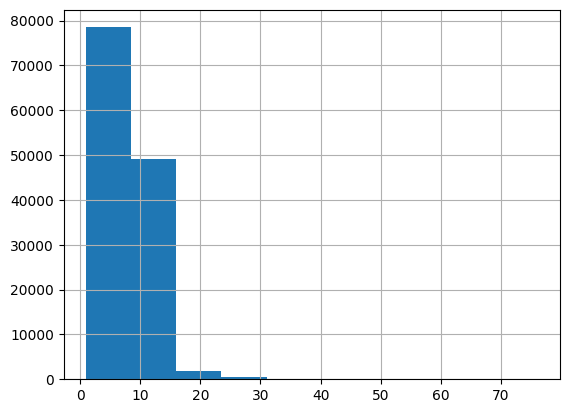

In [ ]:
#Plotting distribution of answer length
squad_v2_train_tokenized_df['answer_len'].hist()

In [ ]:
#Percentage of answers with more than 30 tokens compared to the entire data.
print(f'Percentage of answers with more than 30 tokens: {squad_v2_train_tokenized_df[squad_v2_train_tokenized_df["answer_len"] > 30].shape[0]/squad_v2_train_tokenized_df.shape[0]}')

Percentage of answers with more than 30 tokens: 0.0010589399857273306


In [ ]:
#Print the maximum of each new columns
print(f'Max question length: {squad_v2_train_tokenized_df["question_len"].max()}')
print(f'Max context length: {squad_v2_train_tokenized_df["context_len"].max()}')
print(f'Max answer length: {squad_v2_train_tokenized_df["answer_len"].max()}')
print(f'Max span text length: {squad_v2_train_tokenized_df["span_text_len"].max()}')

Max question length: 61
Max context length: 863
Max answer length: 76
Max span text length: 426


The input data for the model will be [QST]question[EOS][CTX]context[EOS] or [QST]question[EOS][CTX]span_text[EOS] so the maximum length of the input string when only Considering the training set is 928 tokens.

Next we will analyze both validation and testing data sets.

In [ ]:
#Convert validation and test dataset to pandas then concat them
squad_v2_val_tokenized_df = squad_v2_val_tokenized_dataset.to_pandas()
squad_v2_test_tokenized_df = squad_v2_test_tokenized_dataset.to_pandas()
squad_v2_val_test_tokenized_df = pd.concat([squad_v2_val_tokenized_df, squad_v2_test_tokenized_df])
squad_v2_val_test_tokenized_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,question_tokens,question_ids,context_tokens,context_ids,span_text_tokens,span_text_ids,answers_tokens,answers_ids
0,571a52cb4faf5e1900b8a96a,Oxygen,Concentrated O\n2 will allow combustion to pro...,To ensure safety of future space missions Oxyg...,"{'answer_start': [507, 507, 507, 507, 507], 't...",316,559,The fire that killed the Apollo 1 crew in a l...,"[To, Ġensure, Ġsafety, Ġof, Ġfuture, Ġspace, Ġ...","[5731, 6059, 5967, 280, 3155, 2402, 9565, 1796...","[Con, cent, rated, ĠO, Ċ, 2, Ġwill, Ġallow, Ġc...","[9791, 883, 2015, 445, 204, 23, 1093, 1186, 11...","[ĠThe, Ġfire, Ġthat, Ġkilled, Ġthe, ĠApollo, Ġ...","[352, 3422, 363, 3248, 266, 6757, 329, 8233, 2...","[[Ġ1, âģĦ, 3], [Ġ1, âģĦ, 3], [Ġ1, âģĦ, 3], [Ġ1...","[[329, 13393, 24], [329, 13393, 24], [329, 133..."
1,5726a7ecf1498d1400e8e655,European_Union_law,"Today, the Treaty of Lisbon prohibits anti-com...",What does Article 102 of the Treaty of Lisbon ...,"{'answer_start': [528, 528, 532], 'text': [' t...",506,611,Article 102 prohibits the abuse of dominant p...,"[What, Ġdoes, ĠArticle, Ġ102, Ġof, Ġthe, ĠTrea...","[453, 1010, 8249, 25033, 280, 266, 3328, 280, ...","[Today, ,, Ġthe, ĠTreaty, Ġof, ĠLisbon, Ġprohi...","[19267, 17, 266, 3328, 280, 12486, 24627, 2941...","[ĠArticle, Ġ102, Ġprohibits, Ġthe, Ġabuse, Ġof...","[8249, 25033, 24627, 266, 11825, 280, 4376, 22...","[[Ġthe, Ġabuse, Ġof, Ġdominant, Ġposition], [Ġ...","[[266, 11825, 280, 4376, 2271], [266, 11825, 2..."
2,572fdc34a23a5019007fca94,Scottish_Parliament,"For the Conservatives, the main disappointment...",What was the seat of former party leader David...,"{'answer_start': [63, 63, 96], 'text': [' Edin...",0,144,"For the Conservatives, the main disappointment...","[What, Ġwas, Ġthe, Ġseat, Ġof, Ġformer, Ġparty...","[453, 343, 266, 6797, 280, 1662, 2035, 3000, 3...","[For, Ġthe, ĠConservatives, ,, Ġthe, Ġmain, Ġd...","[4485, 266, 16929, 17, 266, 926, 28346, 343, 2...","[For, Ġthe, ĠConservatives, ,, Ġthe, Ġmain, Ġd...","[4485, 266, 16929, 17, 266, 926, 28346, 343, 2...","[[ĠEdinburgh, ĠPent, lands], [ĠEdinburgh, ĠPen...","[[10466, 12981, 1537], [10466, 12981, 1537], [..."
3,5ad264d7d7d075001a429174,Huguenot,Most of the Huguenot congregations (or individ...,In what century was Eleutherian gunpowder mill...,"{'answer_start': [], 'text': ['Apologies, I co...",-1,-1,Couldn't locate relevant sentences.,"[In, Ġwhat, Ġcentury, Ġwas, ĠEle, uther, ian, ...","[649, 663, 776, 343, 9590, 5298, 415, 32710, 1...","[Most, Ġof, Ġthe, ĠHuguenot, Ġcongregations, Ġ...","[6828, 280, 266, 8103, 9011, 353, 283, 3495, 1...","[C, ould, n, 't, Ġlocate, Ġrelevant, Ġsentence...","[40, 578, 83, 2377, 21494, 8904, 10359, 19]","[[Ap, ologies, ,, ĠI, Ġcouldn, 't, Ġfind, Ġthe...","[[21853, 5223, 17, 341, 24077, 2377, 2600, 266..."
4,572fb42904bcaa1900d76c15,Scottish_Parliament,After each election to the Scottish Parliament...,Who is elected to serve as the Presiding Offic...,"{'answer_start': [114, 118, 118], 'text': [' o...",0,285,After each election to the Scottish Parliament...,"[Who, Ġis, Ġelected, Ġto, Ġserve, Ġas, Ġthe, Ġ...","[977, 328, 2986, 298, 3756, 335, 266, 14005, 1...","[After, Ġeach, Ġelection, Ġto, Ġthe, ĠScottish...","[3600, 1180, 2943, 298, 266, 4244, 2716, 17, 4...","[After, Ġeach, Ġelection, Ġto, Ġthe, ĠScottish...","[3600, 1180, 2943, 298, 266, 4244, 2716, 17, 4...","[[Ġone, ĠMSP], [ĠMSP], [ĠMSP]]","[[596, 26239], [26239], [26239]]"


In [ ]:
#Print the shape
print(f'Shape of val and test dataframe: {squad_v2_val_test_tokenized_df.shape}')

Shape of val and test dataframe: (11873, 16)


In [ ]:
#Getting the length of question, context and span_text
squad_v2_val_test_tokenized_df['question_len'] = squad_v2_val_test_tokenized_df['question_tokens'].apply(lambda x: len(x))
squad_v2_val_test_tokenized_df['context_len'] = squad_v2_val_test_tokenized_df['context_tokens'].apply(lambda x: len(x))
squad_v2_val_test_tokenized_df['span_text_len'] = squad_v2_val_test_tokenized_df['span_text_tokens'].apply(lambda x: len(x))
squad_v2_val_test_tokenized_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,question_tokens,question_ids,context_tokens,context_ids,span_text_tokens,span_text_ids,answers_tokens,answers_ids,question_len,context_len,span_text_len
0,571a52cb4faf5e1900b8a96a,Oxygen,Concentrated O\n2 will allow combustion to pro...,To ensure safety of future space missions Oxyg...,"{'answer_start': [507, 507, 507, 507, 507], 't...",316,559,The fire that killed the Apollo 1 crew in a l...,"[To, Ġensure, Ġsafety, Ġof, Ġfuture, Ġspace, Ġ...","[5731, 6059, 5967, 280, 3155, 2402, 9565, 1796...","[Con, cent, rated, ĠO, Ċ, 2, Ġwill, Ġallow, Ġc...","[9791, 883, 2015, 445, 204, 23, 1093, 1186, 11...","[ĠThe, Ġfire, Ġthat, Ġkilled, Ġthe, ĠApollo, Ġ...","[352, 3422, 363, 3248, 266, 6757, 329, 8233, 2...","[[Ġ1, âģĦ, 3], [Ġ1, âģĦ, 3], [Ġ1, âģĦ, 3], [Ġ1...","[[329, 13393, 24], [329, 13393, 24], [329, 133...",20,112,50
1,5726a7ecf1498d1400e8e655,European_Union_law,"Today, the Treaty of Lisbon prohibits anti-com...",What does Article 102 of the Treaty of Lisbon ...,"{'answer_start': [528, 528, 532], 'text': [' t...",506,611,Article 102 prohibits the abuse of dominant p...,"[What, Ġdoes, ĠArticle, Ġ102, Ġof, Ġthe, ĠTrea...","[453, 1010, 8249, 25033, 280, 266, 3328, 280, ...","[Today, ,, Ġthe, ĠTreaty, Ġof, ĠLisbon, Ġprohi...","[19267, 17, 266, 3328, 280, 12486, 24627, 2941...","[ĠArticle, Ġ102, Ġprohibits, Ġthe, Ġabuse, Ġof...","[8249, 25033, 24627, 266, 11825, 280, 4376, 22...","[[Ġthe, Ġabuse, Ġof, Ġdominant, Ġposition], [Ġ...","[[266, 11825, 280, 4376, 2271], [266, 11825, 2...",11,247,17
2,572fdc34a23a5019007fca94,Scottish_Parliament,"For the Conservatives, the main disappointment...",What was the seat of former party leader David...,"{'answer_start': [63, 63, 96], 'text': [' Edin...",0,144,"For the Conservatives, the main disappointment...","[What, Ġwas, Ġthe, Ġseat, Ġof, Ġformer, Ġparty...","[453, 343, 266, 6797, 280, 1662, 2035, 3000, 3...","[For, Ġthe, ĠConservatives, ,, Ġthe, Ġmain, Ġd...","[4485, 266, 16929, 17, 266, 926, 28346, 343, 2...","[For, Ġthe, ĠConservatives, ,, Ġthe, Ġmain, Ġd...","[4485, 266, 16929, 17, 266, 926, 28346, 343, 2...","[[ĠEdinburgh, ĠPent, lands], [ĠEdinburgh, ĠPen...","[[10466, 12981, 1537], [10466, 12981, 1537], [...",13,101,30
3,5ad264d7d7d075001a429174,Huguenot,Most of the Huguenot congregations (or individ...,In what century was Eleutherian gunpowder mill...,"{'answer_start': [], 'text': ['Apologies, I co...",-1,-1,Couldn't locate relevant sentences.,"[In, Ġwhat, Ġcentury, Ġwas, ĠEle, uther, ian, ...","[649, 663, 776, 343, 9590, 5298, 415, 32710, 1...","[Most, Ġof, Ġthe, ĠHuguenot, Ġcongregations, Ġ...","[6828, 280, 266, 8103, 9011, 353, 283, 3495, 1...","[C, ould, n, 't, Ġlocate, Ġrelevant, Ġsentence...","[40, 578, 83, 2377, 21494, 8904, 10359, 19]","[[Ap, ologies, ,, ĠI, Ġcouldn, 't, Ġfind, Ġthe...","[[21853, 5223, 17, 341, 24077, 2377, 2600, 266...",11,117,8
4,572fb42904bcaa1900d76c15,Scottish_Parliament,After each election to the Scottish Parliament...,Who is elected to serve as the Presiding Offic...,"{'answer_start': [114, 118, 118], 'text': [' o...",0,285,After each election to the Scottish Parliament...,"[Who, Ġis, Ġelected, Ġto, Ġserve, Ġas, Ġthe, Ġ...","[977, 328, 2986, 298, 3756, 335, 266, 14005, 1...","[After, Ġeach, Ġelection, Ġto, Ġthe, ĠScottish...","[3600, 1180, 2943, 298, 266, 4244, 2716, 17, 4...","[After, Ġeach, Ġelection, Ġto, Ġthe, ĠScottish...","[3600, 1180, 2943, 298, 266, 4244, 2716, 17, 4...","[[Ġone, ĠMSP], [ĠMSP], [ĠMSP]]","[[596, 26239], [26239], [26239]]",17,179,53


In [ ]:
#Getting the answer len list
squad_v2_val_test_tokenized_df['answer_len_list'] = squad_v2_val_test_tokenized_df['answers_tokens'].apply(lambda x: [len(y) for y in x])
squad_v2_val_test_tokenized_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,question_tokens,question_ids,context_tokens,context_ids,span_text_tokens,span_text_ids,answers_tokens,answers_ids,question_len,context_len,span_text_len,answer_len_list
0,571a52cb4faf5e1900b8a96a,Oxygen,Concentrated O\n2 will allow combustion to pro...,To ensure safety of future space missions Oxyg...,"{'answer_start': [507, 507, 507, 507, 507], 't...",316,559,The fire that killed the Apollo 1 crew in a l...,"[To, Ġensure, Ġsafety, Ġof, Ġfuture, Ġspace, Ġ...","[5731, 6059, 5967, 280, 3155, 2402, 9565, 1796...","[Con, cent, rated, ĠO, Ċ, 2, Ġwill, Ġallow, Ġc...","[9791, 883, 2015, 445, 204, 23, 1093, 1186, 11...","[ĠThe, Ġfire, Ġthat, Ġkilled, Ġthe, ĠApollo, Ġ...","[352, 3422, 363, 3248, 266, 6757, 329, 8233, 2...","[[Ġ1, âģĦ, 3], [Ġ1, âģĦ, 3], [Ġ1, âģĦ, 3], [Ġ1...","[[329, 13393, 24], [329, 13393, 24], [329, 133...",20,112,50,"[3, 3, 3, 3, 5]"
1,5726a7ecf1498d1400e8e655,European_Union_law,"Today, the Treaty of Lisbon prohibits anti-com...",What does Article 102 of the Treaty of Lisbon ...,"{'answer_start': [528, 528, 532], 'text': [' t...",506,611,Article 102 prohibits the abuse of dominant p...,"[What, Ġdoes, ĠArticle, Ġ102, Ġof, Ġthe, ĠTrea...","[453, 1010, 8249, 25033, 280, 266, 3328, 280, ...","[Today, ,, Ġthe, ĠTreaty, Ġof, ĠLisbon, Ġprohi...","[19267, 17, 266, 3328, 280, 12486, 24627, 2941...","[ĠArticle, Ġ102, Ġprohibits, Ġthe, Ġabuse, Ġof...","[8249, 25033, 24627, 266, 11825, 280, 4376, 22...","[[Ġthe, Ġabuse, Ġof, Ġdominant, Ġposition], [Ġ...","[[266, 11825, 280, 4376, 2271], [266, 11825, 2...",11,247,17,"[5, 5, 4]"
2,572fdc34a23a5019007fca94,Scottish_Parliament,"For the Conservatives, the main disappointment...",What was the seat of former party leader David...,"{'answer_start': [63, 63, 96], 'text': [' Edin...",0,144,"For the Conservatives, the main disappointment...","[What, Ġwas, Ġthe, Ġseat, Ġof, Ġformer, Ġparty...","[453, 343, 266, 6797, 280, 1662, 2035, 3000, 3...","[For, Ġthe, ĠConservatives, ,, Ġthe, Ġmain, Ġd...","[4485, 266, 16929, 17, 266, 926, 28346, 343, 2...","[For, Ġthe, ĠConservatives, ,, Ġthe, Ġmain, Ġd...","[4485, 266, 16929, 17, 266, 926, 28346, 343, 2...","[[ĠEdinburgh, ĠPent, lands], [ĠEdinburgh, ĠPen...","[[10466, 12981, 1537], [10466, 12981, 1537], [...",13,101,30,"[3, 3, 3]"
3,5ad264d7d7d075001a429174,Huguenot,Most of the Huguenot congregations (or individ...,In what century was Eleutherian gunpowder mill...,"{'answer_start': [], 'text': ['Apologies, I co...",-1,-1,Couldn't locate relevant sentences.,"[In, Ġwhat, Ġcentury, Ġwas, ĠEle, uther, ian, ...","[649, 663, 776, 343, 9590, 5298, 415, 32710, 1...","[Most, Ġof, Ġthe, ĠHuguenot, Ġcongregations, Ġ...","[6828, 280, 266, 8103, 9011, 353, 283, 3495, 1...","[C, ould, n, 't, Ġlocate, Ġrelevant, Ġsentence...","[40, 578, 83, 2377, 21494, 8904, 10359, 19]","[[Ap, ologies, ,, ĠI, Ġcouldn, 't, Ġfind, Ġthe...","[[21853, 5223, 17, 341, 24077, 2377, 2600, 266...",11,117,8,[10]
4,572fb42904bcaa1900d76c15,Scottish_Parliament,After each election to the Scottish Parliament...,Who is elected to serve as the Presiding Offic...,"{'answer_start': [114, 118, 118], 'text': [' o...",0,285,After each election to the Scottish Parliament...,"[Who, Ġis, Ġelected, Ġto, Ġserve, Ġas, Ġthe, Ġ...","[977, 328, 2986, 298, 3756, 335, 266, 14005, 1...","[After, Ġeach, Ġelection, Ġto, Ġthe, ĠScottish...","[3600, 1180, 2943, 298, 266, 4244, 2716, 17, 4...","[After, Ġeach, Ġelection, Ġto, Ġthe, ĠScottish...","[3600, 1180, 2943, 298, 266, 4244, 2716, 17, 4...","[[Ġone, ĠMSP], [ĠMSP], [ĠMSP]]","[[596, 26239], [26239], [26239]]",17,179,53,"[2, 1, 1]"


In [ ]:
#The answer len will be the maximum answer len of each answer len list
squad_v2_val_test_tokenized_df['answer_len'] = squad_v2_val_test_tokenized_df['answer_len_list'].apply(lambda x: max(x))
squad_v2_val_test_tokenized_df.head()

,id,title,context,question,answers,span_start,span_end,span_text,question_tokens,question_ids,...,context_ids,span_text_tokens,span_text_ids,answers_tokens,answers_ids,question_len,context_len,span_text_len,answer_len_list,answer_len
0,571a52cb4faf5e1900b8a96a,Oxygen,Concentrated O\n2 will allow combustion to pro...,To ensure safety of future space missions Oxyg...,"{'answer_start': [507, 507, 507, 507, 507], 't...",316,559,The fire that killed the Apollo 1 crew in a l...,"[To, Ġensure, Ġsafety, Ġof, Ġfuture, Ġspace, Ġ...","[5731, 6059, 5967, 280, 3155, 2402, 9565, 1796...",...,"[9791, 883, 2015, 445, 204, 23, 1093, 1186, 11...","[ĠThe, Ġfire, Ġthat, Ġkilled, Ġthe, ĠApollo, Ġ...","[352, 3422, 363, 3248, 266, 6757, 329, 8233, 2...","[[Ġ1, âģĦ, 3], [Ġ1, âģĦ, 3], [Ġ1, âģĦ, 3], [Ġ1...","[[329, 13393, 24], [329, 13393, 24], [329, 133...",20,112,50,"[3, 3, 3, 3, 5]",5
1,5726a7ecf1498d1400e8e655,European_Union_law,"Today, the Treaty of Lisbon prohibits anti-com...",What does Article 102 of the Treaty of Lisbon ...,"{'answer_start': [528, 528, 532], 'text': [' t...",506,611,Article 102 prohibits the abuse of dominant p...,"[What, Ġdoes, ĠArticle, Ġ102, Ġof, Ġthe, ĠTrea...","[453, 1010, 8249, 25033, 280, 266, 3328, 280, ...",...,"[19267, 17, 266, 3328, 280, 12486, 24627, 2941...","[ĠArticle, Ġ102, Ġprohibits, Ġthe, Ġabuse, Ġof...","[8249, 25033, 24627, 266, 11825, 280, 4376, 22...","[[Ġthe, Ġabuse, Ġof, Ġdominant, Ġposition], [Ġ...","[[266, 11825, 280, 4376, 2271], [266, 11825, 2...",11,247,17,"[5, 5, 4]",5
2,572fdc34a23a5019007fca94,Scottish_Parliament,"For the Conservatives, the main disappointment...",What was the seat of former party leader David...,"{'answer_start': [63, 63, 96], 'text': [' Edin...",0,144,"For the Conservatives, the main disappointment...","[What, Ġwas, Ġthe, Ġseat, Ġof, Ġformer, Ġparty...","[453, 343, 266, 6797, 280, 1662, 2035, 3000, 3...",...,"[4485, 266, 16929, 17, 266, 926, 28346, 343, 2...","[For, Ġthe, ĠConservatives, ,, Ġthe, Ġmain, Ġd...","[4485, 266, 16929, 17, 266, 926, 28346, 343, 2...","[[ĠEdinburgh, ĠPent, lands], [ĠEdinburgh, ĠPen...","[[10466, 12981, 1537], [10466, 12981, 1537], [...",13,101,30,"[3, 3, 3]",3
3,5ad264d7d7d075001a429174,Huguenot,Most of the Huguenot congregations (or individ...,In what century was Eleutherian gunpowder mill...,"{'answer_start': [], 'text': ['Apologies, I co...",-1,-1,Couldn't locate relevant sentences.,"[In, Ġwhat, Ġcentury, Ġwas, ĠEle, uther, ian, ...","[649, 663, 776, 343, 9590, 5298, 415, 32710, 1...",...,"[6828, 280, 266, 8103, 9011, 353, 283, 3495, 1...","[C, ould, n, 't, Ġlocate, Ġrelevant, Ġsentence...","[40, 578, 83, 2377, 21494, 8904, 10359, 19]","[[Ap, ologies, ,, ĠI, Ġcouldn, 't, Ġfind, Ġthe...","[[21853, 5223, 17, 341, 24077, 2377, 2600, 266...",11,117,8,[10],10
4,572fb42904bcaa1900d76c15,Scottish_Parliament,After each election to the Scottish Parliament...,Who is elected to serve as the Presiding Offic...,"{'answer_start': [114, 118, 118], 'text': [' o...",0,285,After each election to the Scottish Parliament...,"[Who, Ġis, Ġelected, Ġto, Ġserve, Ġas, Ġthe, Ġ...","[977, 328, 2986, 298, 3756, 335, 266, 14005, 1...",...,"[3600, 1180, 2943, 298, 266, 4244, 2716, 17, 4...","[After, Ġeach, Ġelection, Ġto, Ġthe, ĠScottish...","[3600, 1180, 2943, 298, 266, 4244, 2716, 17, 4...","[[Ġone, ĠMSP], [ĠMSP], [ĠMSP]]","[[596, 26239], [26239], [26239]]",17,179,53,"[2, 1, 1]",2


In [ ]:
#Print the maximum of question, context, span text and answer length
print(f'Max question length: {squad_v2_val_test_tokenized_df["question_len"].max()}')
print(f'Max context length: {squad_v2_val_test_tokenized_df["context_len"].max()}')
print(f'Max span text length: {squad_v2_val_test_tokenized_df["span_text_len"].max()}')
print(f'Max answer length: {squad_v2_val_test_tokenized_df["answer_len"].max()}')

Max question length: 37
Max context length: 768
Max span text length: 605
Max answer length: 38


For both validation and testing datasets, the maximum length for the input string is 809. So we can decide that the maximum length for the model's input string will be 928 tokens.

For the answer the maximum number of tokens for a string will be 76 and a special symbol can be added to 77.

# **III. Model**

## **1. Transformer**

In [ ]:
#Input Embedding Layers
class InputEmbedding(nn.Module):
  """
    Transformer Input Embedding

    params:
      d_model: int -> dimension of the embedding (hidden size)
      vocab_size: int -> vocabulary size (number of classes)
    output:
      tensor of shape (batch_size, seq_len, d_model) -> embedding of the input sequence
  """
  def __init__(self, d_model: int, vocab_size: int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    #In the paper, the authors state that they multiply the embedding with square root of d model for final result
    return self.embedding(x) * math.sqrt(self.d_model)

In [ ]:
#Positional Embedding
class PositionalEmbedding(nn.Module):
  """
    Transformer Positional Embedding

    params:
      d_model: int -> dimension of the embedding (hidden size)
      seq_len: int -> max sequence input length
      dropout: float -> dropout rate. Default: 0.1
    output:
      tensor of shape (batch_size, seq_len, d_model) -> positional embedding of the input sequence
  """
  def __init__(self, d_model: int, seq_len: int, dropout: float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    """#The positional embedding tensors will have the shape of (seq_len, d_model)
    ##Initial an zeros tensors with shape (seq_len, d_model)
    pe = torch.zeros(seq_len, d_model)

    #Positional Embedding of Transformer using sin and cosine on token postion
    ##First, we initialize a position sequence (seq_len, 1)
    positions = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

    #div_term of shape (,d_model)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

    #Apply sin to even positions
    pe[:, 0::2] = torch.sin(positions * div_term)
    #Apply cos to odd positions
    pe[:, 1::2] = torch.cos(positions * div_term)

    #unsqueeze for handling batch input
    pe = pe.unsqueeze(0)

    #Register to buffer so we can save it with the model state later
    self.register_buffer('pe', pe)"""

  def forward(self, x):
    pe = self.get_pe(x)
    x = x + (pe[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

  def get_pe(self, x):
    #The positional embedding tensors will have the shape of (seq_len, d_model)
    ##Initial an zeros tensors with shape (seq_len, d_model)
    seq_len = x.shape[1]
    pe = torch.zeros(seq_len, d_model)

    #Positional Embedding of Transformer using sin and cosine on token postion
    ##First, we initialize a position sequence (seq_len, 1)
    positions = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

    #div_term of shape (,d_model)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

    #Apply sin to even positions
    pe[:, 0::2] = torch.sin(positions * div_term)
    #Apply cos to odd positions
    pe[:, 1::2] = torch.cos(positions * div_term)

    #unsqueeze for handling batch input
    pe = pe.unsqueeze(0)

    pe = pe.to(DEVICE)
    return pe

In [ ]:
#Layer Normalization
class LayerNormalization(nn.Module):
  """
    Transformer Layer Normalization

    params:
      eps: float -> epsilon for the normalization
    output:
      tensor of shape (batch_size, seq_len, d_model) -> normalized output
  """
  def __init__(self, eps: float = 1e-5):
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1)) #Multiplied
    self.beta = nn.Parameter(torch.zeros(1)) #Added

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.beta

In [ ]:
#Feed Forward Sub Layer
class FeedForward(nn.Module):
  """
    Transformer Encoder and Decoder Feed Forward Sub Layer

    params:
      d_model: int -> dimension of the embedding (hidden size)
      d_ff: int -> dimension of the feed forward layer
      dropout: float -> dropout rate. Default: 0.1
    output:
      tensor of shape (batch_size, seq_len, d_model) -> feed forward output
  """
  def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff) #In the original paper, W1 and b1 parameter
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model) #In the original paper, W2 and b2 parameter
    self.activation = nn.ReLU()

  def forward(self, x):
    #Input shape x(batch_size, seq_len, d_model)
    return self.linear_2(self.dropout(self.activation(self.linear_1(x)))) #(batch_size, seq_len, d_model)

In [ ]:
#MultiHeadAttention sub-layer
class MultiHeadAttention(nn.Module):
  """
    Transformer Encoder and Decoder MultiHeadAttention Sub Layer
    params:
      d_model: int -> dimension of the embedding (hidden size)
      n_heads: int -> number of heads
      dropout: float -> dropout rate. Default: 0.1
    output:
      tensor of shape (batch_size, seq_len, d_model) -> multihead attention output
  """
  def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.d_k = d_model // n_heads
    self.Wq = nn.Linear(d_model, d_model) #Query matrix
    self.Wk = nn.Linear(d_model, d_model) #Key matrix
    self.Wv = nn.Linear(d_model, d_model) #Value matrix

    self.Wout = nn.Linear(d_model, d_model) #Output matrix
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(q, k, v, mask = None, dropout: nn.Dropout = None):
    """
      Calculate the attention weights
      params:
        q: tensor of shape (batch_size, n_heads, seq_len_q, d_k)
        k: tensor of shape (batch_size, n_heads, seq_len_k, d_k)
        v: tensor of shape (batch_size, n_heads, seq_len_v, d_k)
        mask: tensor of shape (batch_size, seq_len_q, seq_len_k)
        dropout: nn.Dropout object
    """
    d_k = q.shape[-1]
    attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(d_k)

    #Applying the mask if defined
    if mask is not None:
      attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

    #Softmax
    attn_scores = attn_scores.softmax(dim = -1) #(batch_size, n_heads, seq_len, seq_len)

    #Apply dropout
    if dropout is not None:
      attn_scores = dropout(attn_scores)

    return (attn_scores @ v), attn_scores

  def forward(self, q, k, v, mask = None):
    query = self.Wq(q)
    key = self.Wk(k)
    value = self.Wv(v)

    #(batch_size, seq_len, d_model) ----> (batch_size, n_heads, seq_len, d_k)
    query = query.view(query.shape[0], query.shape[1], self.n_heads, self.d_k).transpose(1, 2)
    key = key.view(key.shape[0], key.shape[1], self.n_heads, self.d_k).transpose(1, 2)
    value = value.view(value.shape[0], value.shape[1], self.n_heads, self.d_k).transpose(1, 2)

    #Apply attention
    x, attn_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)

    #(batch_size, n_heads, seq_len, d_k) ----> (batch_size, seq_len, n_heads, d_k) ----> (batch_size, seq_len, d_model)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.n_heads * self.d_k)

    return self.Wout(x)

We will change a bit and apply layernorm before other sublayers according to the following two articles, it will help the model be more stable. However, we still leave it as the option to appy first or later.

In [ ]:
##Encoder Layer
class EncoderLayer(nn.Module):
  def __init__(self, d_model:int, nhead:int, dim_feedforward:int=2048, dropout:float=0.1,
               layer_norm_eps=1e-05, norm_first:bool=True):
    """
    Transformer Encoder Block
    params:
      d_model: int -> dimension of the embedding (hidden size)
      nhead: int -> number of multi-head attention heads
      dim_feedforward: int -> dimension of the feed forward layer
      dropout: float -> dropout rate. Default: 0.1
      layer_norm_eps: float -> epsilon for layer normalization. Default: 1e-05
      norm_first: bool -> whether to apply layer normalization first. Default: True
    """
    super().__init__()
    self.self_attention = MultiHeadAttention(d_model, nhead, dropout)
    self.layer_norm_1 = LayerNormalization(layer_norm_eps)
    self.feedforward = FeedForward(d_model, dim_feedforward, dropout)
    self.layer_norm_2 = LayerNormalization(layer_norm_eps)
    self.dropout = nn.Dropout(dropout)
    self.norm_first = norm_first

  def forward(self, x, mask = None):
    if self.norm_first:
      x = self.layer_norm_1(x)
      x = self.self_attention(x, x, x, mask) + x #Residual connection
      x = self.layer_norm_2(x)
      x = self.feedforward(x) + x #Residual connection
    else:
      x = self.self_attention(x, x, x, mask)
      x = self.layer_norm_1(x) + x #Residual connection
      x = self.feedforward(x)
      x = self.layer_norm_2(x) + x #Residual connection
    return x

In [ ]:
#Encoder Block
class Encoder(nn.Module):
  def __init__(self, encoder_layer:EncoderLayer, num_layers:int, norm:LayerNormalization=None):
    """
    Transformer Encoder
    params:
      encoder_layer: EncoderLayer -> encoder layer
      num_layers: int -> number of encoder layers
      norm: LayerNormalization -> layer normalization if want to apply one more layer norm. Default: None
    """
    super().__init__()
    self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
    self.norm = norm

  def forward(self, x, mask = None):
    for layer in self.layers:
      x = layer(x, mask)
    if self.norm is not None:
      x = self.norm(x)
    return x

In [ ]:
##Decoder Layer
class DecoderLayer(nn.Module):
  def __init__(self,d_model:int, nhead:int, dim_feedforward:int=2048, dropout:float=0.1,
               layer_norm_eps:float=1e-05, norm_first:bool=True):
    """
    Transformer Decoder Block
    params:
      d_model: int -> dimension of the embedding (hidden size)
      nhead: int -> number of multi-head attention heads
      dim_feedforward: int -> dimension of the feed forward layer
      dropout: float -> dropout rate. Default: 0.1
      layer_norm_eps: float -> epsilon for layer normalization. Default: 1e-05
      norm_first: bool -> whether to apply layer normalization first. Default: True
    """
    super().__init__()
    self.self_attention = MultiHeadAttention(d_model, nhead, dropout)
    self.layer_norm_1 = LayerNormalization(layer_norm_eps)
    self.cross_attention = MultiHeadAttention(d_model, nhead, dropout)
    self.layer_norm_2 = LayerNormalization(layer_norm_eps)
    self.feedforward = FeedForward(d_model, dim_feedforward, dropout)
    self.layer_norm_3 = LayerNormalization(layer_norm_eps)
    self.norm_first = norm_first

  def forward(self, x, encoder_out, src_mask = None, tgt_mask = None):
    if self.norm_first:
      x = self.layer_norm_1(x)
      x = self.self_attention(x, x, x, tgt_mask) + x #Residual Connection
      x = self.layer_norm_2(x)
      x = self.cross_attention(x, encoder_out, encoder_out, src_mask) + x #Residual Connection
      x = self.layer_norm_3(x)
      x = self.feedforward(x) + x #Residual Connection
    else:
      x = self.self_attention(x, x, x, tgt_mask)
      x = self.layer_norm_1(x) + x #Residual Connection
      x = self.cross_attention(x, encoder_out, encoder_out, src_mask)
      x = self.layer_norm_2(x) + x #Residual Connection
      x = self.feedforward(x)
      x = self.layer_norm_3(x) + x #Residual Connection
    return x

In [ ]:
##Decoder Block
class Decoder(nn.Module):
  def __init__(self, decoder_layer:DecoderLayer, num_layers:int, norm:LayerNormalization=None):
    super().__init__()
    self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])
    self.norm = norm

  def forward(self, x, encoder_out, src_mask = None, tgt_mask = None):
    for layer in self.layers:
      x = layer(x, encoder_out, src_mask, tgt_mask)
    if self.norm is not None:
      x = self.norm(x)
    return x

In [ ]:
##Linear Layer
class LinearLayer(nn.Module):
  def __init__(self, d_model:int, vocab_size:int, use_log_softmax:bool=False):
    """
    Linear Layer
    params:
      d_model: int -> dimension of the embedding (hidden size)
      vocab_size: int -> vocabulary size
      use_log_softmax: bool -> whether to use log softmax. Default: False if train with cross entropy loss
    """
    super().__init__()
    self.linear = nn.Linear(d_model, vocab_size)
    self.use_log_softmax = use_log_softmax

  def forward(self, x):
    #(batch_size, seq_len, d_model) ----> (batch_size, seq_len, vocab_size)
    x = self.linear(x)
    if self.use_log_softmax:
      x = F.log_softmax(x, dim=-1)
    return x

In [ ]:
##Transformer
class Transformer(nn.Module):
  def __init__(self, src_seq_len:int, tgt_seq_len:int, src_vocab_size:int, tgt_vocab_size:int,
               d_model:int=512, nhead:int=8, num_encoder_layers:int=6,num_decoder_layers:int=6,
               dim_feedforward:int=2048, dropout:float=0.1,layer_norm_eps=1e-05,
               norm_first=True, device:str='cuda', use_log_softmax:bool=False):
    super().__init__()
    #Creating embedding layers
    self.src_embed = InputEmbedding(d_model, src_vocab_size)
    self.tgt_embed = InputEmbedding(d_model, tgt_vocab_size)

    #Creating postional embedding layers
    self.src_pos_embed = PositionalEmbedding(d_model, src_seq_len, dropout)
    self.tgt_pos_embed = PositionalEmbedding(d_model, tgt_seq_len, dropout)

    #Creating encoder layer and block with n of them
    self.encoder_layer = EncoderLayer(d_model, nhead, dim_feedforward, dropout, layer_norm_eps, norm_first)
    self.encoder = Encoder(self.encoder_layer, num_encoder_layers)

    #Creating decoder layer and block with m of them
    self.decoder_layer = DecoderLayer(d_model, nhead, dim_feedforward, dropout, layer_norm_eps, norm_first)
    self.decoder = Decoder(self.decoder_layer, num_decoder_layers)

    #Final Projection linear layer
    self.linear = LinearLayer(d_model, tgt_vocab_size, use_log_softmax)

    self.d_model = d_model
    self.device = device

  def encode(self, src, token_type_ids = None, src_mask = None):
    src = self.src_embed(src)
    if token_type_ids is not None:
      token_type_ids = self.process_token_type_ids(token_type_ids)
      src = src + token_type_ids
    src = self.src_pos_embed(src)
    return self.encoder(src, src_mask)

  def decode(self, tgt, encoder_out, src_mask = None, tgt_mask = None):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos_embed(tgt)
    return self.decoder(tgt, encoder_out, src_mask, tgt_mask)

  def linear_forward(self, x):
    return self.linear(x)

  def init_weights(self):
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def process_token_type_ids(self, token_type_ids):
    """
    token_type_ids: (batch_size, seq_len)
    params:
      token_type_ids: list of int -> token type ids
    output:
      token_type_ids: (batch_size, seq_len, d_model)
    """
    new_token_type_ids = torch.empty(token_type_ids.size(0), token_type_ids.size(1), self.d_model, device = self.device)
    for i in range(token_type_ids.size(0)):
      temp_tensor = token_type_ids[i].repeat(self.d_model, 1)
      temp_tensor = temp_tensor.resize(token_type_ids.size(1), self.d_model)
      new_token_type_ids[i] = temp_tensor
      #new_token_type_ids[i] = token_type_ids[i].repeat(self.d_model, 1).resize(token_type_ids.size(1), self.d_model)
    return new_token_type_ids

  def forward(self, src, tgt, token_type_ids = None, src_mask = None, tgt_mask = None):
    encoder_out = self.encode(src, token_type_ids, src_mask)
    decoder_out = self.decode(tgt, encoder_out, src_mask, tgt_mask)
    return self.linear(decoder_out)

## **2. Span Text Transformer**

In [ ]:
#Input Embedding Layers
class InputEmbedding(nn.Module):
  """
    Transformer Input Embedding

    params:
      d_model: int -> dimension of the embedding (hidden size)
      vocab_size: int -> vocabulary size (number of classes)
    output:
      tensor of shape (batch_size, seq_len, d_model) -> embedding of the input sequence
  """
  def __init__(self, d_model: int, vocab_size: int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    #In the paper, the authors state that they multiply the embedding with square root of d model for final result
    return self.embedding(x) * math.sqrt(self.d_model)

In [ ]:
#Positional Embedding
class PositionalEmbedding(nn.Module):
  """
    Transformer Positional Embedding

    params:
      d_model: int -> dimension of the embedding (hidden size)
      seq_len: int -> max sequence input length
      dropout: float -> dropout rate. Default: 0.1
    output:
      tensor of shape (batch_size, seq_len, d_model) -> positional embedding of the input sequence
  """
  def __init__(self, d_model: int, seq_len: int, dropout: float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    """#The positional embedding tensors will have the shape of (seq_len, d_model)
    ##Initial an zeros tensors with shape (seq_len, d_model)
    pe = torch.zeros(seq_len, d_model)

    #Positional Embedding of Transformer using sin and cosine on token postion
    ##First, we initialize a position sequence (seq_len, 1)
    positions = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

    #div_term of shape (,d_model)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

    #Apply sin to even positions
    pe[:, 0::2] = torch.sin(positions * div_term)
    #Apply cos to odd positions
    pe[:, 1::2] = torch.cos(positions * div_term)

    #unsqueeze for handling batch input
    pe = pe.unsqueeze(0)

    #Register to buffer so we can save it with the model state later
    self.register_buffer('pe', pe)"""

  def forward(self, x):
    pe = self.get_pe(x)
    x = x + (pe[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

  def get_pe(self, x):
    #The positional embedding tensors will have the shape of (seq_len, d_model)
    ##Initial an zeros tensors with shape (seq_len, d_model)
    seq_len = x.shape[1]
    pe = torch.zeros(seq_len, d_model)

    #Positional Embedding of Transformer using sin and cosine on token postion
    ##First, we initialize a position sequence (seq_len, 1)
    positions = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

    #div_term of shape (,d_model)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

    #Apply sin to even positions
    pe[:, 0::2] = torch.sin(positions * div_term)
    #Apply cos to odd positions
    pe[:, 1::2] = torch.cos(positions * div_term)

    #unsqueeze for handling batch input
    pe = pe.unsqueeze(0)

    pe = pe.to(DEVICE)
    return pe

In [ ]:
#Layer Normalization
class LayerNormalization(nn.Module):
  """
    Transformer Layer Normalization

    params:
      eps: float -> epsilon for the normalization
    output:
      tensor of shape (batch_size, seq_len, d_model) -> normalized output
  """
  def __init__(self, eps: float = 1e-5):
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1)) #Multiplied
    self.beta = nn.Parameter(torch.zeros(1)) #Added

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.beta

In [ ]:
#Feed Forward Sub Layer
class FeedForward(nn.Module):
  """
    Transformer Encoder and Decoder Feed Forward Sub Layer

    params:
      d_model: int -> dimension of the embedding (hidden size)
      d_ff: int -> dimension of the feed forward layer
      dropout: float -> dropout rate. Default: 0.1
    output:
      tensor of shape (batch_size, seq_len, d_model) -> feed forward output
  """
  def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff) #In the original paper, W1 and b1 parameter
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model) #In the original paper, W2 and b2 parameter
    self.activation = nn.ReLU()

  def forward(self, x):
    #Input shape x(batch_size, seq_len, d_model)
    return self.linear_2(self.dropout(self.activation(self.linear_1(x)))) #(batch_size, seq_len, d_model)

In [ ]:
#MultiHeadAttention sub-layer
class MultiHeadAttention(nn.Module):
  """
    Transformer Encoder and Decoder MultiHeadAttention Sub Layer
    params:
      d_model: int -> dimension of the embedding (hidden size)
      n_heads: int -> number of heads
      dropout: float -> dropout rate. Default: 0.1
    output:
      tensor of shape (batch_size, seq_len, d_model) -> multihead attention output
  """
  def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.d_k = d_model // n_heads
    self.Wq = nn.Linear(d_model, d_model) #Query matrix
    self.Wk = nn.Linear(d_model, d_model) #Key matrix
    self.Wv = nn.Linear(d_model, d_model) #Value matrix

    self.Wout = nn.Linear(d_model, d_model) #Output matrix
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(q, k, v, mask = None, dropout: nn.Dropout = None):
    """
      Calculate the attention weights
      params:
        q: tensor of shape (batch_size, n_heads, seq_len_q, d_k)
        k: tensor of shape (batch_size, n_heads, seq_len_k, d_k)
        v: tensor of shape (batch_size, n_heads, seq_len_v, d_k)
        mask: tensor of shape (batch_size, seq_len_q, seq_len_k)
        dropout: nn.Dropout object
    """
    d_k = q.shape[-1]
    attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(d_k)

    #Applying the mask if defined
    if mask is not None:
      attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

    #Softmax
    attn_scores = attn_scores.softmax(dim = -1) #(batch_size, n_heads, seq_len, seq_len)

    #Apply dropout
    if dropout is not None:
      attn_scores = dropout(attn_scores)

    return (attn_scores @ v), attn_scores

  def forward(self, q, k, v, mask = None):
    query = self.Wq(q)
    key = self.Wk(k)
    value = self.Wv(v)

    #(batch_size, seq_len, d_model) ----> (batch_size, n_heads, seq_len, d_k)
    query = query.view(query.shape[0], query.shape[1], self.n_heads, self.d_k).transpose(1, 2)
    key = key.view(key.shape[0], key.shape[1], self.n_heads, self.d_k).transpose(1, 2)
    value = value.view(value.shape[0], value.shape[1], self.n_heads, self.d_k).transpose(1, 2)

    #Apply attention
    x, attn_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)

    #(batch_size, n_heads, seq_len, d_k) ----> (batch_size, seq_len, n_heads, d_k) ----> (batch_size, seq_len, d_model)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.n_heads * self.d_k)

    return self.Wout(x)

We will change a bit and apply layernorm before other sublayers according to the following two articles, it will help the model be more stable. However, we still leave it as the option to appy first or later.

In [ ]:
##Encoder Layer
class EncoderLayer(nn.Module):
  def __init__(self, d_model:int, nhead:int, dim_feedforward:int=2048, dropout:float=0.1,
               layer_norm_eps=1e-05, norm_first:bool=True):
    """
    Transformer Encoder Block
    params:
      d_model: int -> dimension of the embedding (hidden size)
      nhead: int -> number of multi-head attention heads
      dim_feedforward: int -> dimension of the feed forward layer
      dropout: float -> dropout rate. Default: 0.1
      layer_norm_eps: float -> epsilon for layer normalization. Default: 1e-05
      norm_first: bool -> whether to apply layer normalization first. Default: True
    """
    super().__init__()
    self.self_attention = MultiHeadAttention(d_model, nhead, dropout)
    self.layer_norm_1 = LayerNormalization(layer_norm_eps)
    self.feedforward = FeedForward(d_model, dim_feedforward, dropout)
    self.layer_norm_2 = LayerNormalization(layer_norm_eps)
    self.dropout = nn.Dropout(dropout)
    self.norm_first = norm_first

  def forward(self, x, mask = None):
    if self.norm_first:
      x = self.layer_norm_1(x)
      x = self.self_attention(x, x, x, mask) + x #Residual connection
      x = self.layer_norm_2(x)
      x = self.feedforward(x) + x #Residual connection
    else:
      x = self.self_attention(x, x, x, mask)
      x = self.layer_norm_1(x) + x #Residual connection
      x = self.feedforward(x)
      x = self.layer_norm_2(x) + x #Residual connection
    return x

In [ ]:
#Encoder Block
class Encoder(nn.Module):
  def __init__(self, encoder_layer:EncoderLayer, num_layers:int, norm:LayerNormalization=None):
    """
    Transformer Encoder
    params:
      encoder_layer: EncoderLayer -> encoder layer
      num_layers: int -> number of encoder layers
      norm: LayerNormalization -> layer normalization if want to apply one more layer norm. Default: None
    """
    super().__init__()
    self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
    self.norm = norm

  def forward(self, x, mask = None):
    for layer in self.layers:
      x = layer(x, mask)
    if self.norm is not None:
      x = self.norm(x)
    return x

In [ ]:
##Decoder Layer
class DecoderLayer(nn.Module):
  def __init__(self,d_model:int, nhead:int, dim_feedforward:int=2048, dropout:float=0.1,
               layer_norm_eps:float=1e-05, norm_first:bool=True):
    """
    Transformer Decoder Block
    params:
      d_model: int -> dimension of the embedding (hidden size)
      nhead: int -> number of multi-head attention heads
      dim_feedforward: int -> dimension of the feed forward layer
      dropout: float -> dropout rate. Default: 0.1
      layer_norm_eps: float -> epsilon for layer normalization. Default: 1e-05
      norm_first: bool -> whether to apply layer normalization first. Default: True
    """
    super().__init__()
    self.self_attention = MultiHeadAttention(d_model, nhead, dropout)
    self.layer_norm_1 = LayerNormalization(layer_norm_eps)
    self.cross_attention = MultiHeadAttention(d_model, nhead, dropout)
    self.layer_norm_2 = LayerNormalization(layer_norm_eps)
    self.feedforward = FeedForward(d_model, dim_feedforward, dropout)
    self.layer_norm_3 = LayerNormalization(layer_norm_eps)
    self.norm_first = norm_first

  def forward(self, x, encoder_out, src_mask = None, tgt_mask = None):
    if self.norm_first:
      x = self.layer_norm_1(x)
      x = self.self_attention(x, x, x, tgt_mask) + x #Residual Connection
      x = self.layer_norm_2(x)
      x = self.cross_attention(x, encoder_out, encoder_out, src_mask) + x #Residual Connection
      x = self.layer_norm_3(x)
      x = self.feedforward(x) + x #Residual Connection
    else:
      x = self.self_attention(x, x, x, tgt_mask)
      x = self.layer_norm_1(x) + x #Residual Connection
      x = self.cross_attention(x, encoder_out, encoder_out, src_mask)
      x = self.layer_norm_2(x) + x #Residual Connection
      x = self.feedforward(x)
      x = self.layer_norm_3(x) + x #Residual Connection
    return x

In [ ]:
##Decoder Block
class Decoder(nn.Module):
  def __init__(self, decoder_layer:DecoderLayer, num_layers:int, norm:LayerNormalization=None):
    super().__init__()
    self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])
    self.norm = norm

  def forward(self, x, encoder_out, src_mask = None, tgt_mask = None):
    for layer in self.layers:
      x = layer(x, encoder_out, src_mask, tgt_mask)
    if self.norm is not None:
      x = self.norm(x)
    return x

In [ ]:
##Linear Layer
class LinearLayer(nn.Module):
  def __init__(self, d_model:int, vocab_size:int, use_log_softmax:bool=False):
    """
    Linear Layer
    params:
      d_model: int -> dimension of the embedding (hidden size)
      vocab_size: int -> vocabulary size
      use_log_softmax: bool -> whether to use log softmax. Default: False if train with cross entropy loss
    """
    super().__init__()
    self.linear = nn.Linear(d_model, vocab_size)
    self.use_log_softmax = use_log_softmax

  def forward(self, x):
    #(batch_size, seq_len, d_model) ----> (batch_size, seq_len, vocab_size)
    x = self.linear(x)
    if self.use_log_softmax:
      x = F.log_softmax(x, dim=-1)
    return x

In [ ]:
##Transformer
class SpanTextTransformer(nn.Module):
  def __init__(self, src_seq_len:int, tgt_seq_len:int, src_vocab_size:int, tgt_vocab_size:int,
               d_model:int=512, nhead:int=8, num_encoder_layers:int=6,num_decoder_layers:int=6,
               dim_feedforward:int=2048, dropout:float=0.1,layer_norm_eps=1e-05,
               norm_first=True, device:str='cuda', use_log_softmax:bool=False):
    super().__init__()
    #Creating embedding layers
    self.src_embed = InputEmbedding(d_model, src_vocab_size)
    self.tgt_embed = InputEmbedding(d_model, tgt_vocab_size)

    #Creating postional embedding layers
    self.src_pos_embed = PositionalEmbedding(d_model, src_seq_len, dropout)
    self.tgt_pos_embed = PositionalEmbedding(d_model, tgt_seq_len, dropout)

    #Creating encoder layer and block with n of them
    self.encoder_layer = EncoderLayer(d_model, nhead, dim_feedforward, dropout, layer_norm_eps, norm_first)
    self.encoder_1 = Encoder(self.encoder_layer, num_encoder_layers)
    self.encoder_2 = Encoder(self.encoder_layer, num_encoder_layers)

    #Creating decoder layer and block with m of them
    self.decoder_layer = DecoderLayer(d_model, nhead, dim_feedforward, dropout, layer_norm_eps, norm_first)
    self.decoder = Decoder(self.decoder_layer, num_decoder_layers)

    #Final Projection linear layer
    self.span_text_linear = LinearLayer(d_model, 4, use_log_softmax)
    self.linear = LinearLayer(d_model, tgt_vocab_size, use_log_softmax)

    self.d_model = d_model
    self.device = device

  def encode(self, src, token_type_ids = None, src_mask = None):
    src = self.src_embed(src)
    if token_type_ids is not None:
      token_type_ids = self.process_token_type_ids(token_type_ids)
      src = src + token_type_ids
    src = self.src_pos_embed(src)
    return self.encoder_2(src, src_mask)

  def span_text_encode(self, src, token_type_ids = None, src_mask = None):
    src = self.src_embed(src)
    if token_type_ids is not None:
      token_type_ids = self.process_token_type_ids(token_type_ids)
      src = src + token_type_ids
    src = self.src_pos_embed(src)
    return self.encoder_1(src, src_mask)

  def decode(self, tgt, encoder_out, src_mask = None, tgt_mask = None):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos_embed(tgt)
    return self.decoder(tgt, encoder_out, src_mask, tgt_mask)

  def linear_forward(self, x):
    return self.linear(x)

  def span_text_linear_forward(self, x):
    return self.span_text_linear(x)

  def init_weights(self):
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def process_token_type_ids(self, token_type_ids):
    """
    token_type_ids: (batch_size, seq_len)
    params:
      token_type_ids: list of int -> token type ids
    output:
      token_type_ids: (batch_size, seq_len, d_model)
    """
    new_token_type_ids = torch.empty(token_type_ids.size(0), token_type_ids.size(1), self.d_model, device = self.device)
    for i in range(token_type_ids.size(0)):
      temp_tensor = token_type_ids[i].repeat(self.d_model, 1)
      temp_tensor = temp_tensor.resize(token_type_ids.size(1), self.d_model)
      new_token_type_ids[i] = temp_tensor
      #new_token_type_ids[i] = token_type_ids[i].repeat(self.d_model, 1).resize(token_type_ids.size(1), self.d_model)
    return new_token_type_ids

  def forward(self, src, tgt, token_type_ids = None, src_mask = None, tgt_mask = None):
    encoder_out = self.encode(src, token_type_ids, src_mask)
    decoder_out = self.decode(tgt, encoder_out, src_mask, tgt_mask)
    return self.linear(decoder_out)

In [ ]:
##Span Text Transformer
class SpanTextTransformer(nn.Module):
  def __init__(self, src_seq_len:int, tgt_seq_len:int, src_vocab_size:int, tgt_vocab_size:int,
               d_model:int=512, nhead:int=8, num_encoder_layers:int=6,num_decoder_layers:int=6,
               dim_feedforward:int=2048, dropout:float=0.1,layer_norm_eps=1e-05,
               norm_first=True, device:str='cuda', use_log_softmax:bool=False):
    super().__init__()
    #Creating embedding layers
    self.src_embed = InputEmbedding(d_model, src_vocab_size)
    self.tgt_embed = InputEmbedding(d_model, tgt_vocab_size)

    #Creating postional embedding layers
    self.src_pos_embed = PositionalEmbedding(d_model, src_seq_len, dropout)
    self.tgt_pos_embed = PositionalEmbedding(d_model, tgt_seq_len, dropout)

    """#Creating encoder layer and block with n of them
    self.encoder_layer = EncoderLayer(d_model, nhead, dim_feedforward, dropout, layer_norm_eps, norm_first)
    self.encoder_1 = Encoder(self.encoder_layer, num_encoder_layers)
    self.encoder_2 = Encoder(self.encoder_layer, num_encoder_layers)"""

    #Creating encoder layer and block with n of them
    self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                    dropout, activation='relu',
                                                    layer_norm_eps=layer_norm_eps,
                                                    norm_first=norm_first, batch_first=True,
                                                    device=device)
    self.encoder_1 = nn.TransformerEncoder(self.encoder_layer, num_encoder_layers)
    self.encoder_2 = nn.TransformerEncoder(self.encoder_layer, num_encoder_layers)

    """#Creating decoder layer and block with m of them
    self.decoder_layer = DecoderLayer(d_model, nhead, dim_feedforward, dropout, layer_norm_eps, norm_first)
    self.decoder = Decoder(self.decoder_layer, num_decoder_layers)"""

    #Creating decoder layer and block with m of them
    self.decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                    dropout=0.1, activation='relu',
                                                    layer_norm_eps=layer_norm_eps,
                                                    batch_first=True, norm_first=True,
                                                    device=device)
    self.decoder = nn.TransformerDecoder(self.decoder_layer, num_decoder_layers)

    #Final Projection linear layer
    self.span_text_linear = LinearLayer(d_model, 4, use_log_softmax)
    self.linear = LinearLayer(d_model, tgt_vocab_size, use_log_softmax)

    self.d_model = d_model
    self.device = device

  def encode(self, src, token_type_ids = None, src_mask = None, src_key_padding_mask=None):
    src = self.src_embed(src)
    if token_type_ids is not None:
      token_type_ids = self.process_token_type_ids(token_type_ids)
      src = src + token_type_ids
    src = self.src_pos_embed(src)
    return self.encoder_2(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)

  def span_text_encode(self, src, token_type_ids = None, src_mask = None, src_key_padding_mask=None):
    src = self.src_embed(src)
    if token_type_ids is not None:
      token_type_ids = self.process_token_type_ids(token_type_ids)
      src = src + token_type_ids
    src = self.src_pos_embed(src)
    return self.encoder_1(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)

  def decode(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None,
             memory_key_padding_mask=None):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos_embed(tgt)
    return self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)

  def linear_forward(self, x):
    return self.linear(x)

  def span_text_linear_forward(self, x):
    return self.span_text_linear(x)

  def init_weights(self):
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def process_token_type_ids(self, token_type_ids):
    """
    token_type_ids: (batch_size, seq_len)
    params:
      token_type_ids: list of int -> token type ids
    output:
      token_type_ids: (batch_size, seq_len, d_model)
    """
    new_token_type_ids = torch.empty(token_type_ids.size(0), token_type_ids.size(1), self.d_model, device = self.device)
    for i in range(token_type_ids.size(0)):
      temp_tensor = token_type_ids[i].repeat(self.d_model, 1)
      temp_tensor = temp_tensor.resize(token_type_ids.size(1), self.d_model)
      new_token_type_ids[i] = temp_tensor
      #new_token_type_ids[i] = token_type_ids[i].repeat(self.d_model, 1).resize(token_type_ids.size(1), self.d_model)
    return new_token_type_ids

  def forward(self, src, tgt, token_type_ids = None, src_mask = None, tgt_mask = None):
    encoder_out = self.encode(src, token_type_ids, src_mask)
    decoder_out = self.decode(tgt, encoder_out, src_mask, tgt_mask)
    return self.linear(decoder_out)

## **3. Bert Bart Question Answering**

In [ ]:
#Phase 1: Span text extraction
class BertSpanTextExtraction(nn.Module):
  def __init__(self, bert_pretrained_path:str='google-bert/bert-large-cased',
               num_classes:int=4, bert_config:BertConfig=None):
    super(BertSpanTextExtraction, self).__init__()
    if bert_config is None:
      self.bert = BertModel.from_pretrained(bert_pretrained_path)
    else:
      bert_config.from_pretrained(bert_pretrained_path)
      self.bert = BertModel(bert_config)
    self.bert.config.max_position_embeddings = 1024
    self.num_classes = num_classes
    self.span_text_linear = nn.Linear(self.bert.config.hidden_size, self.num_classes)
    self.init_linear_weights()

  def init_linear_weights(self):
    for p in self.span_text_linear.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def feature_extraction(self, input_ids, token_type_ids=None, attention_mask=None):
    outputs = self.bert(input_ids, token_type_ids, attention_mask)
    return outputs.last_hidden_state

  def linear_forward(self, x):
    return self.span_text_linear(x)

  def fine_tune_base_model(self, fine_tune_base_model:bool=True):
    for param in self.bert.parameters():
      param.requires_grad = fine_tune_base_model

In [ ]:
#Phase 2: Answer question from the span text
class BartQuestionAnswering(nn.Module):
  def __init__(self, vocab_size:int=None, bart_pretrained_path:str='facebook/bart-large', bart_config:BartConfig=None):
    super(BartQuestionAnswering, self).__init__()
    if bart_config is None:
      self.bart = BartModel.from_pretrained(bart_pretrained_path)
    else:
      bart_config.from_pretrained(bart_pretrained_path)
      self.bart = BartModel(bart_config)

    if vocab_size is None:
      self.vocab_size = self.bart.config.vocab_size
    else:
      self.vocab_size = vocab_size

    self.question_answering_linear = nn.Linear(self.bart.config.d_model, self.vocab_size)
    self.init_linear_weights()

  def init_linear_weights(self):
    for p in self.question_answering_linear.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def feature_extraction(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None):
    outputs = self.bart(input_ids, attention_mask, decoder_input_ids=decoder_input_ids, decoder_attention_mask=decoder_attention_mask)
    return outputs.last_hidden_state

  def linear_forward(self, x):
    return self.question_answering_linear(x)

  def fine_tune_base_model(self, fine_tune_base_model:bool=True):
    for param in self.bart.parameters():
      param.requires_grad = fine_tune_base_model

# **IV. Training and Evaluation**

## **1. Prepare data for training and valdation**

### **a. Original Transformer and Span Text Transformer**

**Step 1:** Loading our pre-trained tokenizer

In [ ]:
#Loading the pretrained tokenizer
tokenizer = ByteLevelBPETokenizer.from_file('/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/vocab.json',
                                            '/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/merges.txt')
tokenizer.add_special_tokens(['[QST]', '[CTX]', '[ANS]', '[EOS]', '[PAD]', '[UNK]'])

#Test the tokenizer
encoded = tokenizer.encode('[QST]This is a question?[EOS][CTX]This is the context[EOS]')
encoded.ids

[0, 5819, 328, 264, 3663, 36, 3, 1, 5819, 328, 266, 5690, 3]

**Step 2:** Reading the tokenized dataset and get the 'train' and 'val' set

In [ ]:
#Reading the tokenzied dataset
squad_v2_tokenized_datasetdict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')
squad_v2_tokenized_datasetdict

In [ ]:
#Getting the train, val, test set from the dict
squad_v2_train_tokenized_dataset = squad_v2_tokenized_datasetdict['train']
squad_v2_val_tokenized_dataset = squad_v2_tokenized_datasetdict['val']

#Print an example of train dataset to check
squad_v2_train_tokenized_dataset[4]

**Step 3:** Creating train and val dataset

In [ ]:
#Creating SQuADV2 train dataset
squad_v2_train_dataset = SQuADV2Dataset(squad_v2_train_tokenized_dataset, tokenizer)
squad_v2_val_dataset = SQuADV2Dataset(squad_v2_val_tokenized_dataset, tokenizer, train_mode=False)

**Step 4:** Defining batch_size and wrap dataset into dataloader

In [ ]:
#Training batch size
BATCH_SIZE = 32 #Default: 32

In [ ]:
#Initialize dataloader for training and validating data set
squad_v2_train_dataloader = DataLoader(squad_v2_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
squad_v2_val_dataloader = DataLoader(squad_v2_val_dataset, batch_size = 1, shuffle = False, collate_fn=myvaltestcollator)

### **b. BERT + BART Question Answering**

**Step 1:** Loading our pre-trained tokenizer

In [ ]:
#Load pretrained BERT Tokenizer
##This tokenizer mostly for processing phase 1 data
bert_pretrained_path = 'google-bert/bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_pretrained_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Load pretrained BART Tokenizer
##This tokenizer mostly using for processing phase 2 data
bart_pretrained_path = 'facebook/bart-base'
bart_tokenizer = BartTokenizer.from_pretrained(bart_pretrained_path)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

**Step 2:** Reading the tokenized dataset and get the 'train' and 'val' set

In [ ]:
#Reading the tokenzied dataset
squad_v2_tokenized_datasetdict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')
squad_v2_tokenized_datasetdict

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text', 'answer', 'answer_tokens', 'answer_ids', 'span_text_tokens', 'span_text_ids', 'context_tokens', 'context_ids', 'question_tokens', 'question_ids'],
        num_rows: 130319
    })
    val: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text', 'question_tokens', 'question_ids', 'context_tokens', 'context_ids', 'span_text_tokens', 'span_text_ids', 'answers_tokens', 'answers_ids'],
        num_rows: 5936
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text', 'question_tokens', 'question_ids', 'context_tokens', 'context_ids', 'span_text_tokens', 'span_text_ids', 'answers_tokens', 'answers_ids'],
        num_rows: 5937
    })
})

In [ ]:
#Getting the train, val, test set from the dict
squad_v2_train_tokenized_dataset = squad_v2_tokenized_datasetdict['train']
squad_v2_val_tokenized_dataset = squad_v2_tokenized_datasetdict['val']

#Print an example of train dataset to check
squad_v2_train_tokenized_dataset[4]

{'id': '56bf6b0f3aeaaa14008c9602',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'In which decade did Beyonce become famous?',
 'answers': {'answer_start': [276], 'text': [' late 1990s']},
 'span_start': 147,
 'span_end': 336,
 'span_text': " Born and raised in Houston, Texas, she performed in vari

**Step 3:** Creating train and val dataset

In [ ]:
#Creating SQuADV2 train dataset
squad_v2_train_dataset = SQuADV2ForPretrainedModelDataset(squad_v2_train_tokenized_dataset,
                                                          phase_1_tokenizer=bert_tokenizer,
                                                          phase_2_tokenizer=bart_tokenizer,
                                                          train_mode=True)
squad_v2_val_dataset = SQuADV2ForPretrainedModelDataset(squad_v2_val_tokenized_dataset,
                                                        phase_1_tokenizer=bert_tokenizer,
                                                        phase_2_tokenizer=bart_tokenizer,
                                                        train_mode=False)

**Step 4:** Defining batch_size and wrap dataset into dataloader

In [ ]:
#Training batch size
BATCH_SIZE = 32 #Default: 32

In [ ]:
#Initialize dataloader for training and validating data set
squad_v2_train_dataloader = DataLoader(squad_v2_train_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn=traindatacollatorforpretrainedmodel)
squad_v2_val_dataloader = DataLoader(squad_v2_val_dataset, batch_size = 1, shuffle = False, collate_fn=valtestdatacollatorforpretrainedmodel)

## **2. Training and Validation process**

### **a. Transformer with Greedy Search Decode**

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
vocab_size = tokenizer.get_vocab_size() #We only have one language so encoder and decoder have the same vocab size
d_model = 512 #Default: 512
dff = 2048 #Default: 2048
h = 8 #Default: 8
dropout_p = 0.1 #Default: 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Initial the transformers model
#model = Transformer(MAX_INPUT_LEN, MAX_TARGET_LEN, vocab_size, vocab_size,
                    #device=DEVICE) #Other parameters of model we keep as default

model = Transformer(MAX_CONTEXT_INPUT_LEN, MAX_ANSWER_LEN, vocab_size, vocab_size,
                    d_model=d_model, nhead=h, dim_feedforward=dff, dropout=dropout_p,
                    device=DEVICE)

#Push model to DEVICE
model.to(DEVICE)

Transformer(
  (src_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (tgt_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (src_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tgt_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): EncoderLayer(
    (self_attention): MultiHeadAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (Wout): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layer_norm_1): LayerNormalization()
    (feedforward): FeedForward(
      (linear_1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear_2): Linear(in_features=2048, out_features=512, bias=True)
      (

In [ ]:
#Initialize model parameters
for param in model.parameters():
  if param.dim() > 1:
    nn.init.xavier_uniform_(param)

In [ ]:
#Training parameters

#Optimizer
betas=[0.9, 0.98] #Adam optimizer betas
eps = 1e-09 #Adam optimizer eps

#Learning rate scheduler
warmup_steps = 4000 #Default

#Loss function
pad_token_id = tokenizer.token_to_id('[PAD]')
smoothing_p = 0.1 #Default

#Training process
num_epochs = 64 #Default: 20
max_train_steps = len(squad_v2_train_dataloader) * num_epochs #If other please fix this to other number
checkpoint_steps = 10000 #Default is 1000
model_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint' #use to save state dict
specific_model_state_path = '' #Use to load a specific model state dict
preload = False #True if want to continue training from previous trained model

In [ ]:
#Optimizer as in transformer paper
optimizer = torch.optim.Adam(model.parameters(), betas=betas, eps = eps)

In [ ]:
#Learning rate scheduler as describe in "Attention is all you need!"
class Scheduler(_LRScheduler):
  def __init__(self, optimizer: Optimizer, d_model: int, warmup_steps: int,
               last_epoch: int = -1, verbose: bool = False):
    self.d_model = d_model
    self.warmup_steps = warmup_steps
    self.num_param_groups = len(optimizer.param_groups)
    super().__init__(optimizer, last_epoch, verbose)

  def get_lr(self):
    lr = calculate_lr(self._step_count, self.d_model, self.warmup_steps)
    return [lr] * self.num_param_groups

def calculate_lr(step, d_model, warmup_steps):
    return d_model**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))

In [ ]:
#Initialize the scheduler
scheduler = Scheduler(optimizer, d_model, warmup_steps)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
#Loss functions
loss_fn = nn.CrossEntropyLoss(ignore_index = pad_token_id, label_smoothing = smoothing_p)

In [ ]:
"""#Evaluation metrics
##We will use exact match for the evaluation metric
metric = load('bleu')"""

In [ ]:
#Tensorboard
writer = SummaryWriter('runs/transformer')

In [ ]:
tracker = {
    'train_loss': [],
    'val_loss': [],
    'bleu': [],
    'current_bleu': 0
}

In [ ]:
#Training!

print("***** Running training *****")
print(f"  Num examples = {squad_v2_train_dataset.__len__()}")
print(f"  Num Epochs = {num_epochs}")
print(f"  Total train batch size = {BATCH_SIZE}")
print(f"  Total optimization steps = {max_train_steps}")

progress_bar = tqdm(range(max_train_steps))
completed_steps = 0
starting_epoch = 0
if preload:
  print('Preloading the state of model and optimizer')
  checkpoint = torch.load(specific_model_state_path)
  starting_epoch = checkpoint['epoch'] + 1
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  loss = checkpoint['loss']
  bleu_score = checkpoint['bleu_score']
  completed_steps = checkpoint['completed_steps']

for epoch in range(starting_epoch, num_epochs):
  model.train()
  total_loss = 0
  active_dataloader = squad_v2_train_dataloader
  print(f'\nProcessing epoch: {epoch}')
  for step, batch in enumerate(active_dataloader):
    #Getting the input
    encoder_context_input_ids = batch['encoder_context_input_ids'] #(batch_size, dynamic input_seq_len)
    encoder_context_token_type_ids = batch['encoder_context_token_type_ids'] #(batch_size, dynamic input_seq_len)
    encoder_context_attention_mask = batch['encoder_context_attention_mask'] #(batch_size, 1, 1, dynamic input_seq_len)
    decoder_input_ids = batch['decoder_input_ids'] #(batch_size, tgt_seq_len)
    decoder_attention_mask = batch['decoder_attention_mask'] #(batch_size, 1, dynamic tgt_seq_len, dynamic tgt_seq_len)
    decoder_output_ids = batch['decoder_output_ids'] #(batch_size, dynamic tgt_seq_len)

    #Input into model
    encoder_output = model.encode(encoder_context_input_ids, encoder_context_token_type_ids, encoder_context_attention_mask) #(batch_size, input_seq_len, d_model)
    decoder_output = model.decode(decoder_input_ids, encoder_output, encoder_context_attention_mask, decoder_attention_mask) #(batch_size, tgt_seq_len, d_model)
    output = model.linear_forward(decoder_output) #(batch_size, tgt_seq_len, tgt_vocab_size)

    loss = loss_fn(
        output.view(-1, tokenizer.get_vocab_size()), #(batch_size, tgt_seq_len, tgt_vocab_size) ----> (batch_size * tgt_seq_len, tgt_vocab_size)
        decoder_output_ids.view(-1)
    )

    #Log the loss to tensorboard
    writer.add_scalar('training loss', loss.item(), completed_steps)
    writer.flush()

    total_loss += loss.detach().float()

    #Back-propagation
    loss.backward()

    #Update weights
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


    progress_bar.update(1)
    completed_steps += 1
    if isinstance(checkpoint_steps, int):
      if completed_steps % checkpoint_steps == 0:
        specific_model_state_path = model_path + f'/by_steps/transformer_entropy_step_{completed_steps}'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'bleu_score': 0,
            }, specific_model_state_path)

    if completed_steps >= max_train_steps:
      break

  print(f"\nepoch {epoch} ---- loss: {total_loss/len(squad_v2_train_dataloader)}")
  tracker['train_loss'].append(total_loss/len(squad_v2_train_dataloader))
  ##Validation
  print('Validating...')
  model.eval()
  eval_total_loss = 0

  #Size of the control window
  console_width = 80
  references = []
  hypotheses = []
  for step, batch in enumerate(squad_v2_val_dataloader):
    encoder_context_input_ids = batch['encoder_context_input_ids']
    encoder_context_token_type_ids = batch['encoder_context_token_type_ids']
    encoder_context_attention_mask = batch['encoder_context_attention_mask']
    #labels = batch['labels']
    #label_text = batch['label_text']
    ground_truth_corpus = batch['ground_truth_corpus']
    with torch.no_grad():
      #output, logits = greedy_decode(model, encoder_context_input_ids, encoder_context_token_type_ids, encoder_context_attention_mask, tokenizer, max_tgt_len=MAX_ANSWER_LEN)
      predicted_text = greedy_decode_(model, encoder_context_input_ids, encoder_context_token_type_ids, encoder_context_attention_mask, tokenizer, max_tgt_len=MAX_ANSWER_LEN)

      """eval_loss_shape = logits.view(-1, tokenizer.get_vocab_size()).size(0)
      eval_loss = loss_fn(
        logits.view(-1, tokenizer.get_vocab_size()),
        labels.view(-1)[:eval_loss_shape]
    )"""


      #eval_total_loss += eval_loss.detach().float()
    # = output.detach().cpu().numpy().tolist()
    #predicted_text = [tokenizer.id_to_token(id) for id in output if (id!=tokenizer.token_to_id('[EOS]') and id!=tokenizer.token_to_id('[PAD]'))]

    #predicted_text = tokenizer.decode(output.detach().cpu().numpy())
    #add batch to calculate the result later
    """print('Predicted text: ', [predicted_text])
    print('Reference text: ', label_text)
    metric.add_batch(predictions=[predicted_text],
                       references=label_text
                      )"""
    references.extend(ground_truth_corpus)
    #hypotheses.append(tokenizer.encode(predicted_text).tokens)
    hypotheses.append(predicted_text)
    if step % 500 == 0:
      print(f'Currently at step {step} of validation')
      print(f'Predicted text: {predicted_text}')
      print(f'Reference text: {ground_truth_corpus}')
  #print(f"\nepoch {epoch} ---- val_loss: {eval_total_loss/len(coqa_val_dataloader)}")
  #tracker['val_loss'].append(eval_total_loss/len(coqa_val_dataloader))
  result = corpus_bleu(references, hypotheses)
  result = round(result, 4)
  print(f"\nepoch {epoch} has bleu score: {result}")
  tracker['bleu'].append(result)
  if result > tracker['current_bleu']:
    tracker['current_bleu'] = result
    specific_model_state_path = model_path + f'/by_metric/transformer_entropy_bleu_{result}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'bleu_score': result
            }, specific_model_state_path)

  if completed_steps >= max_train_steps:
    break

***** Running training *****
  Num examples = 130319
  Num Epochs = 64
  Total train batch size = 32
  Total optimization steps = 260672


  0%|          | 0/260672 [00:00<?, ?it/s]


Processing epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
  2%|▏         | 4073/260672 [16:10<15:27:44,  4.61it/s]


epoch 0 ---- loss: 5.292287826538086
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Referen

  3%|▎         | 8146/260672 [55:04<14:38:36,  4.79it/s]


epoch 1 ---- loss: 4.350718021392822
Validating...
Currently at step 0 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Refere

  5%|▍         | 12219/260672 [1:22:59<14:24:28,  4.79it/s]


epoch 2 ---- loss: 4.22373628616333
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthe', 'Ġ"', 'ĠWar']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], [

  6%|▋         | 16292/260672 [1:50:11<15:57:32,  4.25it/s]


epoch 3 ---- loss: 4.146996974945068
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthe', 'Ġ"', 'the', 'to', '-', 'based', '"']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch']

  8%|▊         | 20365/260672 [2:17:29<15:55:18,  4.19it/s]


epoch 4 ---- loss: 4.099476337432861
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthe', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000

  9%|▉         | 24438/260672 [2:47:29<14:22:25,  4.57it/s]


epoch 5 ---- loss: 4.070887088775635
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġend']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologie

 11%|█         | 28511/260672 [3:16:23<14:50:59,  4.34it/s]


epoch 6 ---- loss: 4.0563459396362305
Validating...
Currently at step 0 of validation
Predicted text: ['ĠThe', 'Ġsecond', '-', 'central']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRober

 12%|█▎        | 32584/260672 [3:43:02<13:37:24,  4.65it/s]


epoch 7 ---- loss: 4.044432640075684
Validating...
Currently at step 0 of validation
Predicted text: ['Ġwater']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 

 14%|█▍        | 36657/260672 [4:09:49<13:00:19,  4.78it/s]


epoch 8 ---- loss: 4.013017177581787
Validating...
Currently at step 0 of validation
Predicted text: ['Ġwater']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 

 16%|█▌        | 40730/260672 [4:40:37<13:16:36,  4.60it/s]


epoch 9 ---- loss: 3.9752438068389893
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthird']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert',

 17%|█▋        | 44803/260672 [5:07:47<13:59:13,  4.29it/s]


epoch 10 ---- loss: 3.95369815826416
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthird']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 

 19%|█▉        | 48876/260672 [5:33:50<13:05:58,  4.49it/s]


epoch 11 ---- loss: 3.9340128898620605
Validating...
Currently at step 0 of validation
Predicted text: []
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch

 20%|██        | 52949/260672 [6:00:50<13:08:25,  4.39it/s]


epoch 12 ---- loss: 3.9132237434387207
Validating...
Currently at step 0 of validation
Predicted text: ['Ġtwo', '-', 'party']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', ',']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at s

 22%|██▏       | 57022/260672 [6:32:08<12:54:03,  4.38it/s]


epoch 13 ---- loss: 3.8945693969726562
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ11', 'th']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'to', '-"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']

 23%|██▎       | 61095/260672 [7:00:49<12:02:29,  4.60it/s]


epoch 14 ---- loss: 3.876617193222046
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthird']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert',

 25%|██▌       | 65168/260672 [7:28:07<12:27:11,  4.36it/s]


epoch 15 ---- loss: 3.8603663444519043
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthird']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['

 27%|██▋       | 69241/260672 [7:59:09<13:14:39,  4.01it/s]


epoch 16 ---- loss: 3.843782424926758
Validating...
Currently at step 0 of validation
Predicted text: ['Ġwater']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġ"', 'to', '-', 'free', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of va

 28%|██▊       | 73314/260672 [8:25:59<11:44:19,  4.43it/s]


epoch 17 ---- loss: 3.8238961696624756
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'Ġand', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'Ġand', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'Ġand', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'Ġand', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'Ġand', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies'

 30%|██▉       | 77387/260672 [8:58:39<10:47:27,  4.72it/s]


epoch 18 ---- loss: 3.8027050495147705
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthird']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn

 31%|███▏      | 81460/260672 [9:32:00<11:57:11,  4.16it/s]


epoch 19 ---- loss: 3.7854418754577637
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthird']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġ"', 'Ġand', 'Ġ"', ',', 'Ġ"', ',', 'Ġ"', ',"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Curren

 33%|███▎      | 85533/260672 [10:02:44<10:29:10,  4.64it/s]


epoch 20 ---- loss: 3.768430233001709
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', ',', 'Ġor', 'Ġ"', ',', 'Ġor', 'Ġ"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Cu

 34%|███▍      | 89606/260672 [10:30:07<10:47:35,  4.40it/s]


epoch 21 ---- loss: 3.7515780925750732
Validating...
Currently at step 0 of validation
Predicted text: ['Ġwinter']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġof', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', ',', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', ',', 'Ġ"', 'to', '-', 'Ġto', 'Ġbe', ',', 'Ġ"', 'to']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe',

 36%|███▌      | 93679/260672 [11:02:23<10:32:55,  4.40it/s]


epoch 22 ---- loss: 3.7359447479248047
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'to', "-'", 't', '"', 'Ġand', 'Ġ"', 'to', '-', '2', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe', 'Ġnumber', 'Ġof', 'Ġthe', 'Ġspecies', 'Ġof', 'Ġthe', 'Ġonly', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot', 'Ġnot

 38%|███▊      | 97752/260672 [11:29:49<10:01:26,  4.51it/s]


epoch 23 ---- loss: 3.718674898147583
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhot', 'ĠAC']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRob

 39%|███▉      | 101825/260672 [11:56:53<9:58:33,  4.42it/s] 


epoch 24 ---- loss: 3.702253580093384
Validating...
Currently at step 0 of validation
Predicted text: ['Ġenergy']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġlarge', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', '"', 'Ġof', 'Ġthe', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 't

 41%|████      | 105898/260672 [12:23:52<10:17:17,  4.18it/s]


epoch 25 ---- loss: 3.686089515686035
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ2', '-', 'inch']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġsystem', 'Ġof', 'Ġidentity']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġsingle', '-', 'st', 'Ġstructure']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: []
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']


 42%|████▏     | 109971/260672 [12:50:40<9:16:29,  4.51it/s]


epoch 26 ---- loss: 3.669854164123535
Validating...
Currently at step 0 of validation
Predicted text: ['Ġsoft', 'Ġrock']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'ĠMiddle', 'ĠWay']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġto', 'Ġbe', 'Ġused', 'Ġto', 'Ġprovide', 'Ġa', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġof', 'Ġthe', 'Ġsystem', '

 44%|████▍     | 114044/260672 [13:18:47<8:46:52,  4.64it/s]


epoch 27 ---- loss: 3.6537861824035645
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ5', '-']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġsocial', 'Ġand', 'Ġcultural']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġto', 'Ġprevent', 'Ġthe', 'Ġanalysis', 'Ġof', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', ',', 'Ġthe', 'Ġonly', 'Ġfor', 'Ġthe', 'Ġonly', 'Ġfor', 'Ġthe', 'Ġonly', 'Ġfor', 'Ġthe', 'Ġother', 'Ġto', 'Ġthe', 'Ġother', 'Ġto', 'Ġthe', 'Ġother', 'Ġto', 'Ġthe', 'Ġfor', 'Ġthe', 'Ġfor', 'Ġthe', 'Ġfor', 'Ġthe', 'Ġfor', 'Ġthe', 'Ġfor', 'Ġthe', 'Ġfor', 'Ġthe', 'Ġfor', 'Ġthe', 'Ġfor', 'Ġthe', 'Ġfor'

 45%|████▌     | 118117/260672 [13:44:25<8:12:55,  4.82it/s]


epoch 28 ---- loss: 3.6420254707336426
Validating...
Currently at step 0 of validation
Predicted text: ['Ġsecond']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'to', '-', 'Ġorder', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġsystem', 'Ġof', ',', 'Ġor', 'Ġa', 'Ġsignificant', 'Ġand', 'Ġmilitary', ',', 'Ġand', 'Ġmilitary', ',', 'Ġand', 'Ġmilitary', ',', 'Ġand', 'Ġeconomic', 'Ġand', 'Ġeconomic', 'Ġand', 'Ġmilitary', ',', 'Ġand', 'Ġmilitary', ',', 'Ġand', 'Ġeconomic', 'Ġand', 'Ġmilitary', ',', 'Ġand', 'Ġmilitary', ',', 'Ġand', 'Ġeconomic', 'Ġand', 'Ġeconomic', 'Ġand', 'Ġmilitary', 'Ġand', 'Ġmilitary', 'Ġand', 'Ġmilitary', 'Ġand', 'Ġmilitary', 'Ġand', 'Ġmilitary', 'Ġand', 'Ġmilitary', 'Ġand', 'Ġmilitary', 'Ġand

 47%|████▋     | 122190/260672 [14:10:17<8:59:05,  4.28it/s]


epoch 29 ---- loss: 3.6284101009368896
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthird']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'to', '-', 'and', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe', 'Ġlack', 'Ġof', 'Ġself', '-', 'Ġdisease']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap'

 48%|████▊     | 126263/260672 [14:36:48<8:24:10,  4.44it/s]


epoch 30 ---- loss: 3.616069793701172
Validating...
Currently at step 0 of validation
Predicted text: ['Ġfifth']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'to', '-', 'Ġthe', 'Ġhuman', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġ"', 'the', 'Ġ"', 'to', '-', 'Ġdeveloping', 'Ġcountries', '"', 'Ġconcepts']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: []
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn'

 50%|█████     | 130336/260672 [15:09:09<8:08:04,  4.45it/s]


epoch 31 ---- loss: 3.6028103828430176
Validating...
Currently at step 0 of validation
Predicted text: ['Ġthird']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġ"', 'to', '-', 'd', '"', 'Ġunderstanding']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe', 'Ġfirst', 'Ġtime', 'Ġof', 'Ġthe', 'Ġworld', "'s", 'Ġidentity', 'Ġis', 'Ġa', 'Ġdifferent', 'Ġnumber', 'Ġof', 'Ġthe', 'Ġsecond', 'Ġregions', 'Ġwill', 'Ġbe', 'Ġa', 'Ġplace', 'Ġat', 'Ġthe', 'Ġtime', 'Ġis', 'Ġa', 'Ġdifferent', 'Ġregions', 'Ġwill', 'Ġbecome', 'Ġa', 'Ġdifferent', 'Ġregions', 'Ġwill', 'Ġbe', 'Ġa', 'Ġdifferent', 'Ġregions', 'Ġwill', 'Ġbe', 'Ġa', 'Ġdifferent', 'Ġregions', 'Ġwill', 'Ġbe', 'Ġa', 'Ġdifferent', 'Ġregions']
Reference text: [[['Ġchemically'], ['Ġchemica

 52%|█████▏    | 134409/260672 [15:35:09<7:06:29,  4.93it/s]


epoch 32 ---- loss: 3.5885608196258545
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'con', 'Ġsense', 'Ġof', 'Ġhuman', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"', 'the', 'Ġ"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġ"', '

 53%|█████▎    | 138482/260672 [16:06:15<8:29:30,  4.00it/s]


epoch 33 ---- loss: 3.576056718826294
Validating...
Currently at step 0 of validation
Predicted text: ['Ġsecond']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġsocial', 'Ġsciences']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe', 'Ġenvironment']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcou

 55%|█████▍    | 142555/260672 [16:33:03<7:36:51,  4.31it/s]


epoch 34 ---- loss: 3.5697379112243652
Validating...
Currently at step 0 of validation
Predicted text: ['ĠMediterranean']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'black', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġsystem', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', ',', 'Ġa', 'Ġself', '-,', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġidentity']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert'

 56%|█████▋    | 146628/260672 [16:57:18<6:55:18,  4.58it/s]


epoch 35 ---- loss: 3.5579259395599365
Validating...
Currently at step 0 of validation
Predicted text: ['Ġsecond']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġgroup', "'s", 'Ġself', '-', 're']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe', 'Ġ"', 'Ġand', '"']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', 

 58%|█████▊    | 150701/260672 [17:22:59<6:59:39,  4.37it/s]


epoch 36 ---- loss: 3.540832281112671
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'Ġand', 'Ġself', '-,', 'Ġor', 'Ġ"', 'to', '-', 'esteem', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġsystem', 'Ġof', 'Ġself', '-', 'Ġto', 'Ġa', 'Ġ"', 'to', '-', 'Ġto', 'Ġa', 'Ġself', '-', 'Ġto', 'Ġa', 'Ġself', '-', 'Ġto', 'Ġa', 'Ġself', '-', 'Ġto', 'Ġa', 'Ġ"', 'to', '-', 'Ġto', 'Ġ"', 'to', '-', 'Ġto', 'Ġ"', 'to', '-', 'Ġto', 'Ġ"', 'to', '-', 'Ġto', 'Ġ"', 'to', '-', 'Ġto', 'Ġ"', 'to', '-', 'Ġto', 'Ġ"', 'to', '-', 'Ġto', 'Ġ"', 'to', '-', 'Ġto', 'Ġ"', 'to', '-,', 'Ġa', 'Ġself', '-,', 'Ġa', 'Ġself', '-,', 'Ġa', 'Ġself', '-,', 'Ġa', 'Ġself

 59%|█████▉    | 154774/260672 [17:48:05<6:03:24,  4.86it/s]


epoch 37 ---- loss: 3.532987117767334
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġlack', 'Ġof', 'Ġcross', '-', 'based', 'Ġlinear']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġlinear', 'Ġand', 'Ġlinear', 'Ġsexual', 'Ġa', 'Ġlinear', 'Ġsexual', 'Ġa', 'Ġlinear', 'Ġindividual']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: []
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Pre

 61%|██████    | 158847/260672 [18:13:29<5:55:15,  4.78it/s]


epoch 38 ---- loss: 3.524510383605957
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'd', '"', 's', 'Ġsystems']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġ"', 'a', 'Ġfew', '"', 'Ġstructure']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠD']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', '

 62%|██████▎   | 162920/260672 [18:38:58<6:11:46,  4.38it/s]


epoch 39 ---- loss: 3.5105016231536865
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ2', '-', 'inch']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġscientific', 'Ġbody']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġsmall', 'Ġnumber', 'Ġof', 'Ġself', '-,', 'Ġand', 'Ġa', 'Ġlack', 'Ġof', 'Ġcultural', ',', 'Ġoften', 'Ġa', 'Ġlack', 'Ġof', 'Ġcultural', ',', 'Ġoften', 'Ġa', 'Ġlack', 'Ġof', 'Ġcultural', ',', 'Ġoften', 'Ġon', 'Ġa', 'Ġlack', 'Ġof', 'Ġcultural', ',', 'Ġoften', 'Ġon', 'Ġa', 'Ġlack', 'Ġof', 'Ġcultural', ',', 'Ġoften', 'Ġon', 'Ġa', 'Ġlack', 'Ġof', 'Ġcultural', ',', 'Ġoften', 'Ġon', 'Ġa', 'Ġprocess']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], [

 64%|██████▍   | 166993/260672 [19:04:43<5:38:47,  4.61it/s]


epoch 40 ---- loss: 3.5017261505126953
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ5', 'ĠGB']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 't', '"', 'Ġsense', 'Ġof', 'Ġidentity', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġlack', 'Ġof', 'Ġevidence', 'Ġfor', 'Ġthe', 'Ġprocess', 'Ġof', 'Ġnatural', 'Ġselection']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠSouth']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['

 66%|██████▌   | 171066/260672 [19:32:32<6:02:53,  4.12it/s]


epoch 41 ---- loss: 3.4909236431121826
Validating...
Currently at step 0 of validation
Predicted text: ['Ġsecond']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġspecific', 'Ġbody', 'Ġof', 'Ġan', 'Ġincandescent', 'Ġcells']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġto', 'Ġcreate', 'Ġa', 'Ġperson', 'Ġor', 'Ġto', 'Ġtake', 'Ġon', 'Ġa', 'Ġperson', 'Ġwho', 'Ġcan', 'Ġtake', 'Ġon', 'Ġa', 'Ġperson', 'Ġwho', 'Ġtake', 'Ġon', 'Ġa', 'Ġperson', 'Ġwho', 'Ġcan', 'Ġtake', 'Ġon', 'Ġa', 'Ġperson']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies'

 67%|██████▋   | 175139/260672 [19:58:34<5:42:49,  4.16it/s]


epoch 42 ---- loss: 3.4782636165618896
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġform', 'Ġof', 'Ġidentity']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġsystem', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', 'Ġof', '

 69%|██████▉   | 179212/260672 [20:24:21<4:51:39,  4.65it/s]


epoch 43 ---- loss: 3.4726459980010986
Validating...
Currently at step 0 of validation
Predicted text: ['ĠMediterranean']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġthe', 'Ġsocial', 'Ġidentity']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġhunting']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġc

 70%|███████   | 183285/260672 [20:48:29<4:24:02,  4.88it/s]


epoch 44 ---- loss: 3.4634463787078857
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'n', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġcode', '"', 'Ġnetwork']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted tex

 72%|███████▏  | 187358/260672 [21:13:39<4:54:03,  4.16it/s]


epoch 45 ---- loss: 3.4552478790283203
Validating...
Currently at step 0 of validation
Predicted text: ['Ġsecond']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'n', 'Ġpain', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġ"', 'bit', 'Ġidentity', '"', 'Ġsocial', 'Ġsystem', 'Ġof', 'Ġcultural', 'Ġidentity', 'Ġ(', 'as', ')']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Cu

 73%|███████▎  | 191431/260672 [21:39:48<4:16:37,  4.50it/s]


epoch 46 ---- loss: 3.4479329586029053
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ2', '-']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġsocial', 'Ġor', 'Ġcultural']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġ"', 'a', 'Ġ"']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 

 75%|███████▌  | 195504/260672 [22:04:18<3:50:38,  4.71it/s]


epoch 47 ---- loss: 3.441413164138794
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġself', '-,', 'Ġor', 'Ġin', 'Ġthe', 'Ġidentity']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġsystem', 'Ġof', 'Ġidentity', 'Ġof', 'Ġidentity', ',', 'Ġthe', 'Ġuse', 'Ġof', 'Ġthe', 'Ġbrain']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'Ġ

 77%|███████▋  | 199577/260672 [22:29:35<3:58:34,  4.27it/s]


epoch 48 ---- loss: 3.4350364208221436
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ5', '-', 'to', 'Ġ2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġvacuum', 'Ġof', 'Ġself', '-,', 'Ġa', 'Ġself', '-,', 'Ġor', 'Ġa', 'Ġself', '-', '2', ',']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġlarge', ',', 'Ġand', 'Ġonly', 'Ġdevelopment', 'Ġof', 'Ġethnic', 'Ġgroups']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠDemocratic']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at 

 78%|███████▊  | 203650/260672 [22:56:15<3:41:10,  4.30it/s]


epoch 49 ---- loss: 3.428520441055298
Validating...
Currently at step 0 of validation
Predicted text: ['Ġhumid', 'Ġsubtropical']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġa', 'Ġ"', 'an', 'Ġsense', 'Ġof', 'Ġself', '-', 'd']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġ"', 'Ġby', 'Ġmany', 'Ġcopies', 'Ġof', 'Ġthe', 'Ġ"', 'in', 'Ġto', 'Ġthe', 'Ġself', '-', 'inc', ',', 'Ġit']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠThe']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of vali

 78%|███████▊  | 203705/260672 [23:04:25<4:05:13,  3.87it/s]

KeyboardInterrupt: 

In [ ]:
#Save the final step model
specific_model_state_path = model_path + f'/by_steps/transformer_entropy_step_final_step'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'bleu_score': 0,
            }, specific_model_state_path)

### **b. Span Text Transformer**

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
vocab_size = tokenizer.get_vocab_size() #We only have one language so encoder and decoder have the same vocab size
d_model = 512 #Default: 512
dff = 2048 #Default: 2048
h = 8 #Default: 8
dropout_p = 0.1 #Default: 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Initial the transformers model
#model = Transformer(MAX_INPUT_LEN, MAX_TARGET_LEN, vocab_size, vocab_size,
                    #device=DEVICE) #Other parameters of model we keep as default

model = SpanTextTransformer(MAX_CONTEXT_INPUT_LEN, MAX_ANSWER_LEN, vocab_size, vocab_size,
                    d_model=d_model, nhead=h, dim_feedforward=dff, dropout=dropout_p,
                    device=DEVICE)

#Push model to DEVICE
model.to(DEVICE)

In [ ]:
#Initialize model parameters
model.init_weights()

In [ ]:
#Training parameters

#Optimizer
betas=[0.9, 0.98] #Adam optimizer betas
eps = 1e-09 #Adam optimizer eps

#Learning rate scheduler
warmup_steps = 10424 #Default

#Loss function
pad_token_id = tokenizer.token_to_id('[PAD]')
smoothing_p = 0.1 #Default

#Training process
num_epochs = 64 #Default: 20
max_train_steps = len(squad_v2_train_dataloader) * num_epochs #If other please fix this to other number
checkpoint_steps = 10000 #Default is 1000
model_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint' #use to save state dict
specific_model_state_path = '' #Use to load a specific model state dict
preload = False #True if want to continue training from previous trained model

In [ ]:
#Optimizer as in transformer paper
optimizer = torch.optim.Adam(model.parameters(), betas=betas, eps = eps)

In [ ]:
#Initialize the scheduler
scheduler = Scheduler(optimizer, d_model, warmup_steps)

In [ ]:
#Loss functions
loss_fn = nn.CrossEntropyLoss(ignore_index = pad_token_id, label_smoothing = smoothing_p)
span_text_loss_fn = nn.CrossEntropyLoss(ignore_index = 3, label_smoothing = smoothing_p)

In [ ]:
#Tensorboard
writer = SummaryWriter('runs/transformer')

In [ ]:
tracker = {
    'train_loss': [],
    'val_loss': [],
    'bleu': [],
    'exact_match': [],
    'f1': [],
    'current_bleu': 0,
    'current_exact_match': 0,
    'current_f1': 0
}

In [ ]:
#Phase metric
phase_1_f1 = load("f1")
phase_2_exact_match = load("exact_match")

In [ ]:
#Training!

print("***** Running training *****")
print(f"  Num examples = {squad_v2_train_dataset.__len__()}")
print(f"  Num Epochs = {num_epochs}")
print(f"  Total train batch size = {BATCH_SIZE}")
print(f"  Total optimization steps = {max_train_steps}")

progress_bar = tqdm(range(max_train_steps))
completed_steps = 0
starting_epoch = 0
if preload:
  print('Preloading the state of model and optimizer')
  checkpoint = torch.load(specific_model_state_path)
  starting_epoch = checkpoint['epoch'] + 1
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  loss = checkpoint['loss']
  bleu_score = checkpoint['bleu_score']
  completed_steps = checkpoint['completed_steps']

for epoch in range(starting_epoch, num_epochs):
  model.train()
  total_loss = 0
  active_dataloader = squad_v2_train_dataloader
  print(f'\nProcessing epoch: {epoch}')
  for step, batch in enumerate(active_dataloader):
    #Getting the input
    encoder_context_input_ids = batch['encoder_context_input_ids'] #(batch_size, dynamic input_seq_len)
    encoder_context_token_type_ids = batch['encoder_context_token_type_ids'] #(batch_size, dynamic input_seq_len)
    encoder_context_key_padding_mask = getting_padding_mask(encoder_context_input_ids, tokenizer.token_to_id('[PAD]'))
    #encoder_context_attention_mask = batch['encoder_context_attention_mask'] #(batch_size, 1, 1, dynamic input_seq_len)
    span_text_labels = batch['span_text_labels'] #(batch_size, dynamic input_seq_len)
    ground_truth_span_text_input_ids = batch['encoder_span_text_input_ids']
    decoder_input_ids = batch['decoder_input_ids'] #(batch_size, tgt_seq_len)
    decoder_attention_mask = batch['decoder_attention_mask'] #(batch_size, 1, dynamic tgt_seq_len, dynamic tgt_seq_len)
    decoder_output_ids = batch['decoder_output_ids'] #(batch_size, dynamic tgt_seq_len)

    """#Input into model
    encoder_output = model.encode(encoder_context_input_ids, encoder_context_token_type_ids, encoder_context_attention_mask) #(batch_size, input_seq_len, d_model)
    decoder_output = model.decode(decoder_input_ids, encoder_output, encoder_context_attention_mask, decoder_attention_mask) #(batch_size, tgt_seq_len, d_model)
    output = model.linear_forward(decoder_output) #(batch_size, tgt_seq_len, tgt_vocab_size)"""

    #Input into model
    ##Phase 1: Extracting span text from context
    span_text_encoder_output = model.span_text_encode(
        encoder_context_input_ids,
        encoder_context_token_type_ids,
        src_key_padding_mask=encoder_context_key_padding_mask
        ) #( #(batch_size, input_seq_len, d_model)
    span_text_logits = model.span_text_linear_forward(span_text_encoder_output) #(batch_size, input_seq_len, span_text_labels)
    ##Middle process: Preparing input data for phase 2
    span_text_input_ids, span_text_token_type_ids, span_text_attention_mask = prepare_phase_2_input(
        encoder_context_input_ids,
        span_text_logits,
        ground_truth_span_text_input_ids,
        span_text_labels,
        tokenizer = tokenizer
    )
    span_text_key_padding_mask = getting_padding_mask(span_text_input_ids, tokenizer.token_to_id('[PAD]'))
    answer_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input_ids.size(1)).to(decoder_input_ids.device)
    answer_key_padding_mask = getting_padding_mask(decoder_input_ids, tokenizer.token_to_id('[PAD]'))
    ##Phase 2: Answer question from span text
    answer_encoder_output = model.encode(
        span_text_input_ids,
        span_text_token_type_ids,
        src_key_padding_mask=span_text_key_padding_mask
    )
    answer_decoder_output = model.decode(
        decoder_input_ids,
        answer_encoder_output,
        tgt_mask=answer_mask,
        tgt_key_padding_mask=answer_key_padding_mask,
        memory_key_padding_mask=span_text_key_padding_mask
    )
    answer_logits = model.linear_forward(answer_decoder_output)

    loss_1 = span_text_loss_fn(
        span_text_logits.view(-1, 4), #(batch_size, src_seq_len, span_text_labels) ----> (batch_size * src_seq_len, span_text_labels)
        span_text_labels.view(-1)
    )

    loss_2 = loss_fn(
        answer_logits.view(-1, tokenizer.get_vocab_size()), #(batch_size, tgt_seq_len, tgt_vocab_size) ----> (batch_size * tgt_seq_len, tgt_vocab_size)
        decoder_output_ids.view(-1)
    )

    """loss = loss_fn(
        output, #(batch_size, tgt_seq_len, tgt_vocab_size) ----> (batch_size * tgt_seq_len, tgt_vocab_size)
        decoder_output_ids
    )"""

    loss = loss_1 + loss_2

    #Log the loss to tensorboard
    writer.add_scalar('training loss', loss.item(), completed_steps)
    writer.flush()

    total_loss += loss.detach().float()

    #Back-propagation
    loss.backward()

    #Update weights
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


    progress_bar.update(1)
    completed_steps += 1
    if isinstance(checkpoint_steps, int):
      if completed_steps % checkpoint_steps == 0:
        specific_model_state_path = model_path + f'/by_steps/new_span_text_transformer_greedy_decode_step_{completed_steps}'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'bleu_score': 0,
            }, specific_model_state_path)

    if completed_steps >= max_train_steps:
      break

  print(f"\nepoch {epoch} ---- loss: {total_loss/len(squad_v2_train_dataloader)}")
  tracker['train_loss'].append((total_loss/len(squad_v2_train_dataloader)).item())
  ##Validation
  print('Validating...')
  model.eval()

  #Size of the control window
  console_width = 80
  references = []
  hypotheses = []
  for step, batch in enumerate(squad_v2_val_dataloader):
    encoder_context_input_ids = batch['encoder_context_input_ids']
    encoder_context_token_type_ids = batch['encoder_context_token_type_ids']
    encoder_context_attention_mask = batch['encoder_context_attention_mask']
    encoder_context_key_padding_mask = getting_padding_mask(encoder_context_input_ids, tokenizer.token_to_id('[PAD]'))
    span_text_labels = batch['span_text_labels']
    ground_truth_span_text_input_ids = batch['encoder_span_text_input_ids']
    #labels = batch['labels']
    #label_text = batch['label_text']
    ground_truth_corpus = batch['ground_truth_corpus']
    with torch.no_grad():
      #output, logits = greedy_decode(model, encoder_context_input_ids, encoder_context_token_type_ids, encoder_context_attention_mask, tokenizer, max_tgt_len=MAX_ANSWER_LEN)
      #predicted_text = greedy_decode_(model, encoder_context_input_ids, encoder_context_token_type_ids, encoder_context_attention_mask, tokenizer, max_tgt_len=MAX_ANSWER_LEN)
      #Geting phase 1 first
      span_text_encoder_output = model.span_text_encode(
        encoder_context_input_ids,
        encoder_context_token_type_ids,
        src_key_padding_mask=encoder_context_key_padding_mask
        ) #( #(batch_size, input_seq_len, d_model)
      span_text_logits = model.span_text_linear_forward(span_text_encoder_output) #(batch_size, input_seq_len, span_text_labels)
      #Preparing input for phase 2
      span_text_input_ids, span_text_token_type_ids, span_text_attention_mask = prepare_phase_2_input(
        encoder_context_input_ids,
        span_text_logits,
        tokenizer = tokenizer,
        train_mode = False
        )
      predicted_text = greedy_decode_(model, span_text_input_ids,
                                   span_text_token_type_ids,
                                   span_text_attention_mask, tokenizer = tokenizer,
                                   max_tgt_len=MAX_ANSWER_LEN)
      """eval_loss_shape = logits.view(-1, tokenizer.get_vocab_size()).size(0)
      eval_loss = loss_fn(
        logits.view(-1, tokenizer.get_vocab_size()),
        labels.view(-1)[:eval_loss_shape]
    )"""


      #eval_total_loss += eval_loss.detach().float()
    # = output.detach().cpu().numpy().tolist()
    #predicted_text = [tokenizer.id_to_token(id) for id in output if (id!=tokenizer.token_to_id('[EOS]') and id!=tokenizer.token_to_id('[PAD]'))]

    #predicted_text = tokenizer.decode(output.detach().cpu().numpy())
    #add batch to calculate the result later
    """print('Predicted text: ', [predicted_text])
    print('Reference text: ', label_text)
    metric.add_batch(predictions=[predicted_text],
                       references=label_text
                      )"""
    #Process for phase 1 F1 score
    ##Convert logit to predicted labels
    span_text_predicted_labels, span_text_reference = process_phase_1_label(span_text_logits, span_text_labels, encoder_context_input_ids, tokenizer)
    for i in range(len(span_text_predicted_labels)):
      phase_1_f1.add_batch(
          predictions=span_text_predicted_labels[i],
          references=span_text_reference[i]
      )

    references.extend(ground_truth_corpus)
    #hypotheses.append(tokenizer.encode(predicted_text).tokens)
    hypotheses.append(predicted_text)
    if step % 500 == 0:
      print(f'Currently at step {step} of validation')
      print(f'Predicted text: {predicted_text}')
      print(f'Reference text: {ground_truth_corpus}')

    #Process for exact match
    predicted_text = [tokenizer.token_to_id(token) for token in predicted_text]
    predicted_text = tokenizer.decode(predicted_text).strip()
    exact_match_references = process_references(ground_truth_corpus, tokenizer)
    for reference in exact_match_references:
      phase_2_exact_match.add_batch(
          predictions=[predicted_text],
          references=[reference]
      )
  #print(f"\nepoch {epoch} ---- val_loss: {eval_total_loss/len(coqa_val_dataloader)}")
  #tracker['val_loss'].append(eval_total_loss/len(coqa_val_dataloader))
  result = corpus_bleu(references, hypotheses)
  result = round(result, 4)
  exact_match_result = phase_2_exact_match.compute()
  exact_match_result = round(exact_match_result['exact_match'], 4)
  f1_result = phase_1_f1.compute(average="weighted")
  f1_result = round(f1_result['f1'], 4)
  print(f"\nepoch {epoch} has Phase 1:\n\tF1-score:{f1_result}\nPhase 2:\n\tbleu score: {result}\n\texact_match: {exact_match_result}")
  tracker['bleu'].append(result)
  tracker['exact_match'].append(exact_match_result)
  tracker['f1'].append(f1_result)
  if result > tracker['current_bleu']:
    tracker['current_bleu'] = result
    specific_model_state_path = model_path + f'/by_metric/new_span_text_transformer_greedy_decode_bleu_{result}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'bleu_score': result
            }, specific_model_state_path)

  if exact_match_result > tracker['current_exact_match']:
    tracker['current_exact_match'] = exact_match_result
    specific_model_state_path = model_path + f'/by_metric/new_span_text_transformer_greedy_decode_exact_match_{exact_match_result}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'exact_match': exact_match_result
            }, specific_model_state_path)

  if f1_result > tracker['current_f1']:
    tracker['current_f1'] = f1_result
    specific_model_state_path = model_path + f'/by_metric/new_span_text_transformer_greedy_decode_phase_1_f1_{f1_result}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'f1': f1_result
            }, specific_model_state_path)

  if completed_steps >= max_train_steps:
    break

***** Running training *****
  Num examples = 130319
  Num Epochs = 64
  Total train batch size = 32
  Total optimization steps = 260672


  0%|          | 0/260672 [00:00<?, ?it/s]


Processing epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  2%|▏         | 4073/260672 [19:11<17:44:04,  4.02it/s]


epoch 0 ---- loss: 5.30147123336792
Validating...
Currently at step 0 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Referen

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  3%|▎         | 8146/260672 [48:38<19:06:59,  3.67it/s]


epoch 1 ---- loss: 4.730979919433594
Validating...
Currently at step 0 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Refere

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  5%|▍         | 12219/260672 [1:18:02<18:43:44,  3.68it/s]


epoch 2 ---- loss: 4.547031402587891
Validating...
Currently at step 0 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Refere

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  6%|▋         | 16292/260672 [1:46:55<19:59:12,  3.40it/s]


epoch 3 ---- loss: 4.324695110321045
Validating...
Currently at step 0 of validation
Predicted text: ['ĠThe', 'ĠO', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġan

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  8%|▊         | 20365/260672 [2:14:45<16:33:42,  4.03it/s]


epoch 4 ---- loss: 4.1374192237854
Validating...
Currently at step 0 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Referenc

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  9%|▉         | 24438/260672 [2:43:16<17:34:49,  3.73it/s]


epoch 5 ---- loss: 4.016453742980957
Validating...
Currently at step 0 of validation
Predicted text: ['ĠO', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġde', 'Ġla', 'ĠMaria']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe', 'Ġspecial', 'Ġlanguage']
Reference text

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 11%|█         | 28511/260672 [3:09:05<16:01:46,  4.02it/s]


epoch 6 ---- loss: 3.9175682067871094
Validating...
Currently at step 0 of validation
Predicted text: ['Ġa', 'Ġ1', ',', '000', 'Ġmembers']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġno']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['ĠThe', 'Ġthree', 'Ġto', 'Ġthe', 'Ġtheory', 'Ġof', 'Ġthe', 'Ġtheory']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠB', '.', 'ĠGod']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcould

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 12%|█▎        | 32584/260672 [3:35:47<17:12:14,  3.68it/s]


epoch 7 ---- loss: 3.8157427310943604
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', '.', '3']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', '-', 'G', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġ".']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġa', 'Ġnon', '-']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 14%|█▍        | 36657/260672 [4:01:37<16:11:22,  3.84it/s]


epoch 8 ---- loss: 3.7196953296661377
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', '.', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġno']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo', 'Ġoxygen']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠPeel']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġa', 'Ġlanguage']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 16%|█▌        | 40730/260672 [4:27:07<15:42:07,  3.89it/s]


epoch 9 ---- loss: 3.6309494972229004
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', ',', '222']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠA', '.', 'ĠA', '.', 'ĠA', '.', 'ĠA', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠLouis']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['ĠA', '.', 'ĠA', '.', 'ĠA', '.', 'ĠA', '.', 'ĠA', '.', 'ĠA', '.', 'ĠA', '.', 'ĠA', '.',

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 17%|█▋        | 44803/260672 [4:53:44<16:16:55,  3.68it/s]


epoch 10 ---- loss: 3.5459465980529785
Validating...
Currently at step 0 of validation
Predicted text: ['Ġmore', 'Ġthan', 'Ġ1']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġ"', 'I', 'Ġfor', 'Ġnuclear', 'Ġpower', '"']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġon', 'Ġlevel', 'Ġof', 'Ġthe', 'Ġindividual']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġthe']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 19%|█▉        | 48876/260672 [5:18:46<14:29:29,  4.06it/s]


epoch 11 ---- loss: 3.4699506759643555
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', '.', '3']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġhand', '-', 'G', 'es']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ','

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 20%|██        | 52949/260672 [5:44:00<15:18:21,  3.77it/s]


epoch 12 ---- loss: 3.403740167617798
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', '.', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 22%|██▏       | 57022/260672 [6:08:54<14:18:49,  3.95it/s]


epoch 13 ---- loss: 3.337520122528076
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', '.', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġtwo', '-', 'year']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġeach', 'Ġother']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠDewey']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 23%|██▎       | 61095/260672 [6:33:58<14:28:49,  3.83it/s]


epoch 14 ---- loss: 3.2883968353271484
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', 'Ġday']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: []
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo', 'Ġother']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠXXIII']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 25%|██▌       | 65168/260672 [6:58:56<13:54:52,  3.90it/s]


epoch 15 ---- loss: 3.235722064971924
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', 'âģĦ', '3']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['I']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe', 'Ġlevel', 'Ġof']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġthe']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 27%|██▋       | 69241/260672 [7:23:37<14:11:33,  3.75it/s]


epoch 16 ---- loss: 3.193066358566284
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġc

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 28%|██▊       | 73314/260672 [7:48:54<14:12:49,  3.66it/s]


epoch 17 ---- loss: 3.152820110321045
Validating...
Currently at step 0 of validation
Predicted text: []
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: []
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠMontgomery']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġno']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 2500 of validation

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 30%|██▉       | 77387/260672 [8:13:20<14:13:15,  3.58it/s]


epoch 18 ---- loss: 3.1163713932037354
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcould

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 31%|███▏      | 81460/260672 [8:38:24<13:23:08,  3.72it/s]


epoch 19 ---- loss: 3.0823886394500732
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', ',', '3']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['I']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'ĠOttoman', 'Ġorder', 'Ġof', 'Ġthe', 'Ġtwo', '-']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠThe', 'Ġnot']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', 

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 33%|███▎      | 85533/260672 [9:03:49<12:43:09,  3.82it/s]


epoch 20 ---- loss: 3.054814577102661
Validating...
Currently at step 0 of validation
Predicted text: ['ĠO', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', '

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 34%|███▍      | 89606/260672 [9:28:29<13:27:19,  3.53it/s]


epoch 21 ---- loss: 3.0250658988952637
Validating...
Currently at step 0 of validation
Predicted text: ['Ġ1', '.', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologi

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 36%|███▌      | 93679/260672 [9:53:33<12:18:09,  3.77it/s]


epoch 22 ---- loss: 3.002098798751831
Validating...
Currently at step 0 of validation
Predicted text: []
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġto', 'Ġeach', 'Ġother']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe',

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 38%|███▊      | 97752/260672 [10:18:24<11:26:29,  3.96it/s]


epoch 23 ---- loss: 2.9743008613586426
Validating...
Currently at step 0 of validation
Predicted text: []
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġfrom', 'Ġthe']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠAcademy']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe', 'Ġbasic', 'Ġsize', 'Ġof', 'Ġan']
Reference text: [[['Ap', 'ologies', ',

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 39%|███▉      | 101825/260672 [10:43:39<11:37:57,  3.79it/s]


epoch 24 ---- loss: 2.9589693546295166
Validating...
Currently at step 0 of validation
Predicted text: ['ĠG', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'The']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['ĠA', '.', 'ĠA', '.', 'ĠA', 'Ġproblem']
Reference text: [[['Ap

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 41%|████      | 105898/260672 [11:08:30<11:08:40,  3.86it/s]


epoch 25 ---- loss: 2.9341447353363037
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġmolecular']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠThe', '.', 'ĠThe', 'Ġrural']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġa', 'Ġformal', 'Ġlanguage']
Re

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 42%|████▏     | 109971/260672 [11:33:57<10:44:08,  3.90it/s]


epoch 26 ---- loss: 2.925630807876587
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo', 'Ġ1']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠPremier', 'ĠLeague']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t"

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 44%|████▍     | 114044/260672 [11:59:33<10:54:39,  3.73it/s]


epoch 27 ---- loss: 2.9058704376220703
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'ĠCivil', 'Ġlaw']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġmolecular']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠThe']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 45%|████▌     | 118117/260672 [12:24:36<9:46:05,  4.05it/s] 


epoch 28 ---- loss: 2.889251470565796
Validating...
Currently at step 0 of validation
Predicted text: ['ĠQueen']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', '/', 'G', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġfrom', 'Ġthe']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠPremier', 'Ġ20']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 47%|████▋     | 122190/260672 [12:50:18<10:13:15,  3.76it/s]


epoch 29 ---- loss: 2.8734018802642822
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo', 'Ġ1']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġas', 'Ġa', 'Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠArbor']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 o

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 48%|████▊     | 126263/260672 [13:15:50<9:30:55,  3.92it/s] 


epoch 30 ---- loss: 2.8624367713928223
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġcivil', 'Ġlaw']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġfrom', 'Ġthe', 'Ġthe', 'Ġthe', 'Ġthe']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'The']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġbased', 'Ġstring', 'Ġis', 'Ġa', 'Ġmember', 'Ġof', 'Ġthe', 'Ġformal', 'Ġlanguage']
Refer

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 50%|█████     | 130336/260672 [13:40:32<10:44:22,  3.37it/s]


epoch 31 ---- loss: 2.8470370769500732
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe', 'Ġatomic', 'Ġorder', 'Ġof', 'Ġthe', 'Ġtheory']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠEconomic', '.', 'Ġ1891']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe', 'ĠRenaissance']
Reference text: [[['Ap', 'o

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 52%|█████▏    | 134409/260672 [14:05:52<9:25:16,  3.72it/s]


epoch 32 ---- loss: 2.8356292247772217
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġfrom', 'Ġthe', 'Ġof', 'Ġtwo', 'Ġof', 'Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Referenc

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 53%|█████▎    | 138482/260672 [14:30:54<8:47:00,  3.86it/s]


epoch 33 ---- loss: 2.8245956897735596
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnot', 'Ġusually', 'Ġbe', 'Ġbuilt', 'Ġas', 'Ġa', 'Ġpopulation']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġfrom', 'Ġthe', 'Ġatomic', 'Ġa', 'Ġthe', '75', 'Ġof', 'Ġtheory']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠFoundation']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: []
Referen

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 55%|█████▍    | 142555/260672 [14:56:01<8:18:48,  3.95it/s]


epoch 34 ---- loss: 2.8102974891662598
Validating...
Currently at step 0 of validation
Predicted text: ['k', 'Ġmission', 'Ġtest', 'k']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġcivil', 'Ġlaw']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa', 'Ġin', 'Ġorder', 'Ġof', 'Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠBoyle']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['.', 'ĠThe', 'Ġobjective']
Reference text: [[['Ap', 'ologies', ',', '

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 56%|█████▋    | 146628/260672 [15:21:07<8:27:36,  3.74it/s]


epoch 35 ---- loss: 2.7988972663879395
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['I']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠNicolas']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['ĠThe', 'sh', 'Ġclubs']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Current

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 58%|█████▊    | 150701/260672 [15:46:22<7:56:14,  3.85it/s]


epoch 36 ---- loss: 2.7910165786743164
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠLowe']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 59%|█████▉    | 154774/260672 [16:12:20<7:51:59,  3.74it/s]


epoch 37 ---- loss: 2.7794127464294434
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġbirths']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe', 'Ġaid', 'Ġof', 'Ġan', 'Ġalgorithm']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 61%|██████    | 158847/260672 [16:37:50<6:57:12,  4.07it/s]


epoch 38 ---- loss: 2.7709834575653076
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo', 'Ġ1']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġcivil', 'Ġlaw']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġa']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠNorth']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe', 'Ġaid', 'Ġof', 'Ġan', 'Ġalgorithm']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind'

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 62%|██████▎   | 162920/260672 [17:03:18<7:02:35,  3.86it/s]


epoch 39 ---- loss: 2.763700246810913
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', '-', 'G', '.', 'Ġguilty', 'es']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠVIII']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe', 'Ġnon', '-', 'ĠCTV', 'Ġare', 'Ġno']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn',

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 64%|██████▍   | 166993/260672 [17:28:55<6:24:10,  4.06it/s]


epoch 40 ---- loss: 2.7518768310546875
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġcivil', 'Ġlaw']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠKoch']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', '

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 66%|██████▌   | 171066/260672 [17:54:28<6:26:35,  3.86it/s]


epoch 41 ---- loss: 2.740842819213867
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠSp', '.', 'Ġ1891']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe', 'Ġaid', 'Ġof', 'Ġan', ',', 'Ġwhether', 'Ġ

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 67%|██████▋   | 175139/260672 [18:20:07<6:18:57,  3.76it/s]


epoch 42 ---- loss: 2.7336158752441406
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġcivil', 'Ġlaw']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthe']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġbirths']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['ĠThe']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently a

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 69%|██████▉   | 179212/260672 [18:45:46<6:14:15,  3.63it/s]


epoch 43 ---- loss: 2.72212553024292
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġhis', '28', ',', 'Ġestablished']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠKoch']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'o

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 70%|███████   | 183285/260672 [19:11:56<5:31:21,  3.89it/s]


epoch 44 ---- loss: 2.718139410018921
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠKoch']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthe', 'Ġaid', 'Ġof', 'Ġan', 'Ġsubmit']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġansw

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 72%|███████▏  | 187358/260672 [19:37:49<5:09:59,  3.94it/s]


epoch 45 ---- loss: 2.7164342403411865
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġsix']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠJournal']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies',

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 73%|███████▎  | 191431/260672 [20:04:34<5:15:01,  3.66it/s]


epoch 46 ---- loss: 2.7073988914489746
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠKoch']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 75%|███████▌  | 195504/260672 [20:30:35<4:41:21,  3.86it/s]


epoch 47 ---- loss: 2.6995162963867188
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġtheir', '.', 'Ġ1891']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ġthose', 'Ġspoken', 'ere']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 77%|███████▋  | 199577/260672 [20:57:02<4:45:16,  3.57it/s]


epoch 48 ---- loss: 2.697113037109375
Validating...
Currently at step 0 of validation
Predicted text: ['Ġfuel']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', 'Ġam']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġfrom', 'Ġthe']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'jÃ±Äģ']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 78%|███████▊  | 203650/260672 [21:23:13<4:04:58,  3.88it/s]


epoch 49 ---- loss: 2.6931138038635254
Validating...
Currently at step 0 of validation
Predicted text: ['ĠO', '2']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġcivil', 'Ġthree']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠKoch']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',',

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 80%|███████▉  | 207723/260672 [21:49:16<4:05:45,  3.59it/s]


epoch 50 ---- loss: 2.6913866996765137
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġthree', 'Ġatoms']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġsquad']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 81%|████████▏ | 211796/260672 [22:15:53<3:46:45,  3.59it/s]


epoch 51 ---- loss: 2.686983585357666
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ġnuclear', 'Ġpower']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġfrom', 'Ġthe', 'Ġatomic', 'Ġindividual']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠKoch']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Refe

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 83%|████████▎ | 215869/260672 [22:41:35<3:22:20,  3.69it/s]


epoch 52 ---- loss: 2.679090976715088
Validating...
Currently at step 0 of validation
Predicted text: ['ĠApollo']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'ĠKoch']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe',

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 84%|████████▍ | 219942/260672 [23:06:18<2:57:18,  3.83it/s]


epoch 53 ---- loss: 2.6777732372283936
Validating...
Currently at step 0 of validation
Predicted text: ['Ġfuel']
Reference text: [[['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3'], ['Ġ1', 'âģĦ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ġtwo']
Reference text: [[['Ġchemically'], ['Ġchemically'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond'], ['Ġa', 'Ġcovalent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['ĠRobert', 'Ġworld']
Reference text: [[['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch'], ['ĠRobert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Refer

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 84%|████████▍ | 219987/260672 [23:12:22<3:27:56,  3.26it/s]

KeyboardInterrupt: 

In [ ]:
#Save the final step model
specific_model_state_path = model_path + f'/by_steps/transformer_entropy_step_final_step'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'bleu_score': 0,
            }, specific_model_state_path)

### **c. BERT BART Question Answering**

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
#vocab_size = tokenizer.get_vocab_size() #We only have one language so encoder and decoder have the same vocab size
bert_vocab_size = bert_tokenizer.vocab_size
bart_vocab_size = bart_tokenizer.vocab_size
bert_pretrained_path = 'google-bert/bert-base-cased'
bart_pretrained_path = 'facebook/bart-base'
#d_model = 512 #Default: 512
#dff = 2048 #Default: 2048
#h = 8 #Default: 8
#dropout_p = 0.1 #Default: 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Initial tthe model
phase_1_model = BertSpanTextExtraction(bert_pretrained_path=bert_pretrained_path)
phase_2_model = BartQuestionAnswering(vocab_size=bart_vocab_size, bart_pretrained_path=bart_pretrained_path)

#Push to device
phase_1_model.to(DEVICE)
phase_2_model.to(DEVICE)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

BartQuestionAnswering(
  (bart): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-0

In [ ]:
#Loss function
#pad_token_id = tokenizer.token_to_id('[PAD]')
smoothing_p = 0.1 #Default

#Training process
num_epochs = 26 #Default: 20
max_train_steps = len(squad_v2_train_dataloader) * num_epochs #If other please fix this to other number
checkpoint_steps = 10000 #Default is 1000
model_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint' #use to save state dict
specific_model_state_path = '' #Use to load a specific model state dict
preload = False #True if want to continue training from previous trained model

In [ ]:
#Phase 1 Optimizer
phase_1_learning_rate = 5e-5
phase_1_weight_decay = 0.01
phase_1_optimizer = torch.optim.AdamW(phase_1_model.parameters(), lr=phase_1_learning_rate, weight_decay=phase_1_weight_decay)

In [ ]:
#Phase 2 Optimizer
phase_2_learning_rate = 3e-5
phase_2_weight_decay = 0.01
phase_2_optimizer = torch.optim.AdamW(phase_2_model.parameters(), lr=phase_2_learning_rate, weight_decay=phase_2_weight_decay)

In [ ]:
#Phase 1 learning rate scheduler
phase_1_num_warmup_steps = int(max_train_steps * 0.1) #Using 10% of the training steps
phase_1_scheduler = get_linear_schedule_with_warmup(optimizer=phase_1_optimizer,
                                                    num_training_steps=max_train_steps,
                                                    num_warmup_steps=phase_1_num_warmup_steps)

In [ ]:
#Phase 2 learning rate scheduler
phase_2_num_warmup_steps = int(max_train_steps * 0.1) #Using 10% of the training steps
phase_2_scheduler = get_polynomial_decay_schedule_with_warmup(optimizer=phase_2_optimizer,
                                                              num_training_steps=max_train_steps,
                                                              num_warmup_steps=phase_2_num_warmup_steps)

In [ ]:
#Phase 1 loss function
phase_1_loss_fn = nn.CrossEntropyLoss(ignore_index=3, label_smoothing=smoothing_p)

In [ ]:
#Phase 2 loss function
phase_2_loss_fn = nn.CrossEntropyLoss(ignore_index=bart_tokenizer.pad_token_id, label_smoothing=smoothing_p)

In [ ]:
#Tensorboard
writer = SummaryWriter('runs/transformer')

In [ ]:
tracker = {
    'train_loss': [],
    'val_loss': [],
    'bleu': [],
    'exact_match': [],
    'f1': [],
    'current_bleu': 0,
    'current_exact_match': 0,
    'current_f1': 0
}

In [ ]:
#Phase metric
phase_1_f1 = load("f1")
phase_2_exact_match = load("exact_match")

In [ ]:
#Training!

print("***** Running training *****")
print(f"  Num examples = {squad_v2_train_dataset.__len__()}")
print(f"  Num Epochs = {num_epochs}")
print(f"  Total train batch size = {BATCH_SIZE}")
print(f"  Total optimization steps = {max_train_steps}")

progress_bar = tqdm(range(max_train_steps))
completed_steps = 0
starting_epoch = 0
if preload:
  print('Preloading the state of model and optimizer')
  checkpoint = torch.load(specific_model_state_path)
  starting_epoch = checkpoint['epoch'] + 1
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  loss = checkpoint['loss']
  bleu_score = checkpoint['bleu_score']
  completed_steps = checkpoint['completed_steps']

for epoch in range(starting_epoch, num_epochs):
  phase_1_model.train()
  phase_2_model.train()
  total_loss = 0
  active_dataloader = squad_v2_train_dataloader
  print(f'\nProcessing epoch: {epoch}')
  for step, batch in enumerate(active_dataloader):
    ##Getting the input
    phase_1_input_ids = batch['phase_1_input_ids']
    phase_1_token_type_ids = batch['phase_1_token_type_ids']
    phase_1_attention_mask = batch['phase_1_attention_mask']
    phase_1_span_text_labels = batch['phase_1_span_text_labels']
    phase_2_decoder_input_ids = batch['phase_2_decoder_input_ids']
    phase_2_decoder_output_ids = batch['phase_2_decoder_output_ids']
    span_text_list = batch['span_text']

    #Input into model
    ##Phase 1: Extracting span text from context
    phase_1_features = phase_1_model.feature_extraction(
        phase_1_input_ids,
        token_type_ids=phase_1_token_type_ids,
        attention_mask=phase_1_attention_mask
      )

    span_text_logits = phase_1_model.linear_forward(phase_1_features)

    ##Middle process: Preparing input data for phase 2
    phase_2_input_ids, phase_2_attention_mask = prepare_phase_2_input_pretrained(
        phase_1_input_ids,
        span_text_logits,
        span_text_list=span_text_list,
        span_text_labels=phase_1_span_text_labels,
        phase_1_tokenizer=bert_tokenizer,
        phase_2_tokenizer=bart_tokenizer
    )

    ##Phase 2: Answer question from span text
    phase_2_features = phase_2_model.feature_extraction(phase_2_input_ids,
                                                        attention_mask=phase_2_attention_mask,
                                                        decoder_input_ids=phase_2_decoder_input_ids)
    answer_logits = phase_2_model.linear_forward(phase_2_features)

    loss_1 = phase_1_loss_fn(
        span_text_logits.view(-1, 4), #(batch_size, src_seq_len, span_text_labels) ----> (batch_size * src_seq_len, span_text_labels)
        phase_1_span_text_labels.view(-1)
    )

    loss_2 = phase_2_loss_fn(
        answer_logits.view(-1, bart_vocab_size), #(batch_size, tgt_seq_len, tgt_vocab_size) ----> (batch_size * tgt_seq_len, tgt_vocab_size)
        phase_2_decoder_output_ids.view(-1)
    )

    loss = loss_1 + loss_2

    #Log the loss to tensorboard
    writer.add_scalar('training loss', loss.item(), completed_steps)
    writer.flush()

    total_loss += loss.detach().float()

    #Back-propagation
    loss.backward()

    #Update weights
    phase_1_optimizer.step()
    phase_2_optimizer.step()
    phase_1_scheduler.step()
    phase_2_scheduler.step()
    phase_1_optimizer.zero_grad()
    phase_2_optimizer.zero_grad()


    progress_bar.update(1)
    completed_steps += 1
    if isinstance(checkpoint_steps, int):
      if completed_steps % checkpoint_steps == 0:
        specific_model_state_path = model_path + f'/by_steps/bertbartquestionanswering_greedy_decode_step_{completed_steps}'
        torch.save({
            'epoch': epoch,
            'phase_1_model_state_dict': phase_1_model.state_dict(),
            'phase_2_model_state_dict': phase_2_model.state_dict(),
            'phase_1_optimizer_state_dict': phase_1_optimizer.state_dict(),
            'phase_2_optimizer_state_dict': phase_2_optimizer.state_dict(),
            'loss': loss,
            'phase_1_scheduler': phase_1_scheduler.state_dict(),
            'phase_2_scheduler': phase_2_scheduler.state_dict(),
            'completed_steps': completed_steps
            }, specific_model_state_path)

    if completed_steps >= max_train_steps:
      break

  print(f"\nepoch {epoch} ---- loss: {total_loss/len(squad_v2_train_dataloader)}")
  tracker['train_loss'].append((total_loss/len(squad_v2_train_dataloader)).item())
  ##Validation
  print('Validating...')
  phase_1_model.eval()
  phase_2_model.eval()

  #Size of the control window
  console_width = 80
  references = []
  hypotheses = []
  for step, batch in enumerate(squad_v2_val_dataloader):
    phase_1_input_ids = batch['phase_1_input_ids']
    phase_1_token_type_ids = batch['phase_1_token_type_ids']
    phase_1_attention_mask = batch['phase_1_attention_mask']
    phase_1_span_text_labels = batch['phase_1_span_text_labels']
    ground_truth_answers_list = batch['ground_truth_answers']
    with torch.no_grad():
      #Geting phase 1 first
      phase_1_features = phase_1_model.feature_extraction(
        phase_1_input_ids,
        token_type_ids=phase_1_token_type_ids,
        attention_mask=phase_1_attention_mask
      )
      span_text_logits = phase_1_model.linear_forward(phase_1_features)

      #Preparing input for phase 2
      phase_2_input_ids, phase_2_attention_mask = prepare_phase_2_input_pretrained(
          phase_1_input_ids,
          span_text_logits,
          phase_1_tokenizer=bert_tokenizer,
          phase_2_tokenizer=bart_tokenizer,
          train_mode = False
      )
      predicted_text = greedy_decode_pretrained(phase_2_model, phase_2_input_ids,
                                   phase_2_attention_mask, tokenizer = bart_tokenizer,
                                   max_tgt_len=MAX_ANSWER_LEN)

    #Process for phase 1 F1 score
    ##Convert logit to predicted labels
    span_text_predicted_labels, span_text_reference = process_phase_1_label_pretrained(
        span_text_logits,
        phase_1_span_text_labels,
        phase_1_input_ids,
        bert_tokenizer
        )
    for i in range(len(span_text_predicted_labels)):
      phase_1_f1.add_batch(
          predictions=span_text_predicted_labels[i],
          references=span_text_reference[i]
      )

    references.extend(ground_truth_answers_list)
    hypotheses.append(predicted_text)
    if step % 500 == 0:
      print(f'Currently at step {step} of validation')
      print(f'Predicted text: {predicted_text}')
      print(f'Reference text: {ground_truth_answers_list}')

    #Process for exact match
    predicted_text = bart_tokenizer.convert_tokens_to_string(predicted_text).strip()
    exact_match_references = process_references_pretrained(ground_truth_answers_list, bart_tokenizer)
    for reference in exact_match_references:
      phase_2_exact_match.add_batch(
          predictions=[predicted_text],
          references=[reference]
      )
  #print(f"\nepoch {epoch} ---- val_loss: {eval_total_loss/len(coqa_val_dataloader)}")
  #tracker['val_loss'].append(eval_total_loss/len(coqa_val_dataloader))
  result = corpus_bleu(references, hypotheses)
  result = round(result, 4)
  exact_match_result = phase_2_exact_match.compute()
  exact_match_result = round(exact_match_result['exact_match'], 4)
  f1_result = phase_1_f1.compute(average="weighted")
  f1_result = round(f1_result['f1'], 4)
  print(f"\nepoch {epoch} has Phase 1:\n\tF1-score:{f1_result}\nPhase 2:\n\tbleu score: {result}\n\texact_match: {exact_match_result}")
  tracker['bleu'].append(result)
  tracker['exact_match'].append(exact_match_result)
  tracker['f1'].append(f1_result)
  if result > tracker['current_bleu']:
    tracker['current_bleu'] = result
    specific_model_state_path = model_path + f'/by_metric/bertbartquestionanswering_greedy_decode_bleu_{result}'
    torch.save({
            'epoch': epoch,
            'phase_1_model_state_dict': phase_1_model.state_dict(),
            'phase_2_model_state_dict': phase_2_model.state_dict(),
            'phase_1_optimizer_state_dict': phase_1_optimizer.state_dict(),
            'phase_2_optimizer_state_dict': phase_2_optimizer.state_dict(),
            'phase_1_scheduler': phase_1_scheduler.state_dict(),
            'phase_2_scheduler': phase_2_scheduler.state_dict(),
            'completed_steps': completed_steps,
            'bleu_score': result
            }, specific_model_state_path)

  if exact_match_result > tracker['current_exact_match']:
    tracker['current_exact_match'] = exact_match_result
    specific_model_state_path = model_path + f'/by_metric/bertbartquestionanswering_greedy_decode_exact_match_{exact_match_result}'
    torch.save({
            'epoch': epoch,
            'phase_1_model_state_dict': phase_1_model.state_dict(),
            'phase_2_model_state_dict': phase_2_model.state_dict(),
            'phase_1_optimizer_state_dict': phase_1_optimizer.state_dict(),
            'phase_2_optimizer_state_dict': phase_2_optimizer.state_dict(),
            'phase_1_scheduler': phase_1_scheduler.state_dict(),
            'phase_2_scheduler': phase_2_scheduler.state_dict(),
            'completed_steps': completed_steps,
            'exact_match': exact_match_result
            }, specific_model_state_path)

  if f1_result > tracker['current_f1']:
    tracker['current_f1'] = f1_result
    specific_model_state_path = model_path + f'/by_metric/bertbartquestionanswering_greedy_decode_phase_1_f1_{f1_result}'
    torch.save({
            'epoch': epoch,
            'phase_1_model_state_dict': phase_1_model.state_dict(),
            'phase_2_model_state_dict': phase_2_model.state_dict(),
            'phase_1_optimizer_state_dict': phase_1_optimizer.state_dict(),
            'phase_2_optimizer_state_dict': phase_2_optimizer.state_dict(),
            'phase_1_scheduler': phase_1_scheduler.state_dict(),
            'phase_2_scheduler': phase_2_scheduler.state_dict(),
            'completed_steps': completed_steps,
            'f1': f1_result
            }, specific_model_state_path)

  if completed_steps >= max_train_steps:
    break

***** Running training *****
  Num examples = 130319
  Num Epochs = 26
  Total train batch size = 32
  Total optimization steps = 105898


  0%|          | 0/105898 [00:00<?, ?it/s]


Processing epoch: 0


  4%|▍         | 4073/105898 [48:03<19:17:30,  1.47it/s]


epoch 0 ---- loss: 6.233367443084717
Validating...
Currently at step 0 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t

  8%|▊         | 8146/105898 [1:49:19<19:10:11,  1.42it/s]


epoch 1 ---- loss: 4.215097427368164
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['R

 12%|█▏        | 12219/105898 [2:50:29<16:11:39,  1.61it/s]


epoch 2 ---- loss: 3.2822611331939697
Validating...
Currently at step 0 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'

 15%|█▌        | 16292/105898 [3:51:25<16:28:49,  1.51it/s]


epoch 3 ---- loss: 2.784641742706299
Validating...
Currently at step 0 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t

 19%|█▉        | 20365/105898 [4:52:24<15:56:46,  1.49it/s]


epoch 4 ---- loss: 2.5479307174682617
Validating...
Currently at step 0 of validation
Predicted text: ['s', 'lightly', 'Ġmore', 'Ġthan', 'Ġatmospheric', 'Ġpressure']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġ

 23%|██▎       | 24438/105898 [5:53:20<14:13:35,  1.59it/s]


epoch 5 ---- loss: 2.4149763584136963
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['

 27%|██▋       | 28511/105898 [6:54:25<13:26:42,  1.60it/s]


epoch 6 ---- loss: 2.3313815593719482
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '

 31%|███       | 32584/105898 [7:55:28<12:48:38,  1.59it/s]


epoch 7 ---- loss: 2.2737343311309814
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['pro', 'per', 'ly']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'

 35%|███▍      | 36657/105898 [8:56:18<12:32:43,  1.53it/s]


epoch 8 ---- loss: 2.2271697521209717
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['

 38%|███▊      | 40730/105898 [9:57:25<12:17:28,  1.47it/s]


epoch 9 ---- loss: 2.1824934482574463
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['in', 'Ġthe', 'Ġsame', 'Ġelectron']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'],

 42%|████▏     | 44803/105898 [10:57:55<10:40:51,  1.59it/s]


epoch 10 ---- loss: 2.142369270324707
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['the', 'Ġsame', 'Ġelectron']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert'

 46%|████▌     | 48876/105898 [11:58:13<9:59:46,  1.58it/s] 


epoch 11 ---- loss: 2.108426570892334
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['chem', 'ically']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch']]

 50%|█████     | 52949/105898 [12:58:33<8:58:03,  1.64it/s]


epoch 12 ---- loss: 2.077981472015381
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['the', 'at', 'rical']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoc

 54%|█████▍    | 57022/105898 [13:58:16<8:05:01,  1.68it/s]


epoch 13 ---- loss: 2.051650285720825
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['in', 'Ġthe', 'Ġsame', 'Ġgene']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robe

 58%|█████▊    | 61095/105898 [14:58:13<8:10:43,  1.52it/s]


epoch 14 ---- loss: 2.0303361415863037
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['chemical']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch']]]
Cur

 62%|██████▏   | 65168/105898 [15:58:21<8:28:16,  1.34it/s]


epoch 15 ---- loss: 2.0079870223999023
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['W', 'oj', 'c', 'ie', 'ch']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert'

 65%|██████▌   | 69241/105898 [16:57:32<7:10:47,  1.42it/s]


epoch 16 ---- loss: 1.9894309043884277
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['in', 'Ġthe', 'Ġsame', 'Ġgene']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Robert', 'ĠKoch']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch']]]
Currently at step 2000 of validation
Predi

 69%|██████▉   | 73314/105898 [17:56:58<5:46:47,  1.57it/s]


epoch 17 ---- loss: 1.9747248888015747
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['in', 'Ġthe', 'Ġsame', 'Ġgene']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Robert', 'ĠKoch']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch']]]
Currently at step 2000 of validation
Predi

 73%|███████▎  | 77387/105898 [18:56:02<5:20:24,  1.48it/s]


epoch 18 ---- loss: 1.9568042755126953
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['in', 'Ġthe', 'Ġform', 'Ġof', 'Ġa', 'Ġsingle', 'Ġgene']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['V', 'ir', 'uses']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch']]]
Currently at step 

 77%|███████▋  | 81460/105898 [19:55:50<4:28:40,  1.52it/s]


epoch 19 ---- loss: 1.9467964172363281
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['comp', 'rom', 'ise']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['in', 'Ġa', 'Ġnon', '-', 'oxy', 'gen']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch']]]
Currently at step 2000 of valida

 81%|████████  | 85533/105898 [20:55:23<3:36:41,  1.57it/s]


epoch 20 ---- loss: 1.9354900121688843
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['in', 'Ġa', 'Ġnon', '-', 'm', 'ole', 'cular']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', '

 85%|████████▍ | 89606/105898 [21:54:43<2:52:22,  1.58it/s]


epoch 21 ---- loss: 1.9253976345062256
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['chem', 'icals']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch']]

 88%|████████▊ | 93679/105898 [22:54:10<2:17:37,  1.48it/s]


epoch 22 ---- loss: 1.9165217876434326
Validating...
Currently at step 0 of validation
Predicted text: ['1', 'âģ', 'Ħ', '3']
Reference text: [[['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3'], ['1', 'âģ', 'Ħ', '3', 'Ġnormal', 'Ġpressure']]]
Currently at step 500 of validation
Predicted text: ['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']
Reference text: [[['Ap', 'ologies', ',', 'ĠI', 'Ġcouldn', "'t", 'Ġfind', 'Ġthe', 'Ġanswer', '.']]]
Currently at step 1000 of validation
Predicted text: ['chem', 'ically']
Reference text: [[['chem', 'ically'], ['chem', 'ically'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond'], ['a', 'Ġc', 'oval', 'ent', 'Ġdouble', 'Ġbond']]]
Currently at step 1500 of validation
Predicted text: ['Robert', 'ĠKoch']
Reference text: [[['Robert', 'ĠKoch'], ['Robert', 'ĠKoch'], ['Robert', 'ĠKoch']]]
Currently at step 2000 of validation
Predicted text: ['A

 89%|████████▊ | 93912/105898 [23:08:01<2:16:43,  1.46it/s]

KeyboardInterrupt: 

In [ ]:
#Save the final step model
specific_model_state_path = model_path + f'/by_steps/transformer_entropy_step_final_step'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'bleu_score': 0,
            }, specific_model_state_path)

# **V. Testing**

## **1. Prepare data for testing**

### **a. Transformer-based models**

**Step 1:** Loading our pre-trained tokenizer

In [ ]:
#Loading the pretrained tokenizer
tokenizer = ByteLevelBPETokenizer.from_file('/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/vocab.json',
                                            '/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/merges.txt')
tokenizer.add_special_tokens(['[QST]', '[CTX]', '[ANS]', '[EOS]', '[PAD]', '[UNK]'])

#Test the tokenizer
encoded = tokenizer.encode('[QST]This is a question?[EOS][CTX]This is the context[EOS]')
encoded.ids

[0, 5819, 328, 264, 3663, 36, 3, 1, 5819, 328, 266, 5690, 3]

**Step 2:** Reading the tokenized dataset and get the 'train' and 'val' set

In [ ]:
#Reading the tokenzied dataset
squad_v2_tokenized_dataset_dict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')
squad_v2_tokenized_dataset_dict

#Getting the test set
squad_v2_tokenized_test_dataset = squad_v2_tokenized_dataset_dict['test']

#Print an example of train dataset to check
squad_v2_tokenized_test_dataset[4]['context']

'EU Competition law has its origins in the European Coal and Steel Community (ECSC) agreement between France, Italy, Belgium, the Netherlands, Luxembourg and Germany in 1951 following the second World War. The agreement aimed to prevent Germany from re-establishing dominance in the production of coal and steel as members felt that its dominance had contributed to the outbreak of the war. Article 65 of the agreement banned cartels and article 66 made provisions for concentrations, or mergers, and the abuse of a dominant position by companies. This was the first time that competition law principles were included in a plurilateral regional agreement and established the trans-European model of competition law. In 1957 competition rules were included in the Treaty of Rome, also known as the EC Treaty, which established the European Economic Community (EEC). The Treaty of Rome established the enactment of competition law as one of the main aims of the EEC through the "institution of a system

**Step 3:** Creating train and val dataset

In [ ]:
#Creating test squad v2 dataset
squad_v2_test_dataset = SQuADV2Dataset(squad_v2_tokenized_test_dataset, tokenizer, train_mode=False)

**Step 4:** Defining batch_size and wrap dataset into dataloader

In [ ]:
#Training batch size
BATCH_SIZE = 1

In [ ]:
squad_v2_test_dataloader = DataLoader(squad_v2_test_dataset, batch_size = 1, shuffle = False, collate_fn=myvaltestcollator)

### **b. BERT + BART Question Answering**

**Step 1:** Loading our pre-trained tokenizer

In [ ]:
#Load pretrained BERT Tokenizer
##This tokenizer mostly for processing phase 1 data
bert_pretrained_path = 'google-bert/bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_pretrained_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Load pretrained BART Tokenizer
##This tokenizer mostly using for processing phase 2 data
bart_pretrained_path = 'facebook/bart-base'
bart_tokenizer = BartTokenizer.from_pretrained(bart_pretrained_path)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

**Step 2:** Reading the tokenized dataset and get the 'train' and 'val' set

In [ ]:
#Reading the tokenzied dataset
squad_v2_tokenized_datasetdict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')
squad_v2_tokenized_datasetdict

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text', 'answer', 'answer_tokens', 'answer_ids', 'span_text_tokens', 'span_text_ids', 'context_tokens', 'context_ids', 'question_tokens', 'question_ids'],
        num_rows: 130319
    })
    val: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text', 'question_tokens', 'question_ids', 'context_tokens', 'context_ids', 'span_text_tokens', 'span_text_ids', 'answers_tokens', 'answers_ids'],
        num_rows: 5936
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'span_start', 'span_end', 'span_text', 'question_tokens', 'question_ids', 'context_tokens', 'context_ids', 'span_text_tokens', 'span_text_ids', 'answers_tokens', 'answers_ids'],
        num_rows: 5937
    })
})

In [ ]:
#Getting the train, val, test set from the dict
squad_v2__tokenized_dataset = squad_v2_tokenized_datasetdict['val']

#Print an example of train dataset to check
squad_v2_train_tokenized_dataset[4]

{'id': '5ad14f5a645df0001a2d1710',
 'title': 'European_Union_law',
 'context': 'EU Competition law has its origins in the European Coal and Steel Community (ECSC) agreement between France, Italy, Belgium, the Netherlands, Luxembourg and Germany in 1951 following the second World War. The agreement aimed to prevent Germany from re-establishing dominance in the production of coal and steel as members felt that its dominance had contributed to the outbreak of the war. Article 65 of the agreement banned cartels and article 66 made provisions for concentrations, or mergers, and the abuse of a dominant position by companies. This was the first time that competition law principles were included in a plurilateral regional agreement and established the trans-European model of competition law. In 1957 competition rules were included in the Treaty of Rome, also known as the EC Treaty, which established the European Economic Community (EEC). The Treaty of Rome established the enactment of competit

**Step 3:** Creating train and val dataset

In [ ]:
#Creating SQuADV2 train dataset
squad_v2_test_dataset = SQuADV2ForPretrainedModelDataset(squad_v2_test_tokenized_dataset,
                                                        phase_1_tokenizer=bert_tokenizer,
                                                        phase_2_tokenizer=bart_tokenizer,
                                                        train_mode=False)

**Step 4:** Defining batch_size and wrap dataset into dataloader

In [ ]:
#Initialize dataloader for training and validating data set
squad_v2_test_dataloader = DataLoader(squad_v2_test_dataset, batch_size = 1, shuffle = False, collate_fn=valtestdatacollatorforpretrainedmodel)

## **2. Testing Process**

### **a. Transformer with greedy search**

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
vocab_size = tokenizer.get_vocab_size() #We only have one language so encoder and decoder have the same vocab size
d_model = 512 #Default: 512
dff = 2048 #Default: 2048
h = 8 #Default: 8
dropout_p = 0.1 #Default: 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Initial the transformers model
#model = Transformer(MAX_INPUT_LEN, MAX_TARGET_LEN, vocab_size, vocab_size,
                    #device=DEVICE) #Other parameters of model we keep as default

model = Transformer(MAX_CONTEXT_INPUT_LEN, MAX_ANSWER_LEN, vocab_size, vocab_size,
                    d_model=d_model, nhead=h, dim_feedforward=dff, dropout=dropout_p,
                    device=DEVICE)

#Push model to DEVICE
model.to(DEVICE)

Transformer(
  (src_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (tgt_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (src_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tgt_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): EncoderLayer(
    (self_attention): MultiHeadAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (Wout): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layer_norm_1): LayerNormalization()
    (feedforward): FeedForward(
      (linear_1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear_2): Linear(in_features=2048, out_features=512, bias=True)
      (

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/transformer_entropy_bleu_0.5066'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
#Loss function
pad_token_id = tokenizer.token_to_id('[PAD]')

In [ ]:
#Testing
print('Testing...')
model.eval()

references = []
hypotheses = []
for step, batch in enumerate(squad_v2_test_dataloader):
  encoder_context_input_ids = batch['encoder_context_input_ids']
  encoder_context_token_type_ids = batch['encoder_context_token_type_ids']
  encoder_context_attention_mask = batch['encoder_context_attention_mask']
  ground_truth_corpus = batch['ground_truth_corpus']
  with torch.no_grad():
    predicted_text = greedy_decode_(model, encoder_context_input_ids, encoder_context_token_type_ids, encoder_context_attention_mask, tokenizer, max_tgt_len=MAX_ANSWER_LEN)

  references.extend(ground_truth_corpus)
  hypotheses.append(predicted_text)
  """if step % 500 == 0:
    print(f'Currently at step {step} of validation')
    print(f'Predicted text: {predicted_text}')
    print(f'Reference text: {ground_truth_corpus}')"""

#Calculate corpus bleu score
result = corpus_bleu(references, hypotheses)
result = round(result, 4)
print(f"\nThe BLEU score of curent model on test dataset is {result*100}")

The BLEU score of the model that achieved the best results during the training process when tested with the test data set was 50.54%, this score is quite high. However, . . .

### **b. Span Text Transformer**

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
vocab_size = tokenizer.get_vocab_size() #We only have one language so encoder and decoder have the same vocab size
d_model = 512 #Default: 512
dff = 2048 #Default: 2048
h = 8 #Default: 8
dropout_p = 0.1 #Default: 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Phase metric
phase_1_f1 = load("f1")

#### **b.1. The model has the highest BLEU score during the evaluation process**

In [ ]:
#Initial the transformers model
model = SpanTextTransformer(MAX_CONTEXT_INPUT_LEN, MAX_ANSWER_LEN, vocab_size, vocab_size,
                    d_model=d_model, nhead=h, dim_feedforward=dff, dropout=dropout_p,
                    device=DEVICE)

#Push model to DEVICE
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


SpanTextTransformer(
  (src_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (tgt_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (src_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tgt_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder_1): TransformerEncoder(
    (layers): ModuleLi

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/new_span_text_transformer_greedy_decode_bleu_0.4998'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
#Loss function
pad_token_id = tokenizer.token_to_id('[PAD]')

In [ ]:
##Span Text Transformer Testing
print('Testing...')
model.eval()
references = []
hypotheses = []

for step, batch in enumerate(squad_v2_test_dataloader):
  encoder_context_input_ids = batch['encoder_context_input_ids']
  encoder_context_token_type_ids = batch['encoder_context_token_type_ids']
  encoder_context_attention_mask = batch['encoder_context_attention_mask']
  encoder_context_key_padding_mask = getting_padding_mask(encoder_context_input_ids, tokenizer.token_to_id('[PAD]'))
  span_text_labels = batch['span_text_labels']
  ground_truth_span_text_input_ids = batch['encoder_span_text_input_ids']
  ground_truth_corpus = batch['ground_truth_corpus']
  with torch.no_grad():
    span_text_encoder_output = model.span_text_encode(
      encoder_context_input_ids,
      encoder_context_token_type_ids,
      src_key_padding_mask=encoder_context_key_padding_mask
      ) #( #(batch_size, input_seq_len, d_model)
    span_text_logits = model.span_text_linear_forward(span_text_encoder_output) #(batch_size, input_seq_len, span_text_labels)
    #Preparing input for phase 2
    span_text_input_ids, span_text_token_type_ids, span_text_attention_mask = prepare_phase_2_input(
      encoder_context_input_ids,
      span_text_logits,
      tokenizer = tokenizer,
      train_mode = False
      )
    predicted_text = greedy_decode_(model, span_text_input_ids,
                                  span_text_token_type_ids,
                                  span_text_attention_mask, tokenizer = tokenizer,
                                  max_tgt_len=MAX_ANSWER_LEN)

  #Process for phase 1 F1 score
  ##Convert logit to predicted labels
  span_text_predicted_labels, span_text_reference = process_phase_1_label(span_text_logits, span_text_labels, encoder_context_input_ids, tokenizer)
  for i in range(len(span_text_predicted_labels)):
    phase_1_f1.add_batch(
        predictions=span_text_predicted_labels[i],
        references=span_text_reference[i]
    )

  references.extend(ground_truth_corpus)
  hypotheses.append(predicted_text)

result = corpus_bleu(references, hypotheses)
result = round(result, 4)
f1_result = phase_1_f1.compute(average="weighted")
f1_result = round(f1_result['f1'], 4)
print(f"\nThis model has:\n\tPhase 1:\n\tF1-score:{f1_result}\nPhase 2:\n\tbleu score: {result}")

Testing...


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



This model has:
	Phase 1:
	F1-score:0.8139
Phase 2:
	bleu score: 0.4965


The Span Text Transformer model with the highest BLEU score during the evaluation process still has the highest score when tested on the test data set with a BLEU score of 49.65%. The F1-score for Span Text labeling in phase 1 is 81.39%.

#### **b.2. The model has the highest Phase 1 F1-score during the evaluation process**

In [ ]:
#Initial the transformers model
model = SpanTextTransformer(MAX_CONTEXT_INPUT_LEN, MAX_ANSWER_LEN, vocab_size, vocab_size,
                    d_model=d_model, nhead=h, dim_feedforward=dff, dropout=dropout_p,
                    device=DEVICE)

#Push model to DEVICE
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


SpanTextTransformer(
  (src_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (tgt_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (src_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tgt_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder_1): TransformerEncoder(
    (layers): ModuleLi

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/span_text_transformer_greedy_decode_phase_1_f1_0.8553'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
#Loss function
pad_token_id = tokenizer.token_to_id('[PAD]')

In [ ]:
##Span Text Transformer Testing
print('Testing...')
model.eval()
references = []
hypotheses = []

for step, batch in enumerate(squad_v2_test_dataloader):
  encoder_context_input_ids = batch['encoder_context_input_ids']
  encoder_context_token_type_ids = batch['encoder_context_token_type_ids']
  encoder_context_attention_mask = batch['encoder_context_attention_mask']
  encoder_context_key_padding_mask = getting_padding_mask(encoder_context_input_ids, tokenizer.token_to_id('[PAD]'))
  span_text_labels = batch['span_text_labels']
  ground_truth_span_text_input_ids = batch['encoder_span_text_input_ids']
  ground_truth_corpus = batch['ground_truth_corpus']
  with torch.no_grad():
    span_text_encoder_output = model.span_text_encode(
      encoder_context_input_ids,
      encoder_context_token_type_ids,
      src_key_padding_mask=encoder_context_key_padding_mask
      ) #( #(batch_size, input_seq_len, d_model)
    span_text_logits = model.span_text_linear_forward(span_text_encoder_output) #(batch_size, input_seq_len, span_text_labels)
    #Preparing input for phase 2
    span_text_input_ids, span_text_token_type_ids, span_text_attention_mask = prepare_phase_2_input(
      encoder_context_input_ids,
      span_text_logits,
      tokenizer = tokenizer,
      train_mode = False
      )
    predicted_text = greedy_decode_(model, span_text_input_ids,
                                  span_text_token_type_ids,
                                  span_text_attention_mask, tokenizer = tokenizer,
                                  max_tgt_len=MAX_ANSWER_LEN)

  #Process for phase 1 F1 score
  ##Convert logit to predicted labels
  span_text_predicted_labels, span_text_reference = process_phase_1_label(span_text_logits, span_text_labels, encoder_context_input_ids, tokenizer)
  for i in range(len(span_text_predicted_labels)):
    phase_1_f1.add_batch(
        predictions=span_text_predicted_labels[i],
        references=span_text_reference[i]
    )

  references.extend(ground_truth_corpus)
  hypotheses.append(predicted_text)

result = corpus_bleu(references, hypotheses)
result = round(result, 4)
f1_result = phase_1_f1.compute(average="weighted")
f1_result = round(f1_result['f1'], 4)
print(f"\nThis model has:\n\tPhase 1:\n\tF1-score:{f1_result}\nPhase 2:\n\tbleu score: {result}")

Testing...


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



This model has:
	Phase 1:
	F1-score:0.8582
Phase 2:
	bleu score: 0.2766


For the model with the highest stage 1 F1 score during the evaluation process, it has a stage 1 F1 score on the testing dataset of 85.82%. BLEU score is 27.66%. Although the BLEU score has decreased, the model no longer tends to always predict "no answer" for any input.

### **c. BERT BART Question Answering**

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
bert_vocab_size = bert_tokenizer.vocab_size
bart_vocab_size = bart_tokenizer.vocab_size
bert_pretrained_path = 'google-bert/bert-base-cased'
bart_pretrained_path = 'facebook/bart-base'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Phase metric
phase_1_f1 = load("f1")
phase_2_exact_match = load("exact_match")

#### **c.1. The model has the highest BLEU score during the evaluation process**

In [ ]:
#Initial tthe model
phase_1_model = BertSpanTextExtraction(bert_pretrained_path=bert_pretrained_path)
phase_2_model = BartQuestionAnswering(vocab_size=bart_vocab_size, bart_pretrained_path=bart_pretrained_path)

#Push to device
phase_1_model.to(DEVICE)
phase_2_model.to(DEVICE)

BartQuestionAnswering(
  (bart): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-0

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/bertbartquestionanswering_greedy_decode_bleu_0.5025'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
phase_1_model.load_state_dict(checkpoint['phase_1_model_state_dict'])
phase_2_model.load_state_dict(checkpoint['phase_2_model_state_dict'])

<All keys matched successfully>

In [ ]:
##Testing
print('Testing...')
phase_1_model.eval()
phase_2_model.eval()

references = []
hypotheses = []
for step, batch in enumerate(squad_v2_test_dataloader):
  phase_1_input_ids = batch['phase_1_input_ids']
  phase_1_token_type_ids = batch['phase_1_token_type_ids']
  phase_1_attention_mask = batch['phase_1_attention_mask']
  phase_1_span_text_labels = batch['phase_1_span_text_labels']
  ground_truth_answers_list = batch['ground_truth_answers']
  with torch.no_grad():
    #Geting phase 1 first
    phase_1_features = phase_1_model.feature_extraction(
      phase_1_input_ids,
      token_type_ids=phase_1_token_type_ids,
      attention_mask=phase_1_attention_mask
    )
    span_text_logits = phase_1_model.linear_forward(phase_1_features)

    #Preparing input for phase 2
    phase_2_input_ids, phase_2_attention_mask = prepare_phase_2_input_pretrained(
        phase_1_input_ids,
        span_text_logits,
        phase_1_tokenizer=bert_tokenizer,
        phase_2_tokenizer=bart_tokenizer,
        train_mode = False
    )
    predicted_text = greedy_decode_pretrained(phase_2_model, phase_2_input_ids,
                                  phase_2_attention_mask, tokenizer = bart_tokenizer,
                                  max_tgt_len=MAX_ANSWER_LEN)

  #Process for phase 1 F1 score
  ##Convert logit to predicted labels
  span_text_predicted_labels, span_text_reference = process_phase_1_label_pretrained(
      span_text_logits,
      phase_1_span_text_labels,
      phase_1_input_ids,
      bert_tokenizer
      )
  for i in range(len(span_text_predicted_labels)):
    phase_1_f1.add_batch(
        predictions=span_text_predicted_labels[i],
        references=span_text_reference[i]
    )

  references.extend(ground_truth_answers_list)
  hypotheses.append(predicted_text)

  #Process for exact match
  predicted_text = bart_tokenizer.convert_tokens_to_string(predicted_text).strip()
  exact_match_references = process_references_pretrained(ground_truth_answers_list, bart_tokenizer)
  for reference in exact_match_references:
    phase_2_exact_match.add_batch(
        predictions=[predicted_text],
        references=[reference]
    )

result = corpus_bleu(references, hypotheses)
result = round(result, 4)
exact_match_result = phase_2_exact_match.compute()
exact_match_result = round(exact_match_result['exact_match'], 4)
f1_result = phase_1_f1.compute(average="weighted")
f1_result = round(f1_result['f1'], 4)
print(f"\nThis model has:\n\tPhase 1:\n\tF1-score:{f1_result}\nPhase 2:\n\tbleu score: {result}\n\texact_match: {exact_match_result}")

Testing...

This model has:
	Phase 1:
	F1-score:0.8205
Phase 2:
	bleu score: 0.5021
	exact_match: 0.0019


The BERT combine with BART Question Answering model with the highest BLEU score during the evaluation process still has the highest score when tested on the test dataset with a BLEU score of 50.21%. The F1-score for span text labeling in phase 1 is 82.05% and the exact match score is 0.19%. The reason the exact match scores are low is because they are not suitable for abstractve question answering, however they will help us choose more diverse models.

#### **c.2. The model has the highest Phase 1 F1-score during the evaluation process**

In [ ]:
#Initial tthe model
phase_1_model = BertSpanTextExtraction(bert_pretrained_path=bert_pretrained_path)
phase_2_model = BartQuestionAnswering(vocab_size=bart_vocab_size, bart_pretrained_path=bart_pretrained_path)

#Push to device
phase_1_model.to(DEVICE)
phase_2_model.to(DEVICE)

BartQuestionAnswering(
  (bart): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-0

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/bertbartquestionanswering_greedy_decode_phase_1_f1_0.8245'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
phase_1_model.load_state_dict(checkpoint['phase_1_model_state_dict'])
phase_2_model.load_state_dict(checkpoint['phase_2_model_state_dict'])

<All keys matched successfully>

In [ ]:
##Testing
print('Testing...')
phase_1_model.eval()
phase_2_model.eval()

references = []
hypotheses = []
for step, batch in enumerate(squad_v2_test_dataloader):
  phase_1_input_ids = batch['phase_1_input_ids']
  phase_1_token_type_ids = batch['phase_1_token_type_ids']
  phase_1_attention_mask = batch['phase_1_attention_mask']
  phase_1_span_text_labels = batch['phase_1_span_text_labels']
  ground_truth_answers_list = batch['ground_truth_answers']
  with torch.no_grad():
    #Geting phase 1 first
    phase_1_features = phase_1_model.feature_extraction(
      phase_1_input_ids,
      token_type_ids=phase_1_token_type_ids,
      attention_mask=phase_1_attention_mask
    )
    span_text_logits = phase_1_model.linear_forward(phase_1_features)

    #Preparing input for phase 2
    phase_2_input_ids, phase_2_attention_mask = prepare_phase_2_input_pretrained(
        phase_1_input_ids,
        span_text_logits,
        phase_1_tokenizer=bert_tokenizer,
        phase_2_tokenizer=bart_tokenizer,
        train_mode = False
    )
    predicted_text = greedy_decode_pretrained(phase_2_model, phase_2_input_ids,
                                  phase_2_attention_mask, tokenizer = bart_tokenizer,
                                  max_tgt_len=MAX_ANSWER_LEN)

  #Process for phase 1 F1 score
  ##Convert logit to predicted labels
  span_text_predicted_labels, span_text_reference = process_phase_1_label_pretrained(
      span_text_logits,
      phase_1_span_text_labels,
      phase_1_input_ids,
      bert_tokenizer
      )
  for i in range(len(span_text_predicted_labels)):
    phase_1_f1.add_batch(
        predictions=span_text_predicted_labels[i],
        references=span_text_reference[i]
    )

  references.extend(ground_truth_answers_list)
  hypotheses.append(predicted_text)

  #Process for exact match
  predicted_text = bart_tokenizer.convert_tokens_to_string(predicted_text).strip()
  exact_match_references = process_references_pretrained(ground_truth_answers_list, bart_tokenizer)
  for reference in exact_match_references:
    phase_2_exact_match.add_batch(
        predictions=[predicted_text],
        references=[reference]
    )

result = corpus_bleu(references, hypotheses)
result = round(result, 4)
exact_match_result = phase_2_exact_match.compute()
exact_match_result = round(exact_match_result['exact_match'], 4)
f1_result = phase_1_f1.compute(average="weighted")
f1_result = round(f1_result['f1'], 4)
print(f"\nThis model has:\n\tPhase 1:\n\tF1-score:{f1_result}\nPhase 2:\n\tbleu score: {result}\n\texact_match: {exact_match_result}")

Testing...

This model has:
	Phase 1:
	F1-score:0.8221
Phase 2:
	bleu score: 0.4883
	exact_match: 0.0002


For the model with the highest stage 1 F1 score during the evaluation process, it has a stage 1 F1 score on the training data set of 82.21%. BLEU score is 48.83%. This shows that the model is limited in predicting no answers for all input questions.

# **VI. Inferencing**

## **1. Transformer with Greedy Decode**

In [ ]:
#Loading the pretrained tokenizer
tokenizer = ByteLevelBPETokenizer.from_file('/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/vocab.json',
                                            '/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/merges.txt')
tokenizer.add_special_tokens(['[QST]', '[CTX]', '[ANS]', '[EOS]', '[PAD]', '[UNK]'])

#Test the tokenizer
encoded = tokenizer.encode('[QST]This is a question?[EOS][CTX]This is the context[EOS]')
encoded.ids

[0, 5819, 328, 264, 3663, 36, 3, 1, 5819, 328, 266, 5690, 3]

In [ ]:
#Reading the tokenzied dataset
squad_v2_tokenized_dataset_dict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')
squad_v2_tokenized_dataset_dict

#Getting the test set for random inference using test dataset
squad_v2_tokenized_test_dataset = squad_v2_tokenized_dataset_dict['test']

#Print an example of train dataset to check
squad_v2_tokenized_test_dataset[4]['context']

'EU Competition law has its origins in the European Coal and Steel Community (ECSC) agreement between France, Italy, Belgium, the Netherlands, Luxembourg and Germany in 1951 following the second World War. The agreement aimed to prevent Germany from re-establishing dominance in the production of coal and steel as members felt that its dominance had contributed to the outbreak of the war. Article 65 of the agreement banned cartels and article 66 made provisions for concentrations, or mergers, and the abuse of a dominant position by companies. This was the first time that competition law principles were included in a plurilateral regional agreement and established the trans-European model of competition law. In 1957 competition rules were included in the Treaty of Rome, also known as the EC Treaty, which established the European Economic Community (EEC). The Treaty of Rome established the enactment of competition law as one of the main aims of the EEC through the "institution of a system

In [ ]:
#Creating test squad v2 dataset
squad_v2_test_dataset = SQuADV2Dataset(squad_v2_tokenized_test_dataset, tokenizer, train_mode=False)

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
vocab_size = tokenizer.get_vocab_size() #We only have one language so encoder and decoder have the same vocab size
d_model = 512 #Default: 512
dff = 2048 #Default: 2048
h = 8 #Default: 8
dropout_p = 0.1 #Default: 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Initial the transformers model
model = Transformer(MAX_CONTEXT_INPUT_LEN, MAX_ANSWER_LEN, vocab_size, vocab_size,
                    d_model=d_model, nhead=h, dim_feedforward=dff, dropout=dropout_p,
                    device=DEVICE)

#Push model to DEVICE
model.to(DEVICE)

Transformer(
  (src_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (tgt_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (src_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tgt_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): EncoderLayer(
    (self_attention): MultiHeadAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (Wout): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layer_norm_1): LayerNormalization()
    (feedforward): FeedForward(
      (linear_1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear_2): Linear(in_features=2048, out_features=512, bias=True)
      (

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/transformer_entropy_bleu_0.5066'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
#Only run this cell when have your own input
#Input example
input_context = ""
input_question = ""
reference_answer = "" #Input the reference answer if there is one

#Getting the input
input_ids, token_type_ids, attention_mask = get_input(input_context, input_question, tokenizer)

In [ ]:
#Random inference using testing dataset
print('Randomly Inferencing...')
model.eval()

#Randomly choosing 4 index from test dataset
idx = random.sample(range(len(squad_v2_tokenized_test_dataset)), 4)

#Run the for loop
count = 1
for i in idx:
  print(f'Inference {count}:')
  count += 1
  context = squad_v2_tokenized_test_dataset[i]['context']
  question = squad_v2_tokenized_test_dataset[i]['question']
  reference_answer = squad_v2_tokenized_test_dataset[i]['answers']['text']

  #Getting the input
  input_ids, token_type_ids, attention_mask = get_input(context, question, tokenizer)
  with torch.no_grad():
    predicted_text = greedy_decode_(model, input_ids, token_type_ids, attention_mask, tokenizer, max_tgt_len=MAX_ANSWER_LEN)
    #Convert each token in predicted text to token
    predicted_text = [tokenizer.token_to_id(token) for token in predicted_text]
    predicted_text = tokenizer.decode(predicted_text)

  #Print the result
  print(f'The context: {context}')
  print(f'The question: {question}')
  print(f'The predicted answer: {predicted_text}')
  print(f'The reference answer: {reference_answer}')
  print()

Randomly Inferencing...
Inference 1:


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


The context: Since September 2004, the official home of the Scottish Parliament has been a new Scottish Parliament Building, in the Holyrood area of Edinburgh. The Scottish Parliament building was designed by Spanish architect Enric Miralles in partnership with local Edinburgh Architecture firm RMJM which was led by Design Principal Tony Kettle. Some of the principal features of the complex include leaf-shaped buildings, a grass-roofed branch merging into adjacent parkland and gabion walls formed from the stones of previous buildings. Throughout the building there are many repeated motifs, such as shapes based on Raeburn's Skating Minister. Crow-stepped gables and the upturned boat skylights of the Garden Lobby, complete the unique architecture. Queen Elizabeth II opened the new building on 9 October 2004.
The question: What shape are some of the buildings in the Parliament complex?
The predicted answer: Apologies, I couldn't find the answer.
The reference answer: [' leaf-shaped', ' le

. . . The model seems biased toward predicting that there is no answer. However, it still gets a high BLEU score because more than 50% of the data samples in the validating and testing set are samples with no answers.

## **2. Span Text Transformer**

In [ ]:
#Loading the pretrained tokenizer
tokenizer = ByteLevelBPETokenizer.from_file('/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/vocab.json',
                                            '/content/drive/MyDrive/CAP-6640_Project-2/tokenizer/merges.txt')
tokenizer.add_special_tokens(['[QST]', '[CTX]', '[ANS]', '[EOS]', '[PAD]', '[UNK]'])

#Test the tokenizer
encoded = tokenizer.encode('[QST]This is a question?[EOS][CTX]This is the context[EOS]')
encoded.ids

[0, 5819, 328, 264, 3663, 36, 3, 1, 5819, 328, 266, 5690, 3]

In [ ]:
#Reading the tokenzied dataset
squad_v2_tokenized_dataset_dict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')
squad_v2_tokenized_dataset_dict

#Getting the test set for random inference using test dataset
squad_v2_tokenized_test_dataset = squad_v2_tokenized_dataset_dict['test']

#Print an example of train dataset to check
squad_v2_tokenized_test_dataset[4]['context']

'EU Competition law has its origins in the European Coal and Steel Community (ECSC) agreement between France, Italy, Belgium, the Netherlands, Luxembourg and Germany in 1951 following the second World War. The agreement aimed to prevent Germany from re-establishing dominance in the production of coal and steel as members felt that its dominance had contributed to the outbreak of the war. Article 65 of the agreement banned cartels and article 66 made provisions for concentrations, or mergers, and the abuse of a dominant position by companies. This was the first time that competition law principles were included in a plurilateral regional agreement and established the trans-European model of competition law. In 1957 competition rules were included in the Treaty of Rome, also known as the EC Treaty, which established the European Economic Community (EEC). The Treaty of Rome established the enactment of competition law as one of the main aims of the EEC through the "institution of a system

In [ ]:
#Creating test squad v2 dataset
squad_v2_test_dataset = SQuADV2Dataset(squad_v2_tokenized_test_dataset, tokenizer, train_mode=False)

### **2.1. The model has the highest BLEU score during the evaluation process**

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
vocab_size = tokenizer.get_vocab_size() #We only have one language so encoder and decoder have the same vocab size
d_model = 512 #Default: 512
dff = 2048 #Default: 2048
h = 8 #Default: 8
dropout_p = 0.1 #Default: 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Initial the transformers model
model = SpanTextTransformer(MAX_CONTEXT_INPUT_LEN, MAX_ANSWER_LEN, vocab_size, vocab_size,
                    d_model=d_model, nhead=h, dim_feedforward=dff, dropout=dropout_p,
                    device=DEVICE)

#Push model to DEVICE
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


SpanTextTransformer(
  (src_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (tgt_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (src_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tgt_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder_1): TransformerEncoder(
    (layers): ModuleLi

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/new_span_text_transformer_greedy_decode_bleu_0.4998'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
#Only run this cell when have your own input
#Input example
input_context = ""
input_question = ""
reference_answer = "" #Input the reference answer if there is one

#Getting the input
input_ids, token_type_ids, attention_mask = get_input(input_context, input_question, tokenizer)

In [ ]:
#Random inference using testing dataset
print('Randomly Inferencing...')
model.eval()

#Randomly choosing 4 index from test dataset
idx = random.sample(range(len(squad_v2_tokenized_test_dataset)), 4)

#Run the for loop
count = 1
for i in idx:
  print(f'Inference {count}:')
  count += 1
  context = squad_v2_tokenized_test_dataset[i]['context']
  question = squad_v2_tokenized_test_dataset[i]['question']
  reference_answer = squad_v2_tokenized_test_dataset[i]['answers']['text']
  reference_span_text = squad_v2_tokenized_test_dataset[i]['span_text']

  #Getting the input
  context_input_ids, context_token_type_ids, context_attention_mask = get_input(context, question, tokenizer)
  context_key_padding_mask = getting_padding_mask(context_input_ids, tokenizer.token_to_id('[PAD]'))
  with torch.no_grad():
    span_text_encoder_output = model.span_text_encode(
      context_input_ids,
      context_token_type_ids,
      src_key_padding_mask=context_key_padding_mask
      ) #( #(batch_size, input_seq_len, d_model)
    span_text_logits = model.span_text_linear_forward(span_text_encoder_output) #(batch_size, input_seq_len, span_text_labels)
    #Preparing input for phase 2
    span_text_input_ids, span_text_token_type_ids, span_text_attention_mask, span_text_list = prepare_phase_2_input(
      context_input_ids,
      span_text_logits,
      tokenizer = tokenizer,
      train_mode = False,
      inferencing=True
      )
    predicted_text = greedy_decode_(model, span_text_input_ids,
                                  span_text_token_type_ids,
                                  span_text_attention_mask, tokenizer = tokenizer,
                                  max_tgt_len=MAX_ANSWER_LEN)
    predicted_text_ids = [tokenizer.token_to_id(token) for token in predicted_text]
    predicted_span_text = tokenizer.decode(span_text_list[0]).strip()

  #Print the result
  print(f'The context: {context}')
  print(f'The question: {question}')
  print(f'The predicted span text: {predicted_span_text}')
  print(f'The predicted answer: {tokenizer.decode(predicted_text_ids).strip()}')
  print(f'The reference span text: {reference_span_text}')
  print(f'The reference answer: {reference_answer}')
  print()

Randomly Inferencing...
Inference 1:
The context: To accurately map the Amazon's biomass and subsequent carbon related emissions, the classification of tree growth stages within different parts of the forest is crucial. In 2006 Tatiana Kuplich organized the trees of the Amazon into four categories: (1) mature forest, (2) regenerating forest [less than three years], (3) regenerating forest [between three and five years of regrowth], and (4) regenerating forest [eleven to eighteen years of continued development]. The researcher used a combination of Synthetic aperture radar (SAR) and Thematic Mapper (TM) to accurately place the different portions of the Amazon into one of the four classifications.
The question: Who organized the trees of the world into four categories?
The predicted span text: Couldn't locate relevant sentences.
The predicted answer: Apologies, I couldn't find the answer.
The reference span text: Couldn't locate relevant sentences.
The reference answer: ["Apologies, I co

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


The context: Lake Constance consists of three bodies of water: the Obersee ("upper lake"), the Untersee ("lower lake"), and a connecting stretch of the Rhine, called the Seerhein ("Lake Rhine"). The lake is situated in Germany, Switzerland and Austria near the Alps. Specifically, its shorelines lie in the German states of Bavaria and Baden-Württemberg, the Austrian state of Vorarlberg, and the Swiss cantons of Thurgau and St. Gallen. The Rhine flows into it from the south following the Swiss-Austrian border. It is located at approximately 47°39′N 9°19′E﻿ / ﻿47.650°N 9.317°E﻿ / 47.650; 9.317.
The question: How many bodies of water makes up Lake Constance? 
The predicted span text: Couldn't locate relevant sentences.
The predicted answer: Apologies, I couldn't find the answer.
The reference span text: Lake Constance consists of three bodies of water: the Obersee ("upper lake"), the Untersee ("lower lake"), and a connecting stretch of the Rhine, called the Seerhein ("Lake Rhine").
The ref

. . . The model with highest BLEU score seems biased toward predicting that there is no answer. However, it still gets a high BLEU score because more than 50% of the data samples in the validating and testing set are samples with no answers.

### **2.2. The model has the highest Phase 1 F1-score during the evaluation process**

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
vocab_size = tokenizer.get_vocab_size() #We only have one language so encoder and decoder have the same vocab size
d_model = 512 #Default: 512
dff = 2048 #Default: 2048
h = 8 #Default: 8
dropout_p = 0.1 #Default: 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Initial the transformers model
model = SpanTextTransformer(MAX_CONTEXT_INPUT_LEN, MAX_ANSWER_LEN, vocab_size, vocab_size,
                    d_model=d_model, nhead=h, dim_feedforward=dff, dropout=dropout_p,
                    device=DEVICE)

#Push model to DEVICE
model.to(DEVICE)

SpanTextTransformer(
  (src_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (tgt_embed): InputEmbedding(
    (embedding): Embedding(52000, 512)
  )
  (src_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tgt_pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder_1): TransformerEncoder(
    (layers): ModuleLi

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/new_span_text_transformer_greedy_decode_phase_1_f1_0.8537'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
#Only run this cell when have your own input
#Input example
input_context = ""
input_question = ""
reference_answer = "" #Input the reference answer if there is one

#Getting the input
input_ids, token_type_ids, attention_mask = get_input(input_context, input_question, tokenizer)

In [ ]:
#Random inference using testing dataset
print('Randomly Inferencing...')
model.eval()

#Randomly choosing 4 index from test dataset
idx = random.sample(range(len(squad_v2_tokenized_test_dataset)), 4)

#Run the for loop
count = 1
for i in idx:
  print(f'Inference {count}:')
  count += 1
  context = squad_v2_tokenized_test_dataset[i]['context']
  question = squad_v2_tokenized_test_dataset[i]['question']
  reference_answer = squad_v2_tokenized_test_dataset[i]['answers']['text']
  reference_span_text = squad_v2_tokenized_test_dataset[i]['span_text']

  #Getting the input
  context_input_ids, context_token_type_ids, context_attention_mask = get_input(context, question, tokenizer)
  context_key_padding_mask = getting_padding_mask(context_input_ids, tokenizer.token_to_id('[PAD]'))
  with torch.no_grad():
    span_text_encoder_output = model.span_text_encode(
      context_input_ids,
      context_token_type_ids,
      src_key_padding_mask=context_key_padding_mask
      ) #( #(batch_size, input_seq_len, d_model)
    span_text_logits = model.span_text_linear_forward(span_text_encoder_output) #(batch_size, input_seq_len, span_text_labels)
    #Preparing input for phase 2
    span_text_input_ids, span_text_token_type_ids, span_text_attention_mask, span_text_list = prepare_phase_2_input(
      context_input_ids,
      span_text_logits,
      tokenizer = tokenizer,
      train_mode = False,
      inferencing=True
      )
    predicted_text = greedy_decode_(model, span_text_input_ids,
                                  span_text_token_type_ids,
                                  span_text_attention_mask, tokenizer = tokenizer,
                                  max_tgt_len=MAX_ANSWER_LEN)
    predicted_text_ids = [tokenizer.token_to_id(token) for token in predicted_text]
    predicted_span_text = tokenizer.decode(span_text_list[0]).strip()

  #Print the result
  print(f'The context: {context}')
  print(f'The question: {question}')
  print(f'The predicted span text: {predicted_span_text}')
  print(f'The predicted answer: {tokenizer.decode(predicted_text_ids).strip()}')
  print(f'The reference span text: {reference_span_text}')
  print(f'The reference answer: {reference_answer}')
  print()

Randomly Inferencing...
Inference 1:
The context: Non-revolutionary civil disobedience is a simple disobedience of laws on the grounds that they are judged "wrong" by an individual conscience, or as part of an effort to render certain laws ineffective, to cause their repeal, or to exert pressure to get one's political wishes on some other issue. Revolutionary civil disobedience is more of an active attempt to overthrow a government (or to change cultural traditions, social customs, religious beliefs, etc...revolution doesn't have to be political, i.e. "cultural revolution", it simply implies sweeping and widespread change to a section of the social fabric). Gandhi's acts have been described as revolutionary civil disobedience. It has been claimed that the Hungarians under Ferenc Deák directed revolutionary civil disobedience against the Austrian government. Thoreau also wrote of civil disobedience accomplishing "peaceable revolution." Howard Zinn, Harvey Wheeler, and others have identi

The model with the highest Phase 1 F1-score during the evaluation process was able to predict many different answers and correctly predict the majority of span text. In addition, although the answers were not accurate, they showed similarities with the question and had some points related to the question.

## **3. BERT BART Question Answering**

In [ ]:
#Load pretrained BERT Tokenizer
##This tokenizer mostly for processing phase 1 data
bert_pretrained_path = 'google-bert/bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_pretrained_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Load pretrained BART Tokenizer
##This tokenizer mostly using for processing phase 2 data
bart_pretrained_path = 'facebook/bart-base'
bart_tokenizer = BartTokenizer.from_pretrained(bart_pretrained_path)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [ ]:
#Reading the tokenzied dataset
squad_v2_tokenized_dataset_dict = load_from_disk('/content/drive/MyDrive/CAP-6640_Project-2/data/squad_v2_tokenized_dataset')
squad_v2_tokenized_dataset_dict

#Getting the test set for random inference using test dataset
squad_v2_tokenized_test_dataset = squad_v2_tokenized_dataset_dict['test']

#Print an example of train dataset to check
squad_v2_tokenized_test_dataset[4]['context']

'EU Competition law has its origins in the European Coal and Steel Community (ECSC) agreement between France, Italy, Belgium, the Netherlands, Luxembourg and Germany in 1951 following the second World War. The agreement aimed to prevent Germany from re-establishing dominance in the production of coal and steel as members felt that its dominance had contributed to the outbreak of the war. Article 65 of the agreement banned cartels and article 66 made provisions for concentrations, or mergers, and the abuse of a dominant position by companies. This was the first time that competition law principles were included in a plurilateral regional agreement and established the trans-European model of competition law. In 1957 competition rules were included in the Treaty of Rome, also known as the EC Treaty, which established the European Economic Community (EEC). The Treaty of Rome established the enactment of competition law as one of the main aims of the EEC through the "institution of a system

In [ ]:
#Creating SQuADV2 train dataset
squad_v2_test_dataset = SQuADV2ForPretrainedModelDataset(squad_v2_tokenized_test_dataset,
                                                        phase_1_tokenizer=bert_tokenizer,
                                                        phase_2_tokenizer=bart_tokenizer,
                                                        train_mode=False)

In [ ]:
#Model parameters
MAX_CONTEXT_INPUT_LEN = 928 #Default
MAX_SPAN_TEXT_INPUT_LEN = 646
MAX_ANSWER_LEN = 77 #Default
bert_vocab_size = bert_tokenizer.vocab_size
bart_vocab_size = bart_tokenizer.vocab_size
bert_pretrained_path = 'google-bert/bert-base-cased'
bart_pretrained_path = 'facebook/bart-base'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### **3.1. The model has the highest BLEU score during the evaluation process**

In [ ]:
#Initial tthe model
phase_1_model = BertSpanTextExtraction(bert_pretrained_path=bert_pretrained_path)
phase_2_model = BartQuestionAnswering(vocab_size=bart_vocab_size, bart_pretrained_path=bart_pretrained_path)

#Push to device
phase_1_model.to(DEVICE)
phase_2_model.to(DEVICE)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

BartQuestionAnswering(
  (bart): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-0

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/bertbartquestionanswering_greedy_decode_bleu_0.5025'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
phase_1_model.load_state_dict(checkpoint['phase_1_model_state_dict'])
phase_2_model.load_state_dict(checkpoint['phase_2_model_state_dict'])

<All keys matched successfully>

In [ ]:
def get_input_pretrained(context, question, tokenizer:BertTokenizer=None, max_input_len:int=512):
  #Getting temp input ids
  temp_data = tokenizer(question, context, add_special_tokens=True)
  if len(temp_data['input_ids']) <= max_input_len:
    input_ids = temp_data['input_ids']
    token_type_ids = temp_data['token_type_ids']
    attention_mask = temp_data['attention_mask']
  else:
    #Truncating
    data = tokenizer(question, context, add_special_tokens=True, truncation=True, max_length=max_input_len)
    input_ids = data['input_ids']
    token_type_ids = data['token_type_ids']
    attention_mask = data['attention_mask']

  #Convert to device
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
  token_type_ids = torch.tensor(token_type_ids).unsqueeze(0).to(device)
  attention_mask = torch.tensor(attention_mask).unsqueeze(0).to(device)
  return input_ids, token_type_ids, attention_mask

In [ ]:
#Random inference using testing dataset
print('Randomly Inferencing...')
phase_1_model.eval()
phase_2_model.eval()

#Randomly choosing n index from test dataset
n=4 #Default: 4
idx = random.sample(range(len(squad_v2_tokenized_test_dataset)), n)

#Run the for loop
count = 1
for i in idx:
  print(f'Inference {count}:')
  count += 1
  context = squad_v2_tokenized_test_dataset[i]['context']
  question = squad_v2_tokenized_test_dataset[i]['question']
  reference_answer = squad_v2_tokenized_test_dataset[i]['answers']['text']
  reference_span_text = squad_v2_tokenized_test_dataset[i]['span_text']

  #Getting the input
  phase_1_input_ids, phase_1_token_type_ids, phase_1_attention_mask = get_input_pretrained(context, question, tokenizer=bert_tokenizer)
  with torch.no_grad():
    phase_1_features = phase_1_model.feature_extraction(
      phase_1_input_ids,
      token_type_ids=phase_1_token_type_ids,
      attention_mask=phase_1_attention_mask
    )
    span_text_logits = phase_1_model.linear_forward(phase_1_features)

    #Preparing input for phase 2
    phase_2_input_ids, phase_2_attention_mask, span_text_list = prepare_phase_2_input_pretrained(
        phase_1_input_ids,
        span_text_logits,
        phase_1_tokenizer=bert_tokenizer,
        phase_2_tokenizer=bart_tokenizer,
        train_mode = False,
        inferencing=True
    )
    predicted_text = greedy_decode_pretrained(phase_2_model, phase_2_input_ids,
                                  phase_2_attention_mask, tokenizer = bart_tokenizer,
                                  max_tgt_len=MAX_ANSWER_LEN)

    predicted_span_text = bart_tokenizer.decode(span_text_list[0]).strip()

  #Print the result
  print(f'The context: {context}')
  print(f'The question: {question}')
  print(f'The predicted span text: {predicted_span_text}')
  print(f'The predicted answer: {bart_tokenizer.convert_tokens_to_string(predicted_text).strip()}')
  print(f'The reference span text: {reference_span_text}')
  print(f'The reference answer: {reference_answer}')
  print()

Randomly Inferencing...
Inference 1:
The context: Cultural imperialism is when a country's influence is felt in social and cultural circles, i.e. its soft power, such that it changes the moral, cultural and societal worldview of another. This is more than just "foreign" music, television or film becoming popular with young people, but that popular culture changing their own expectations of life and their desire for their own country to become more like the foreign country depicted. For example, depictions of opulent American lifestyles in the soap opera Dallas during the Cold War changed the expectations of Romanians; a more recent example is the influence of smuggled South Korean drama series in North Korea. The importance of soft power is not lost on authoritarian regimes, fighting such influence with bans on foreign popular culture, control of the internet and unauthorised satellite dishes etc. Nor is such a usage of culture recent, as part of Roman imperialism local elites would be

. . . The model with highest BLEU score seems biased toward predicting that there is no answer. However, it still gets a high BLEU score because more than 50% of the data samples in the validating and testing set are samples with no answers.

### **3.2. The model has the highest Phase 1 F1-score during the evaluation process**

In [ ]:
#Initial tthe model
phase_1_model = BertSpanTextExtraction(bert_pretrained_path=bert_pretrained_path)
phase_2_model = BartQuestionAnswering(vocab_size=bart_vocab_size, bart_pretrained_path=bart_pretrained_path)

#Push to device
phase_1_model.to(DEVICE)
phase_2_model.to(DEVICE)

BartQuestionAnswering(
  (bart): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-0

In [ ]:
specific_state_path = '/content/drive/MyDrive/CAP-6640_Project-2/model_checkpoint/by_metric/bertbartquestionanswering_greedy_decode_phase_1_f1_0.8245'

In [ ]:
#Load the specifice model checkpoint for testing
checkpoint = torch.load(specific_state_path)
phase_1_model.load_state_dict(checkpoint['phase_1_model_state_dict'])
phase_2_model.load_state_dict(checkpoint['phase_2_model_state_dict'])

<All keys matched successfully>

In [ ]:
#Random inference using testing dataset
print('Randomly Inferencing...')
phase_1_model.eval()
phase_2_model.eval()

#Randomly choosing n index from test dataset
n=4 #Default: 4
idx = random.sample(range(len(squad_v2_tokenized_test_dataset)), n)

#Run the for loop
count = 1
for i in idx:
  print(f'Inference {count}:')
  count += 1
  context = squad_v2_tokenized_test_dataset[i]['context']
  question = squad_v2_tokenized_test_dataset[i]['question']
  reference_answer = squad_v2_tokenized_test_dataset[i]['answers']['text']
  reference_span_text = squad_v2_tokenized_test_dataset[i]['span_text']

  #Getting the input
  phase_1_input_ids, phase_1_token_type_ids, phase_1_attention_mask = get_input_pretrained(context, question, tokenizer=bert_tokenizer)
  with torch.no_grad():
    phase_1_features = phase_1_model.feature_extraction(
      phase_1_input_ids,
      token_type_ids=phase_1_token_type_ids,
      attention_mask=phase_1_attention_mask
    )
    span_text_logits = phase_1_model.linear_forward(phase_1_features)

    #Preparing input for phase 2
    phase_2_input_ids, phase_2_attention_mask, span_text_list = prepare_phase_2_input_pretrained(
        phase_1_input_ids,
        span_text_logits,
        phase_1_tokenizer=bert_tokenizer,
        phase_2_tokenizer=bart_tokenizer,
        train_mode = False,
        inferencing=True
    )
    predicted_text = greedy_decode_pretrained(phase_2_model, phase_2_input_ids,
                                  phase_2_attention_mask, tokenizer = bart_tokenizer,
                                  max_tgt_len=MAX_ANSWER_LEN)

    predicted_span_text = bart_tokenizer.decode(span_text_list[0]).strip()

  #Print the result
  print(f'The context: {context}')
  print(f'The question: {question}')
  print(f'The predicted span text: {predicted_span_text}')
  print(f'The predicted answer: {bart_tokenizer.convert_tokens_to_string(predicted_text).strip()}')
  print(f'The reference span text: {reference_span_text}')
  print(f'The reference answer: {reference_answer}')
  print()

Randomly Inferencing...
Inference 1:
The context: European Union law is a body of treaties and legislation, such as Regulations and Directives, which have direct effect or indirect effect on the laws of European Union member states. The three sources of European Union law are primary law, secondary law and supplementary law. The main sources of primary law are the Treaties establishing the European Union. Secondary sources include regulations and directives which are based on the Treaties. The legislature of the European Union is principally composed of the European Parliament and the Council of the European Union, which under the Treaties may establish secondary law to pursue the objective set out in the Treaties.
The question: What are the three sources of European Union law?
The predicted span text: Couldn't locate relevant sentences.
The predicted answer: Apologies, I couldn't find the answer.
The reference span text:  The three sources of European Union law are primary law, second

The combined model between BERT and BART with the highest F1 score still shows a largely unanswered prediction. There is a high possibility that it could be because the model has not been trained enough time.

# **VII. Plotting the training loss**

## **1. Transformer with Greedy Decode**

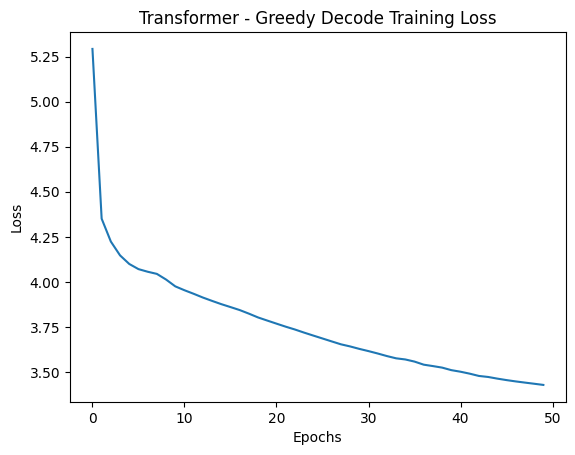

In [ ]:
train_loss = [tracker['train_loss'][i].item() for i in range(len(tracker['train_loss']))]
epochs = [i for i in range(0, len(train_loss))]

#Plotting the loss
plt.plot(epochs, train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer - Greedy Decode Training Loss')
plt.show()

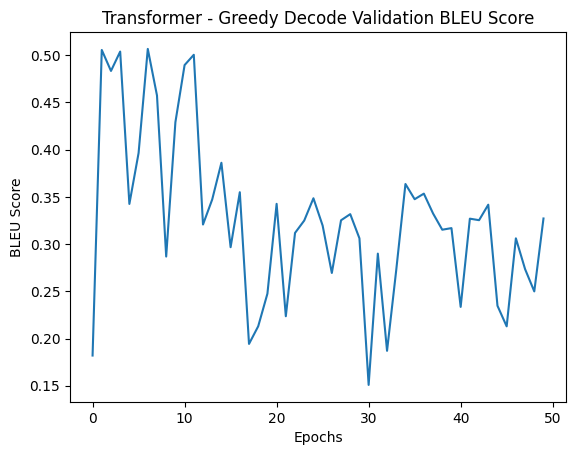

In [ ]:
#Plotting the bleu score during validation
plt.plot(epochs, tracker['bleu'])
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Transformer - Greedy Decode Validation BLEU Score')
plt.show()

It can be seen that the bleu score can reach a peak of about 50% during the training process and validating around epoch 7 or 8 but then decreases even though the training loss still decreases steadily.

## **2. Span Text Transformer**

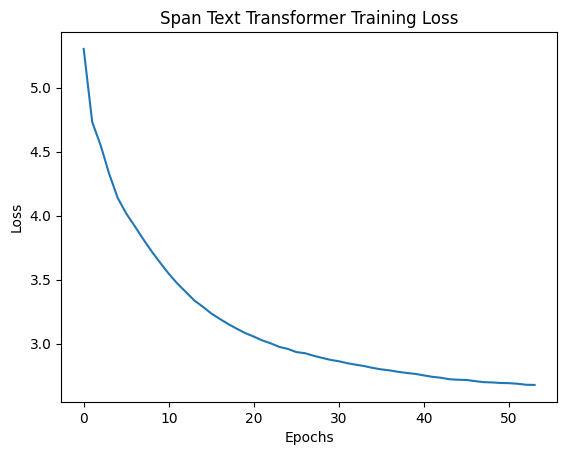

In [ ]:
train_loss = [tracker['train_loss'][i] for i in range(len(tracker['train_loss']))]
epochs = [i for i in range(0, len(train_loss))]

#Plotting the loss
plt.plot(epochs, train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Span Text Transformer Training Loss')
plt.show()

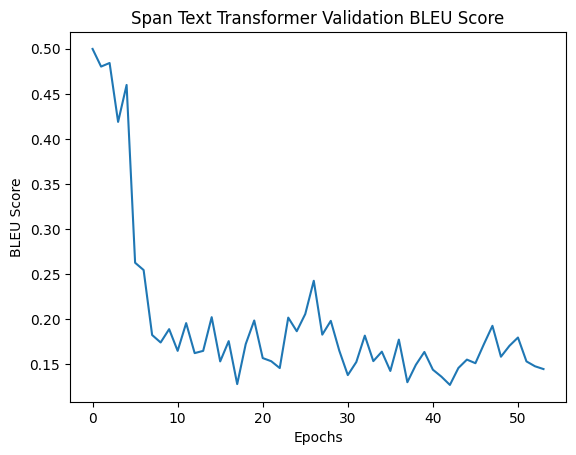

In [ ]:
#Plotting the bleu score during validation
plt.plot(epochs, tracker['bleu'])
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Span Text Transformer Validation BLEU Score')
plt.show()

It can be seen that the bleu score can reach a peak of about 50% during the training process and validating around epoch 7 or 8 but then decreases even though the training loss still decreases steadily.

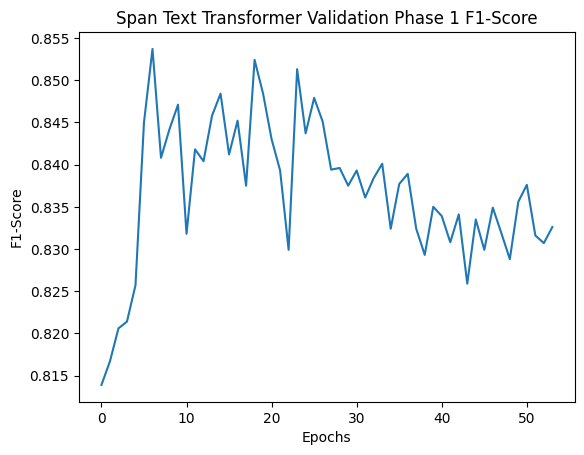

In [ ]:
#Plotting the bleu score during validation
plt.plot(epochs, tracker['f1'])
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('Span Text Transformer Validation Phase 1 F1-Score')
plt.show()

## **3. BERT + BART Question Answering**

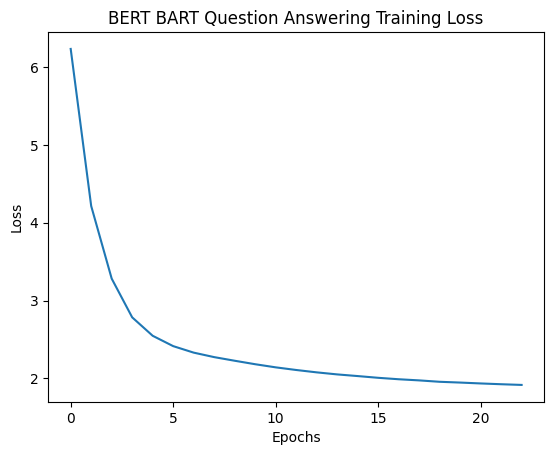

In [ ]:
train_loss = [tracker['train_loss'][i] for i in range(len(tracker['train_loss']))]
epochs = [i for i in range(0, len(train_loss))]

#Plotting the loss
plt.plot(epochs, train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BERT BART Question Answering Training Loss')
plt.show()

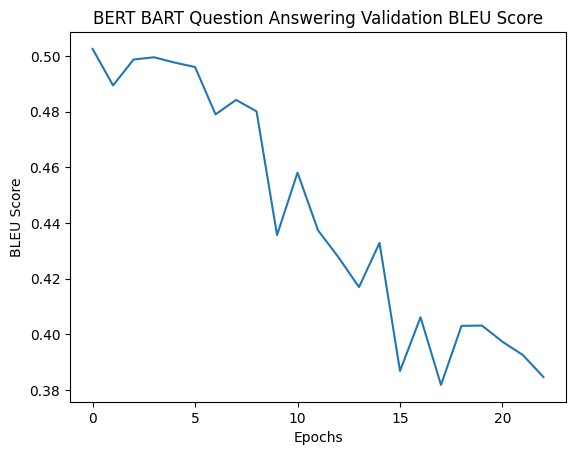

In [ ]:
#Plotting the bleu score during validation
plt.plot(epochs, tracker['bleu'])
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('BERT BART Question Answering Validation BLEU Score')
plt.show()

Like the previous models, the combined model between BERT and BART is also biased at the BLEU score, so the score is quite high and then drops sharply.

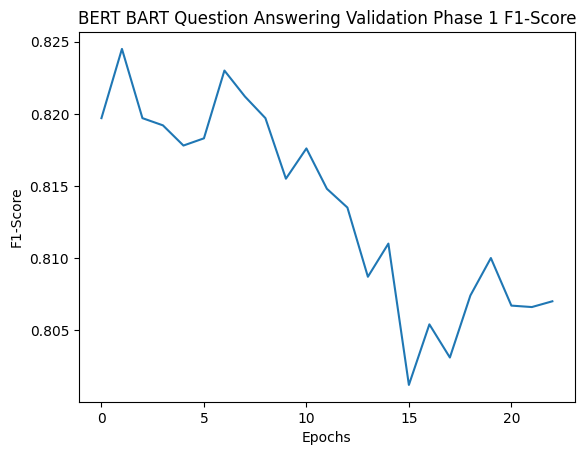

In [ ]:
#Plotting the bleu score during validation
plt.plot(epochs, tracker['f1'])
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('BERT BART Question Answering Validation Phase 1 F1-Score')
plt.show()

# **VIII. Conclusion**

## **1.Original Transformer**

For the Transformer model using our greedy search, the result with a BLEU score is 50.54. However, the model is biased towards predicting that there is no answer to the question. This is understandable since more than 50% of validating and testing data samples are unanswered samples.

Therefore, the next step is to find a model that can give BLEU less than 50%, but is capable of predicting other answers rather than predicting no answer. Or the best case scenario is that the model achieves a BLEU score about 5-10% higher than the current one (this is very unlikely).

Further experiment directions include:
1. Applying New Architecture which include two Encoder Block and 1 Decoder Blocks:
  + The first Encoder will go with a Linear Layer to predict the sentence that contain the answers
  + The second Encoder Block and Decoder Block will generate answer from the question and the span text (sentences that may contain answers).
2. Use F1 score in addition to BLEU score as evaluation metrics to select more models besides the model with the highest BLEU score, because these models with the highest BLEU score tend to predict no answer since the data with no answer accounts for more than half practice evaluation and testing.:
  + F1-score: used to measure the model's ability to accurately predict the span text of stage 1.

## **2. Span Text Transformer**

Adding a component that identifies the sentence or sentences containing the answer along with the combination of F1-score and exact match as evaluation metrics has helped the selected model predict more diverse answers. The model no longer has the problem of always predicting no answer. However, with more "deep" answers, the model has a high chance of predicting wrongly. For example, for the question "What is Mr. A's major?", instead of a clear answer like "biology", the "deep" answer would be "biologist".
To overcome this situation, our team continues to try to come up with the next directions such as:
1. Using pre-trained models:
  *   Use BERT for the first stage of extracting span text, because they have an encoder block architecture of the Transformer model so they can be suitable for this stage.
  *   Using BART for phase 2 is to answer questions from span text. BART has an architecture that is a combination of BERT and GPT, so it is like a complete Transformer model with both encoder and decoder blocks, which may be suitable for this stage.



## **3. BERT + BART Question Answering**

It can be seen that combining BERT and BART is not effective for the problem. The explanation for this can be divided into two main reasons:
  1. Subjective reasons:
    *   The group may not have chosen the right models for the problem.
    *   There are problems with choosing hyperparameters, optimizers and loss functions during training.
  2. The objective reasons mostly come from insufficient training resources:
    *   To accommodate the project's resources and time, our team limited each model to training for only one day on Google Colab's A100 GPU. Maybe that amount of training time is not enough for the BERT and BART engineering models to work well.
    *   Not enough GPUs to test models with larger architectures.

In future works, we will focus more on pre-processing to handle the unbalancing of the data with techniques such as Oversampling or UnderSampling. For now, this is the current conclusion of our group's second project.

